In [1]:
# Import libraries

import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd
import matplotlib.pyplot as plt
import re, gc, time, os, math
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.offline as offline
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from prettytable import PrettyTable
from collections import Counter
from scipy.sparse import hstack
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from plotly import tools
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import normalize, StandardScaler, PolynomialFeatures, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import SGDClassifier, LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_curve, auc, precision_recall_curve, f1_score
from catboost import CatBoostClassifier, Pool, cv
import phik
from datetime import datetime

In [2]:
# Training data

app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [3]:
# Testing data

app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [4]:
# Bureau data

bureau_data = pd.read_csv('bureau.csv')
print('Bureau data shape: ', bureau_data.shape)
bureau_data.head()

Bureau data shape:  (1716428, 17)


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [5]:
# Bureau Balance data

bureau_balance = pd.read_csv('bureau_balance.csv')
print('Bureau data shape: ', bureau_balance.shape)
bureau_balance.head()

Bureau data shape:  (27299925, 3)


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [6]:
# POS CASH Balance data

pos_cash_balance = pd.read_csv('POS_CASH_balance.csv')
print('POS CASH Balance data shape: ', pos_cash_balance.shape)
pos_cash_balance.head()

POS CASH Balance data shape:  (10001358, 8)


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [7]:
# Credit Card Balance data

credit_card_balance = pd.read_csv('credit_card_balance.csv')
print('Credit Card Balance data shape: ', credit_card_balance.shape)
credit_card_balance.head()

Credit Card Balance data shape:  (3840312, 23)


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

In [8]:
# Previous Application data

previous_application = pd.read_csv('previous_application.csv')
print('Previous Application data shape: ', previous_application.shape)
previous_application.head()

Previous Application data shape:  (1670214, 37)


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

In [9]:
# Installments Payments data

installments_payments = pd.read_csv('installments_payments.csv')
print('Installments Payments data shape: ', installments_payments.shape)
installments_payments.head()

Installments Payments data shape:  (13605401, 8)


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [10]:
# Checking Missing data in Training data

total = app_train.isnull().sum().sort_values(ascending = False)
percent = (app_train.isnull().sum()/app_train.isnull().count()*100).sort_values(ascending = False)
missing_application_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_application_train_data.head(15)

Total    Percent
COMMONAREA_MEDI           214865  69.872297
COMMONAREA_AVG            214865  69.872297
COMMONAREA_MODE           214865  69.872297
NONLIVINGAPARTMENTS_MODE  213514  69.432963
NONLIVINGAPARTMENTS_AVG   213514  69.432963
NONLIVINGAPARTMENTS_MEDI  213514  69.432963
FONDKAPREMONT_MODE        210295  68.386172
LIVINGAPARTMENTS_MODE     210199  68.354953
LIVINGAPARTMENTS_AVG      210199  68.354953
LIVINGAPARTMENTS_MEDI     210199  68.354953
FLOORSMIN_AVG             208642  67.848630
FLOORSMIN_MODE            208642  67.848630
FLOORSMIN_MEDI            208642  67.848630
YEARS_BUILD_MEDI          204488  66.497784
YEARS_BUILD_MODE          204488  66.497784

In [11]:
# Checking Missing data in Test data

total = app_test.isnull().sum().sort_values(ascending = False)
percent = (app_test.isnull().sum()/app_test.isnull().count()*100).sort_values(ascending = False)
missing_app_test_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_app_test_data.head(15)

Total    Percent
COMMONAREA_AVG            33495  68.716150
COMMONAREA_MODE           33495  68.716150
COMMONAREA_MEDI           33495  68.716150
NONLIVINGAPARTMENTS_AVG   33347  68.412523
NONLIVINGAPARTMENTS_MODE  33347  68.412523
NONLIVINGAPARTMENTS_MEDI  33347  68.412523
FONDKAPREMONT_MODE        32797  67.284179
LIVINGAPARTMENTS_AVG      32780  67.249302
LIVINGAPARTMENTS_MODE     32780  67.249302
LIVINGAPARTMENTS_MEDI     32780  67.249302
FLOORSMIN_MEDI            32466  66.605121
FLOORSMIN_AVG             32466  66.605121
FLOORSMIN_MODE            32466  66.605121
OWN_CAR_AGE               32312  66.289184
YEARS_BUILD_AVG           31818  65.275726

In [12]:
# Checking Missing data in Bureau data

total = bureau_data.isnull().sum().sort_values(ascending = False)
percent = (bureau_data.isnull().sum()/bureau_data.isnull().count()*100).sort_values(ascending = False)
missing_bureau_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_bureau_data.head(8)

Total    Percent
AMT_ANNUITY             1226791  71.473490
AMT_CREDIT_MAX_OVERDUE  1124488  65.513264
DAYS_ENDDATE_FACT        633653  36.916958
AMT_CREDIT_SUM_LIMIT     591780  34.477415
AMT_CREDIT_SUM_DEBT      257669  15.011932
DAYS_CREDIT_ENDDATE      105553   6.149573
AMT_CREDIT_SUM               13   0.000757
CREDIT_ACTIVE                 0   0.000000

In [13]:
# Checking Missing data in Bureau Balance data

total = bureau_balance.isnull().sum().sort_values(ascending = False)
percent = (bureau_balance.isnull().sum()/bureau_balance.isnull().count()*100).sort_values(ascending = False)
missing_bureau_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_bureau_balance_data.head(3)

Total  Percent
SK_ID_BUREAU        0      0.0
MONTHS_BALANCE      0      0.0
STATUS              0      0.0

In [14]:
# Checking Missing data in POS Cash Balance data

total = pos_cash_balance.isnull().sum().sort_values(ascending = False)
percent = (pos_cash_balance.isnull().sum()/pos_cash_balance.isnull().count()*100).sort_values(ascending = False)
missing_pos_cash_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_pos_cash_balance_data.head(3)

Total   Percent
CNT_INSTALMENT_FUTURE  26087  0.260835
CNT_INSTALMENT         26071  0.260675
SK_ID_PREV                 0  0.000000

In [15]:
# Checking Missing data in Credit Card Balance data

total = credit_card_balance.isnull().sum().sort_values(ascending = False)
percent = (credit_card_balance.isnull().sum()/credit_card_balance.isnull().count()*100).sort_values(ascending = False)
missing_credit_card_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_credit_card_balance_data.head(10)

Total    Percent
AMT_PAYMENT_CURRENT         767988  19.998063
AMT_DRAWINGS_ATM_CURRENT    749816  19.524872
CNT_DRAWINGS_POS_CURRENT    749816  19.524872
AMT_DRAWINGS_OTHER_CURRENT  749816  19.524872
AMT_DRAWINGS_POS_CURRENT    749816  19.524872
CNT_DRAWINGS_OTHER_CURRENT  749816  19.524872
CNT_DRAWINGS_ATM_CURRENT    749816  19.524872
CNT_INSTALMENT_MATURE_CUM   305236   7.948208
AMT_INST_MIN_REGULARITY     305236   7.948208
SK_ID_PREV                       0   0.000000

In [16]:
# Checking Missing data in Previous Application data

total = previous_application.isnull().sum().sort_values(ascending = False)
percent = (previous_application.isnull().sum()/previous_application.isnull().count()*100).sort_values(ascending = False)
missing_previous_application_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_previous_application_data.head(15)

Total    Percent
RATE_INTEREST_PRIVILEGED   1664263  99.643698
RATE_INTEREST_PRIMARY      1664263  99.643698
AMT_DOWN_PAYMENT            895844  53.636480
RATE_DOWN_PAYMENT           895844  53.636480
NAME_TYPE_SUITE             820405  49.119754
NFLAG_INSURED_ON_APPROVAL   673065  40.298129
DAYS_TERMINATION            673065  40.298129
DAYS_LAST_DUE               673065  40.298129
DAYS_LAST_DUE_1ST_VERSION   673065  40.298129
DAYS_FIRST_DUE              673065  40.298129
DAYS_FIRST_DRAWING          673065  40.298129
AMT_GOODS_PRICE             385515  23.081773
AMT_ANNUITY                 372235  22.286665
CNT_PAYMENT                 372230  22.286366
PRODUCT_COMBINATION            346   0.020716

In [17]:
# Checking Missing data in Installments Payments data

total = installments_payments.isnull().sum().sort_values(ascending = False)
percent = (installments_payments.isnull().sum()/installments_payments.isnull().count()*100).sort_values(ascending = False)
missing_installments_payments_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_installments_payments_data.head(3)

Total   Percent
DAYS_ENTRY_PAYMENT   2905  0.021352
AMT_PAYMENT          2905  0.021352
SK_ID_PREV              0  0.000000

In [18]:
# Function to create a dataframe of percentage of NaN values for each column of the dataframe

def nan_df_create(data):
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df


# Function to plot Bar Plots of NaN percentages for each Column with missing values

def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):
    
    #checking if there is any column with NaNs or not.
    if df_nan.percent.sum() != 0:
        print(f"Number of columns having NaN values: {df_nan[df_nan['percent'] != 0].shape[0]} columns")
        
        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'column', y = 'percent', data = df_nan[df_nan['percent'] > 0])
        plt.xticks(rotation = rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"The dataframe {title_name} does not contain any NaN values.")

In [19]:
# Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target

class correlation_matrix:
    '''
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    
    # Function to initialize the class members. 
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
   

    # Function to plot the Correlation Matrix Heatmap
    
    def plot_correlation_matrix(self):
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    
    # Function to return the Top Correlated features with the Target
    
    def target_top_corr(self, target_top_columns = 10):
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

In [20]:
# Function to Phi_k matrix for categorical features

def plot_phik_matrix(data, categorical_columns, figsize = (20,20), mask_upper = True, tight_layout = True, linewidth = 0.1, fontsize = 10, cmap = 'Blues', show_target_top_corr = True, target_top_columns = 10):
    
    #first fetching only the categorical features
    data_for_phik = data[categorical_columns].astype('object')
    phik_matrix = data_for_phik.phik_matrix()
    
    print('-'*100)
    
    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)
        
    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name' : phik_matrix.TARGET.index[1:], 'Phik-Correlation' : phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100) 
        
        
# Function to plot Categorical Variables Bar Plots

def plot_categorical_variables_bar(data, column_name, figsize = (18,6), percentage_display = True, plot_defaulter = True, rotation = 0, horizontal_adjust = 0, fontsize_percent = 'xx-small'):
    
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)
    plt.show()
    

# Function to plot categorical variables Pie Plots

def plot_categorical_variables_pie(data, column_name, plot_defaulter = True, hole = 0):
    
    if plot_defaulter:
        cols = 2
        specs = [[{'type' : 'domain'}, {'type' : 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets', f'Percentage of Defaulters for each category of {column_name}']
    else:
        cols = 1
        specs = [[{'type': 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets']
        
    values_categorical = data[column_name].value_counts()
    labels_categorical = values_categorical.index
    
    fig = make_subplots(rows = 1, cols = cols, 
                       specs = specs, 
                       subplot_titles = titles)
    
    fig.add_trace(go.Pie(values = values_categorical, labels = labels_categorical, hole = hole, 
                         textinfo = 'label+percent', textposition = 'inside'), row = 1, col = 1)
    
    if plot_defaulter:
        percentage_defaulter_per_category = data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()
        percentage_defaulter_per_category.dropna(inplace = True)
        percentage_defaulter_per_category = percentage_defaulter_per_category.round(2)
        
        fig.add_trace(go.Pie(values = percentage_defaulter_per_category, labels = percentage_defaulter_per_category.index, 
                             hole = hole, textinfo = 'label+value', hoverinfo = 'label+value'), row = 1, col = 2)
        
    fig.update_layout(title = f'Distribution of {column_name}')
    fig.show()
    
    
# Function to print the basic stats such as unique categories and their counts for categorical variables

def print_unique_categories(data, column_name, show_counts = False):
        
    print('-'*100)
    print(f"The unique categories of '{column_name}' are:\n{data[column_name].unique()}")
    print('-'*100)
    
    if show_counts:
        print(f"Counts of each category are:\n{data[column_name].value_counts()}")
        print('-'*100)
        

# Function to plot CDF of a continuour variable
        
def plot_cdf(data, column_name, log_scale = False, figsize = (12,8)):
            
    percentile_values = data[[column_name]].dropna().sort_values(by = column_name)
    percentile_values['Percentile'] = [ele / (len(percentile_values) - 1) for ele in range(len(percentile_values))]

    plt.figure(figsize = figsize)
    if log_scale:
        plt.xscale('log')
        plt.xlabel(column_name + ' - (log-scale)')
    else:
        plt.xlabel(column_name)
    plt.plot(percentile_values[column_name], percentile_values['Percentile'], color = 'red')
    plt.ylabel('Probability')
    plt.title('CDF of {}'.format(column_name))
    plt.show()
    

# Function to print percentile values for given column

def print_percentiles(data, column_name, percentiles = None):
    
    print('-'*100)
    if not percentiles:
        percentiles = list(range(0,80,25)) + list(range(90,101,2))
    for i in percentiles:
        print(f'The {i}th percentile value of {column_name} is {np.percentile(data[column_name].dropna(), i)}')
    print("-"*100)
    
    
    
# Function to plot continuous variables distribution

def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()
    
    
# Plot numerical variables

def num_plot(data, num_cols, remove=["Id"], hist_bins=10, figsize=(20, 4)):

    if len(remove) > 0:
        num_cols2 = [x for x in num_cols if (x not in remove)]

    for i in num_cols2:
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        data.hist(str(i), bins=hist_bins, ax=axes[0])
        data.boxplot(str(i), ax=axes[1], vert=False);
        try:
            sns.kdeplot(np.array(data[str(i)]))
        except:
            ValueError

        axes[1].set_yticklabels([])
        axes[1].set_yticks([])
        axes[0].set_title(i + " | Histogram")
        axes[1].set_title(i + " | Boxplot")
        axes[2].set_title(i + " | Density")
        plt.show()
       
    
# Grab Column Names

def grab_col_names(dataframe, cat_th=10, car_th=20, show_date=False):
    date_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "datetime64[ns]"]

    #cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    cat_cols = dataframe.select_dtypes(["object", "category"]).columns.tolist()
    
    
    
    num_but_cat = [col for col in dataframe.select_dtypes(["float", "integer"]).columns if dataframe[col].nunique() < cat_th]

    cat_but_car = [col for col in dataframe.select_dtypes(["object", "category"]).columns if dataframe[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = dataframe.select_dtypes(["float", "integer"]).columns
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'date_cols: {len(date_cols)}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat_cols + num_cols + cat_but_car = değişken sayısı.
    # num_but_cat cat_cols'un içerisinde zaten.
    # dolayısıyla tüm şu 3 liste ile tüm değişkenler seçilmiş olacaktır: cat_cols + num_cols + cat_but_car
    # num_but_cat sadece raporlama için verilmiştir.

    if show_date == True:
        return date_cols, cat_cols, cat_but_car, num_cols, num_but_cat
    else:
        return cat_cols, cat_but_car, num_cols, num_but_cat
    
    
# Numerical Variables correlation plot

def corr_plot(data, remove=["Id"], corr_coef = "pearson", figsize=(20, 20)):
    if len(remove) > 0:
        num_cols2 = [x for x in data.columns if (x not in remove)]

    sns.set(font_scale=1.1)
    c = data[num_cols2].corr(method = corr_coef)
    mask = np.triu(c.corr(method = corr_coef))
    plt.figure(figsize=figsize)
    sns.heatmap(c,
                annot=True,
                fmt='.1f',
                cmap='coolwarm',
                square=True,
                mask=mask,
                linewidths=1,
                cbar=False)
    plt.show()

# Exploratory Data Analysis

## EDA for Application Data

Number of columns having NaN values: 67 columns


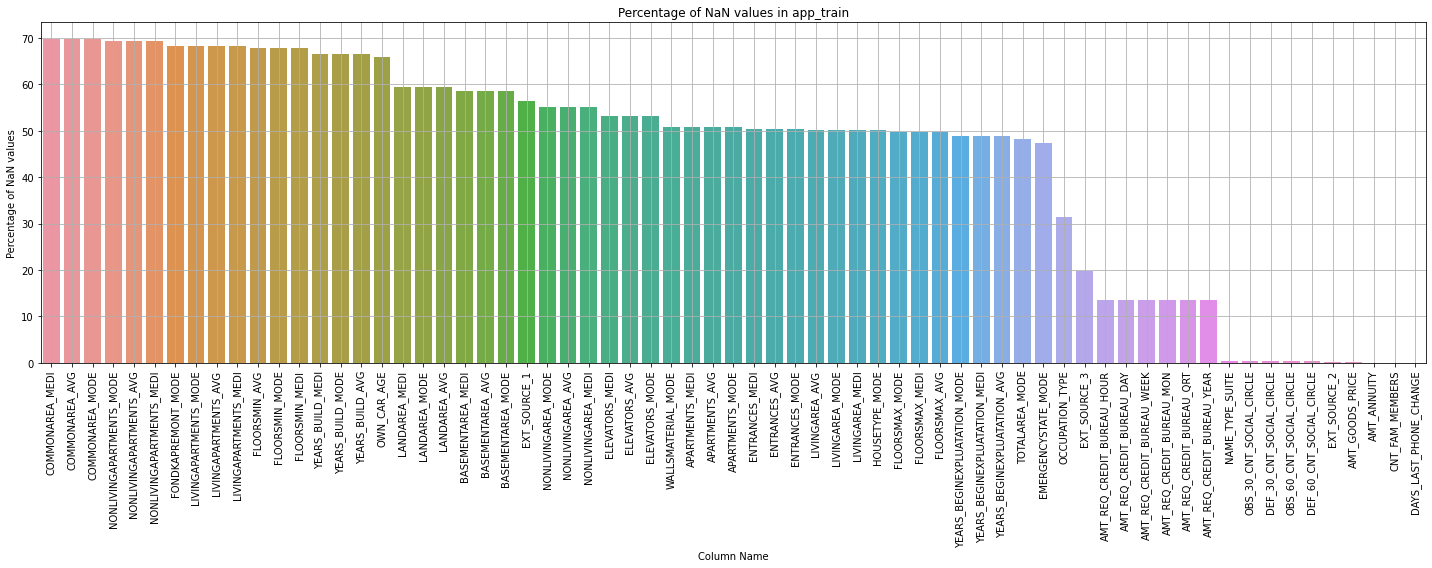

In [21]:
plot_nan_percent(nan_df_create(app_train), 'app_train', grid = True)

Number of columns having NaN values: 64 columns


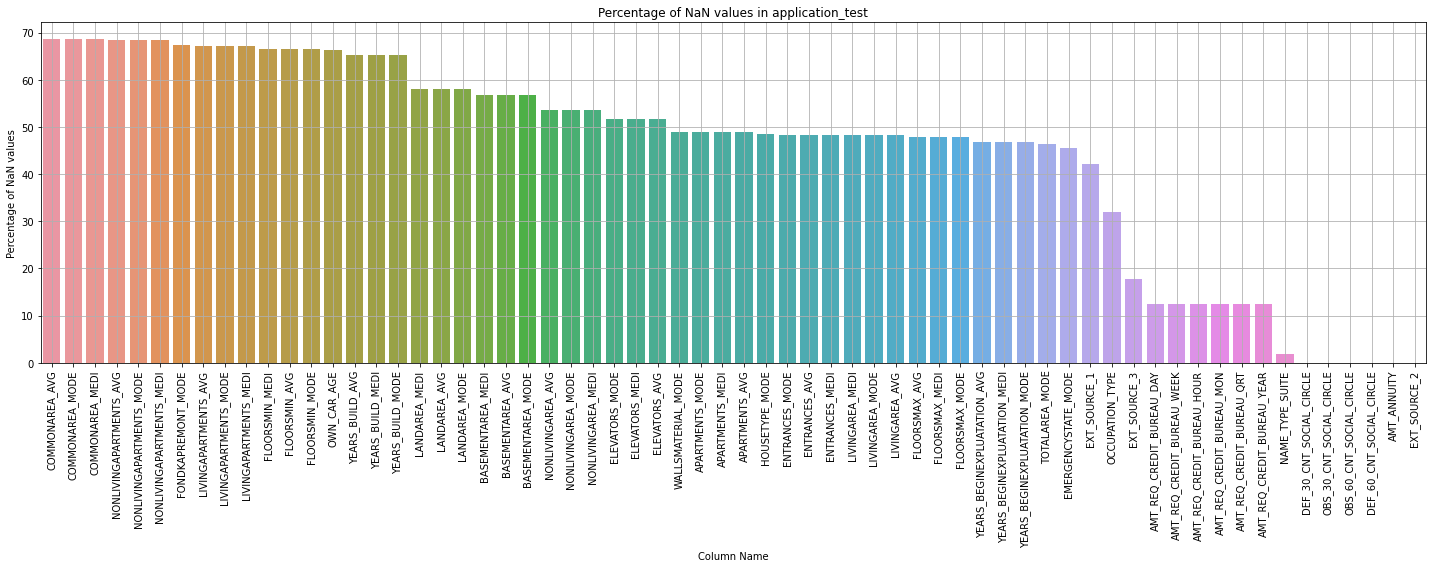

In [22]:
plot_nan_percent(nan_df_create(app_test), 'application_test', grid = True)

## Distribution of Target Variable - Check if Data is balanced or imbalanced

In [23]:
temp = app_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Loan Repayed or not')

## Phi-K matrix

----------------------------------------------------------------------------------------------------


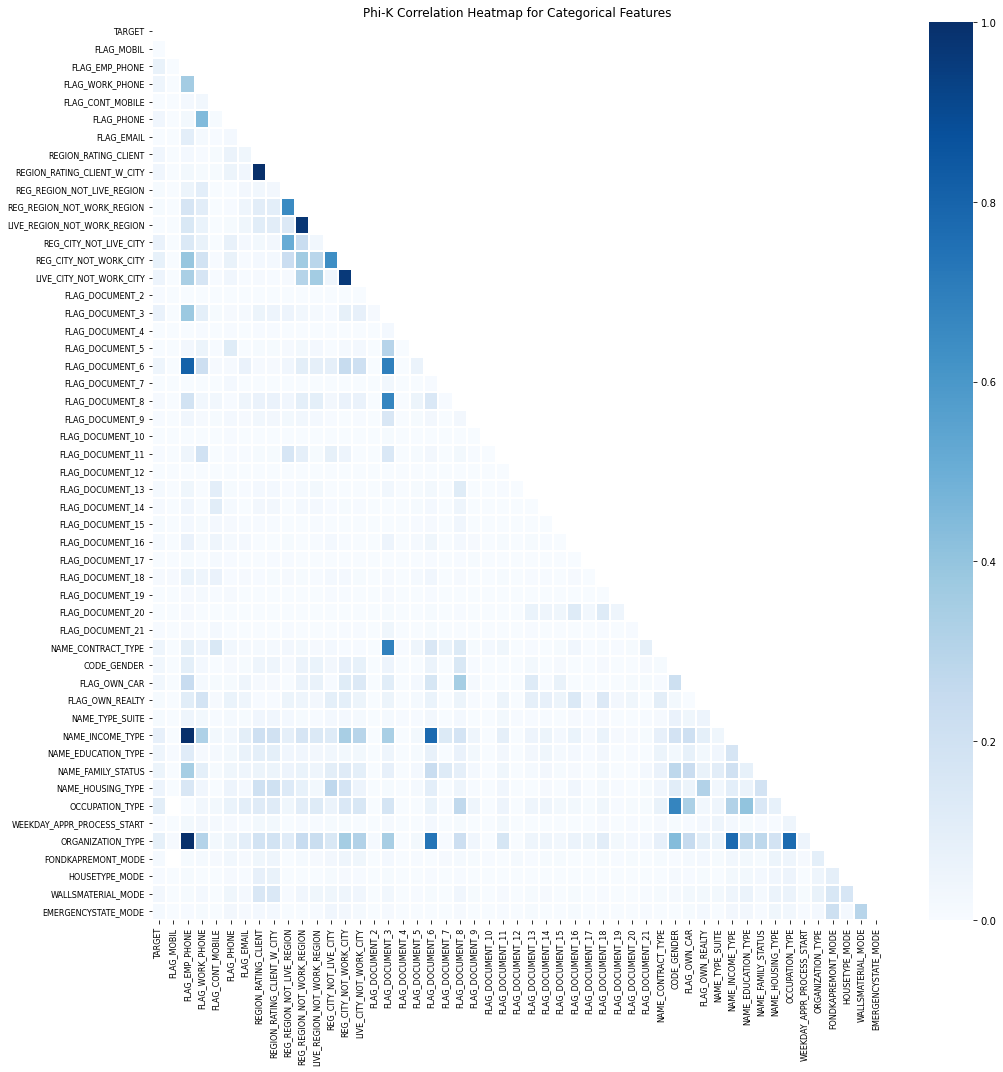

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


Column Name  Phik-Correlation
43          OCCUPATION_TYPE          0.102846
45        ORGANIZATION_TYPE          0.089164
39         NAME_INCOME_TYPE          0.084831
12   REG_CITY_NOT_WORK_CITY          0.079946
1            FLAG_EMP_PHONE          0.072087
11   REG_CITY_NOT_LIVE_CITY          0.069588
15          FLAG_DOCUMENT_3          0.069525
41       NAME_FAMILY_STATUS          0.056043
42        NAME_HOUSING_TYPE          0.051107
13  LIVE_CITY_NOT_WORK_CITY          0.050956

----------------------------------------------------------------------------------------------------


In [24]:
categorical_columns = ['TARGET','FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                                   'FLAG_PHONE', 'FLAG_EMAIL','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY',
                                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                                   'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                                'LIVE_CITY_NOT_WORK_CITY'] + ['FLAG_DOCUMENT_' + str(i) for i in range(2,22)] + app_train.dtypes[
                                    app_train.dtypes == 'object'].index.tolist()
plot_phik_matrix(app_train, categorical_columns, figsize = (15,15), fontsize = 8)

## Correlation Matrix of Features

----------------------------------------------------------------------------------------------------


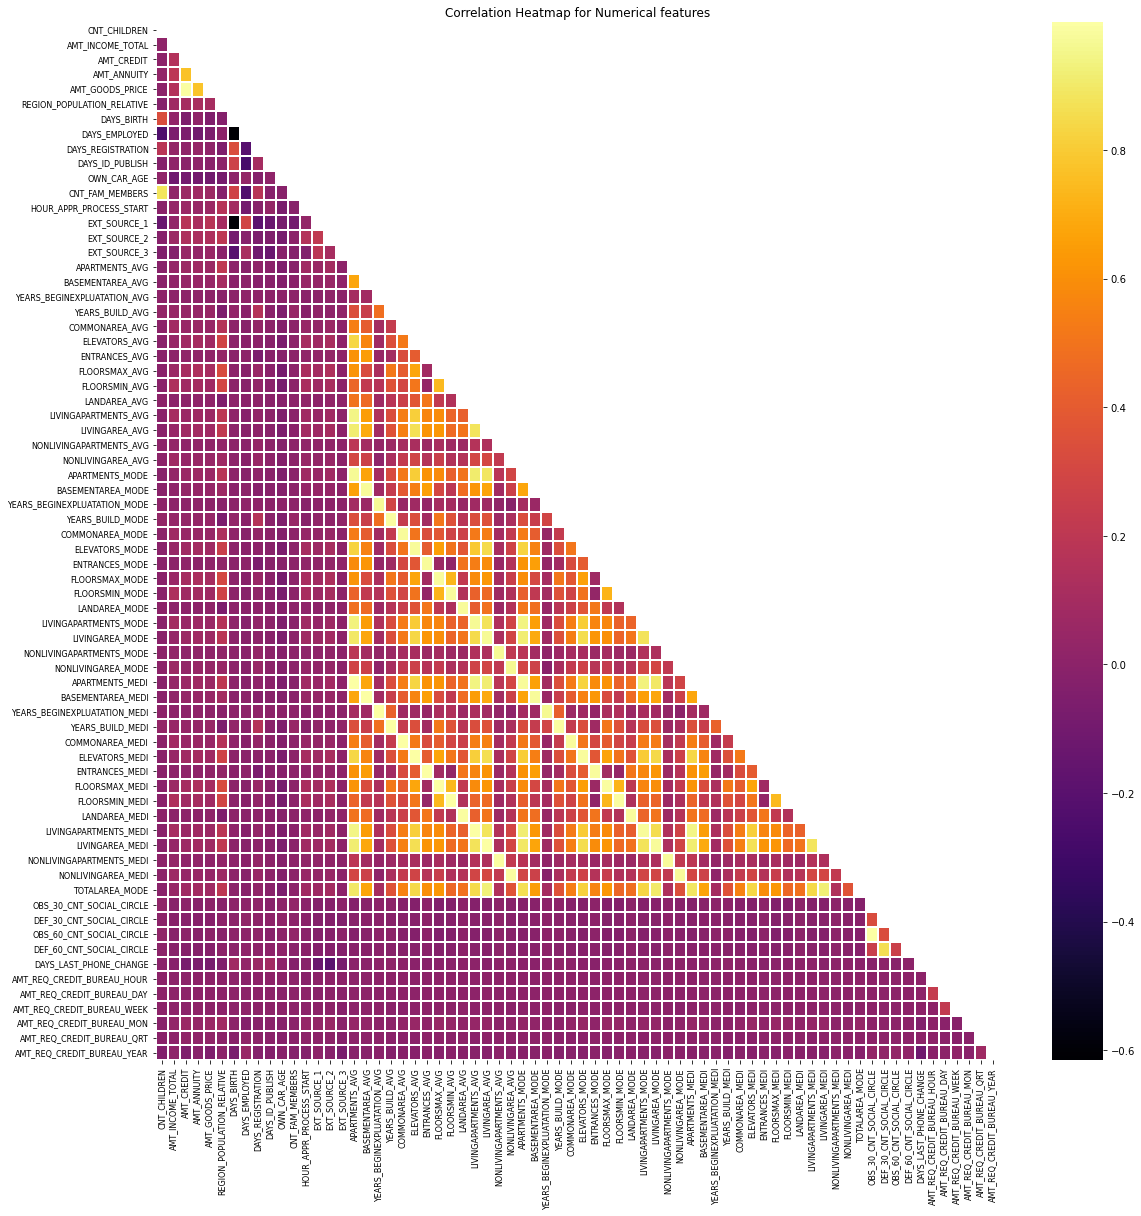

----------------------------------------------------------------------------------------------------


In [25]:
columns_to_drop = ['SK_ID_CURR'] + list(set(categorical_columns) - set(['TARGET']))
corr_mat = correlation_matrix(app_train, columns_to_drop, figsize = (17,17), fontsize = 8, cmap = 'inferno')
corr_mat.plot_correlation_matrix()

In [26]:
# Checking the top columns with highest phik-correlation with the target variable in application_train table

top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'CNT_CHILDREN']
interval columns not set, guessing: ['TARGET', 'AMT_INCOME_TOTAL']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'REGION_POPULATION_RELATIVE']
interval columns not set, guessing: ['TARGET', 'DAYS_BIRTH']
interval columns not set, guessing: ['TARGET', 'DAYS_EMPLOYED']
interval columns not set, guessing: ['TARGET', 'DAYS_REGISTRATION']
interval columns not set, guessing: ['TARGET', 'DAYS_ID_PUBLISH']
interval columns not set, guessing: ['TARGET', 'OWN_CAR_AGE']
interval columns not set, guessing: ['TARGET', 'CNT_FAM_MEMBERS']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_1']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_2']
interval columns 

Column Name  Phik-Correlation
15            EXT_SOURCE_3          0.247680
13            EXT_SOURCE_1          0.217846
14            EXT_SOURCE_2          0.213965
6               DAYS_BIRTH          0.102378
63  DAYS_LAST_PHONE_CHANGE          0.073218
7            DAYS_EMPLOYED          0.072095
9          DAYS_ID_PUBLISH          0.067766
4          AMT_GOODS_PRICE          0.059094
23           FLOORSMAX_AVG          0.058826
51          FLOORSMAX_MEDI          0.058595

----------------------------------------------------------------------------------------------------


# Plotting Categorical Variables

## Distribution of Categorical Variable NAME_CONTRACT_TYPE

In [27]:
#let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(app_train, 'NAME_CONTRACT_TYPE')

#plotting the Pie Plot for the column
plot_categorical_variables_pie(app_train, 'NAME_CONTRACT_TYPE', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_TYPE' are:
['Cash loans' 'Revolving loans']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


## Distribution of Categorical Variable CODE_GENDER

In [28]:
#let us first see the unique categories of 'CODE_GENDER'
print_unique_categories(app_train, 'CODE_GENDER', show_counts = True)

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(app_train, 'CODE_GENDER', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'CODE_GENDER' are:
['M' 'F' 'XNA']
----------------------------------------------------------------------------------------------------
Counts of each category are:
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


## Distribution of Categorical Variable FLAG_EMP_PHONE

In [29]:
#let us first see the unique categories of 'FLAG_EMP_PHONE'
print_unique_categories(app_train, 'FLAG_EMP_PHONE')

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(app_train, column_name = 'FLAG_EMP_PHONE', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'FLAG_EMP_PHONE' are:
[1 0]
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


## Distribution of Categorical Variable REGION_RATING_CLIENT_W_CITY

In [30]:
#let us first see the unique categories of 'REGION_RATING_CLIENT_W_CITY'
print_unique_categories(app_train, 'REGION_RATING_CLIENT_W_CITY')

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(app_train, column_name = 'REGION_RATING_CLIENT_W_CITY')
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'REGION_RATING_CLIENT_W_CITY' are:
[2 1 3]
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


## Distribution of Categorical Variable NAME_EDUCATION_TYPE

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_EDUCATION_TYPE' are:
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_EDUCATION_TYPE = 5


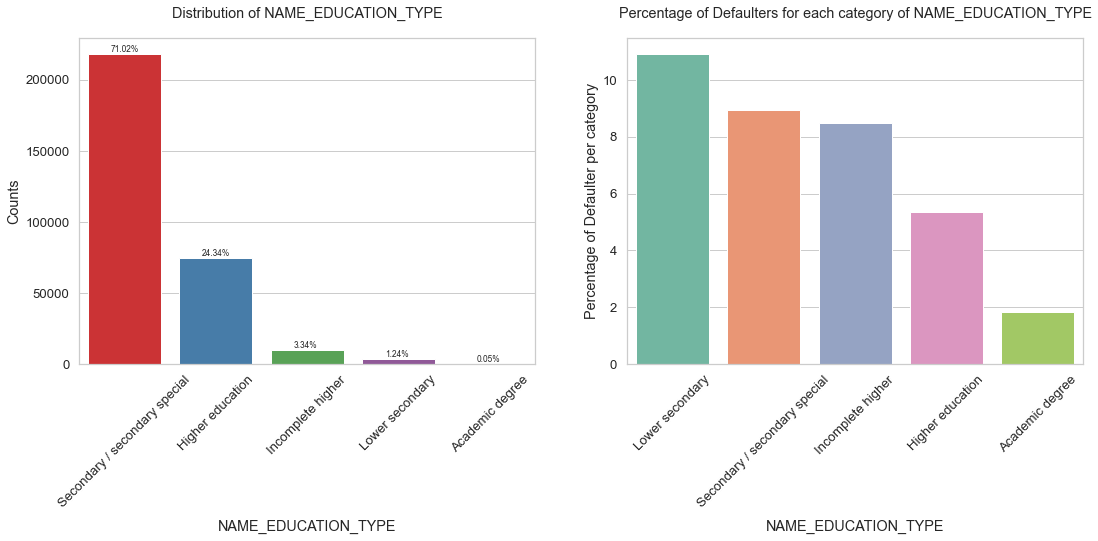

----------------------------------------------------------------------------------------------------


In [31]:
#let us first see the unique categories of 'NAME_EDUCATION_TYPE'
print_unique_categories(app_train, 'NAME_EDUCATION_TYPE', show_counts = True)

#plotting the Bar Plot for the Column
plot_categorical_variables_bar(app_train, column_name = 'NAME_EDUCATION_TYPE', rotation = 45, horizontal_adjust = 0.25)
print('-'*100)

## Distribution of Categorical Variable OCCUPATION_TYPE

----------------------------------------------------------------------------------------------------
The unique categories of 'OCCUPATION_TYPE' are:
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of OCCUPATION_TYPE = 19


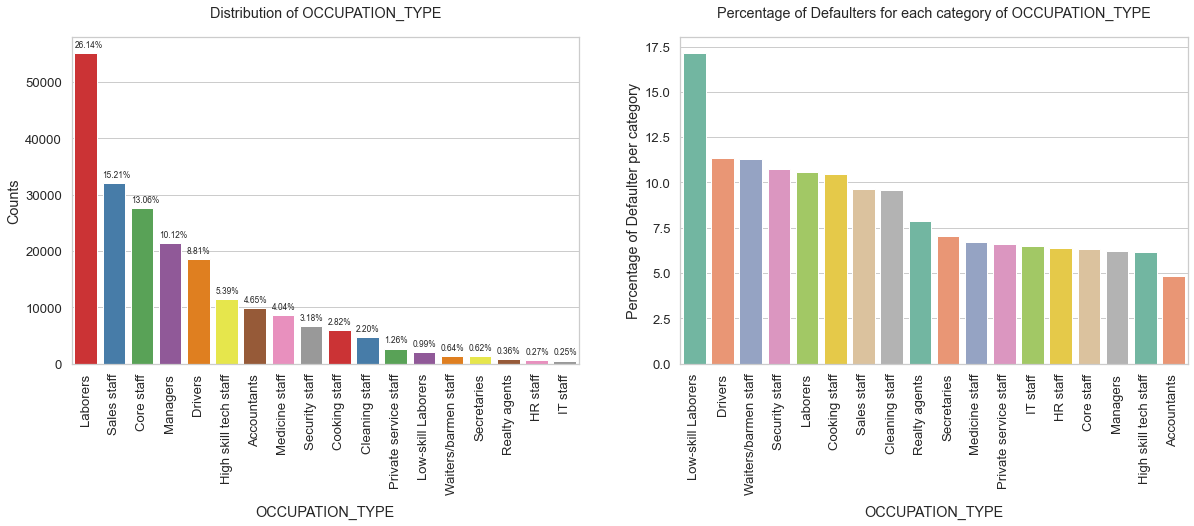

----------------------------------------------------------------------------------------------------


In [32]:
#let us first see the unique categories of 'OCCUPATION_TYPE'
print_unique_categories(app_train, 'OCCUPATION_TYPE')

#plotting the Bar Plot for the Column
plot_categorical_variables_bar(app_train, column_name = 'OCCUPATION_TYPE', figsize = (20,6), rotation = 90)
print('-'*100)

## Distribution of Categorical Variable ORGANIZATION_TYPE

Total Number of categories of ORGANIZATION_TYPE = 58


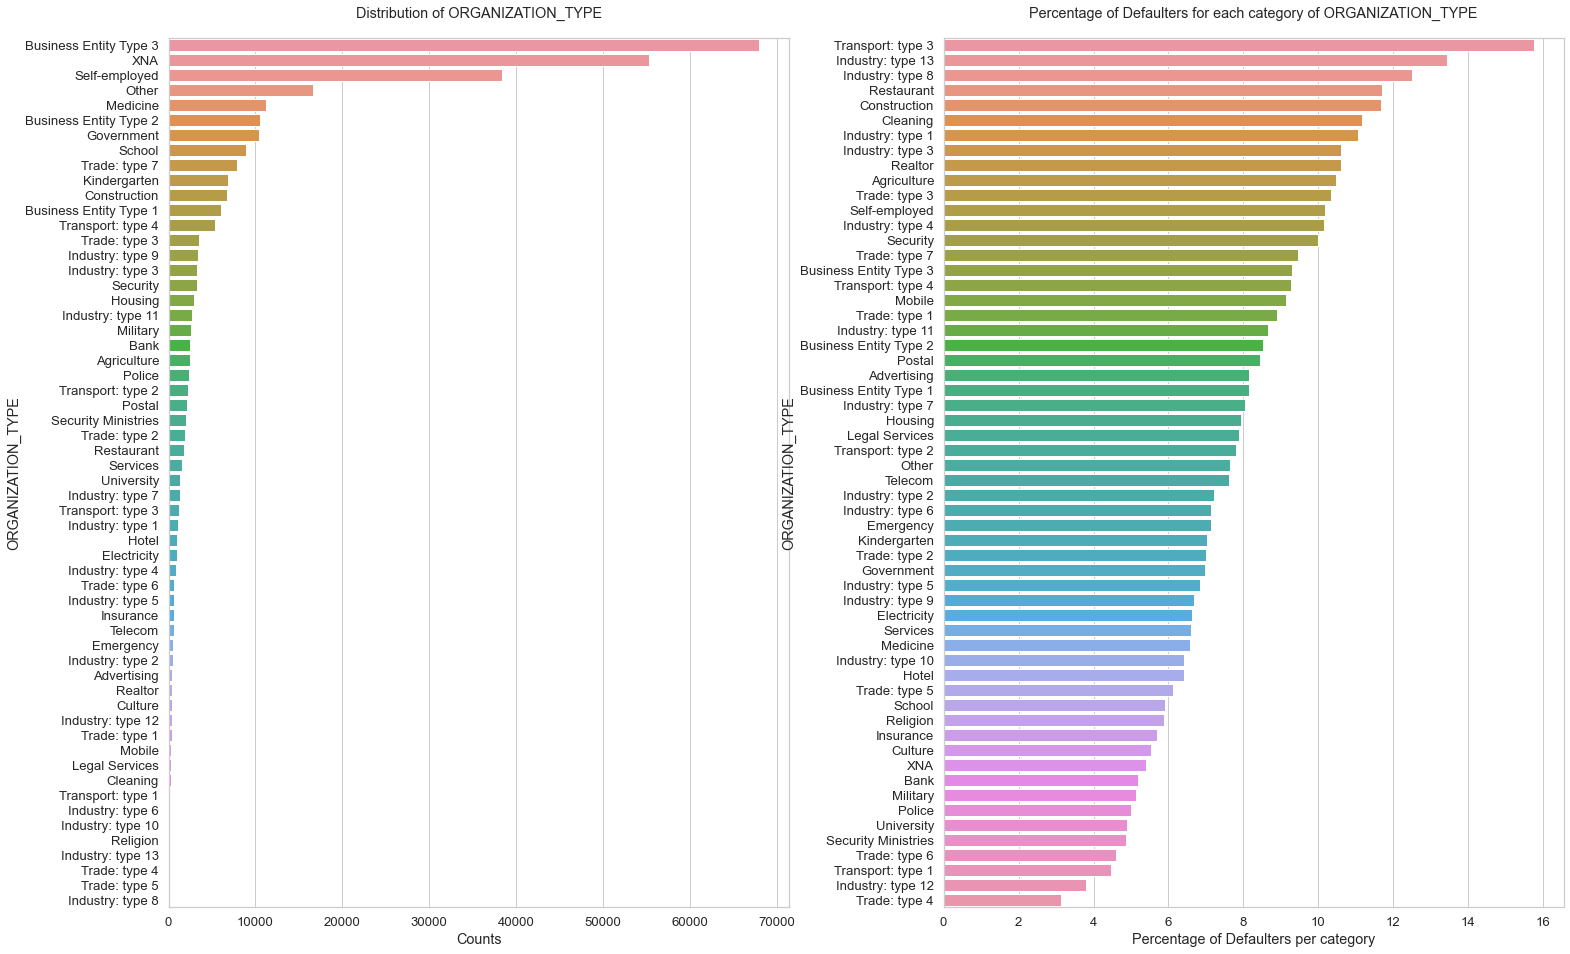

In [33]:
print(f"Total Number of categories of ORGANIZATION_TYPE = {len(app_train.ORGANIZATION_TYPE.unique())}")

plt.figure(figsize = (25,16))
sns.set(style = 'whitegrid', font_scale = 1.2)
plt.subplots_adjust(wspace=0.25)

plt.subplot(1,2,1)
count_organization = app_train.ORGANIZATION_TYPE.value_counts().sort_values(ascending = False)
sns.barplot(x = count_organization, y = count_organization.index)
plt.title('Distribution of ORGANIZATION_TYPE', pad = 20)
plt.xlabel('Counts')
plt.ylabel('ORGANIZATION_TYPE')

plt.subplot(1,2,2)
percentage_default_per_organization = app_train[app_train.TARGET == 1].ORGANIZATION_TYPE.value_counts() * 100 / count_organization
percentage_default_per_organization = percentage_default_per_organization.dropna().sort_values(ascending = False)
sns.barplot(x = percentage_default_per_organization, y = percentage_default_per_organization.index)
plt.title('Percentage of Defaulters for each category of ORGANIZATION_TYPE', pad = 20)
plt.xlabel('Percentage of Defaulters per category')
plt.ylabel('ORGANIZATION_TYPE')

plt.show()

## Distribution of Categorical Variable REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY

----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_LIVE_CITY = 2


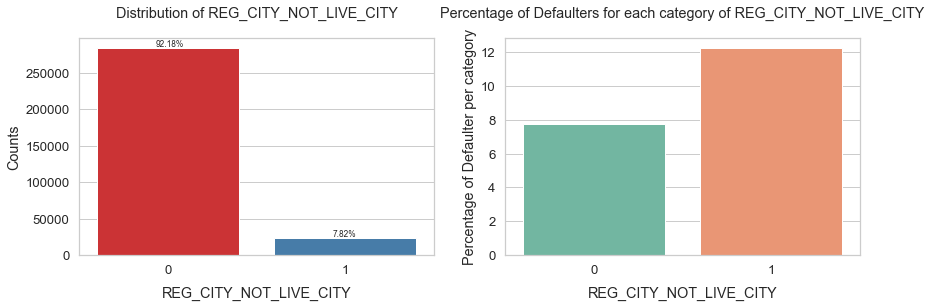

----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_WORK_CITY = 2


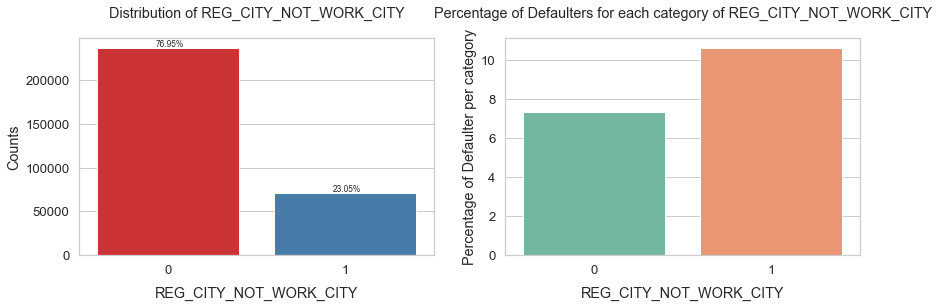

----------------------------------------------------------------------------------------------------
Total Number of unique categories of LIVE_CITY_NOT_WORK_CITY = 2


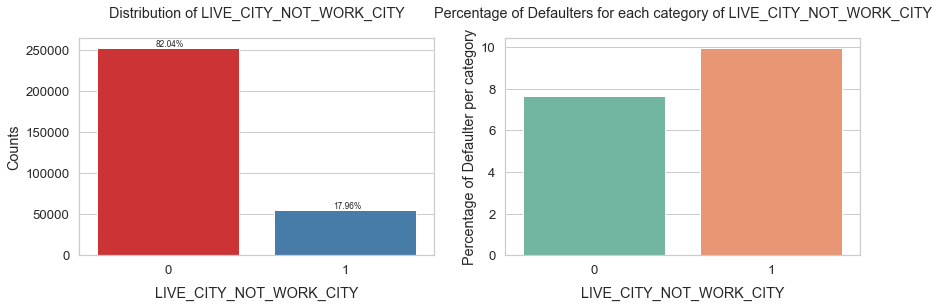

----------------------------------------------------------------------------------------------------


In [34]:
print('-'*100)
plot_categorical_variables_bar(app_train, column_name = 'REG_CITY_NOT_LIVE_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)
plot_categorical_variables_bar(app_train, column_name = 'REG_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)
plot_categorical_variables_bar(app_train, column_name = 'LIVE_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)

## Distribution of Categorical Variables FLAG_DOCUMENT_3

Total Number of unique categories of FLAG_DOCUMENT_3 = 2


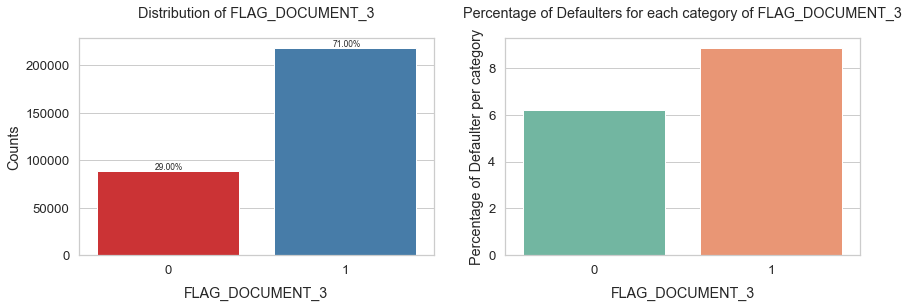

In [35]:
plot_categorical_variables_bar(app_train, column_name = 'FLAG_DOCUMENT_3', figsize = (14, 4), horizontal_adjust = 0.33)

# Plotting Continuous Variables

## Distribution of Continuous Variable Age of Applicant

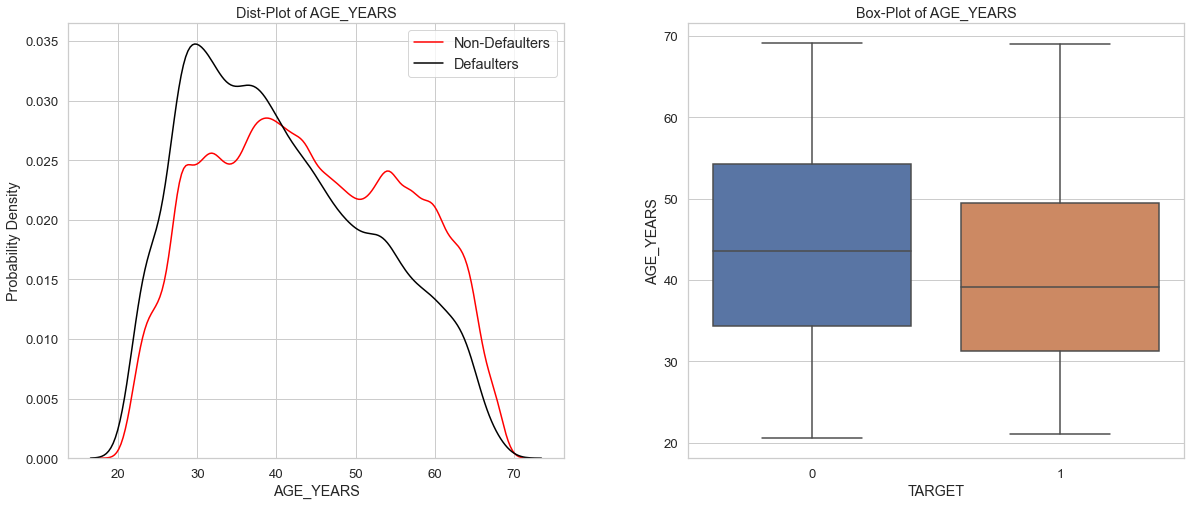

In [36]:
app_train['AGE_YEARS'] = app_train['DAYS_BIRTH'] * -1 / 365
plot_continuous_variables(app_train, 'AGE_YEARS', plots = ['distplot','box'])
_ = app_train.pop('AGE_YEARS')

## Distribution of Continuous Variables with DAYS features

## DAYS_EMPLOYED

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_EMPLOYED is -17912.0
The 25th percentile value of DAYS_EMPLOYED is -2760.0
The 50th percentile value of DAYS_EMPLOYED is -1213.0
The 75th percentile value of DAYS_EMPLOYED is -289.0
The 90th percentile value of DAYS_EMPLOYED is 365243.0
The 92th percentile value of DAYS_EMPLOYED is 365243.0
The 94th percentile value of DAYS_EMPLOYED is 365243.0
The 96th percentile value of DAYS_EMPLOYED is 365243.0
The 98th percentile value of DAYS_EMPLOYED is 365243.0
The 100th percentile value of DAYS_EMPLOYED is 365243.0
----------------------------------------------------------------------------------------------------


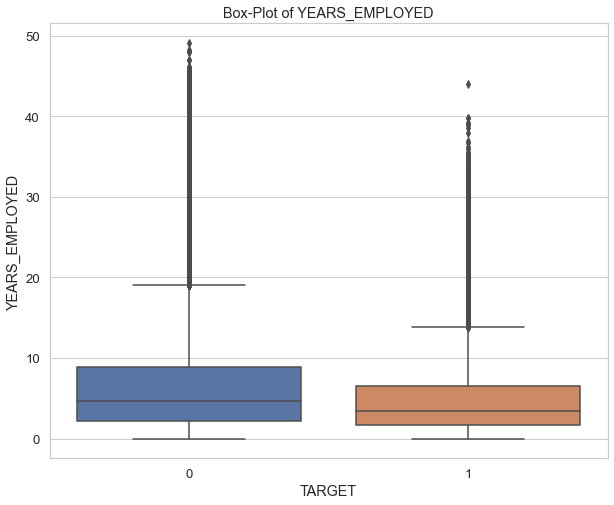

In [37]:
app_train['YEARS_EMPLOYED'] = app_train.DAYS_EMPLOYED * -1 / 365
print_percentiles(app_train, 'DAYS_EMPLOYED')
plot_continuous_variables(app_train, 'YEARS_EMPLOYED', plots = ['box'], scale_limits = [0,70], figsize = (10,8))
_ = app_train.pop('YEARS_EMPLOYED')

## DAYS_ID_PUBLISH

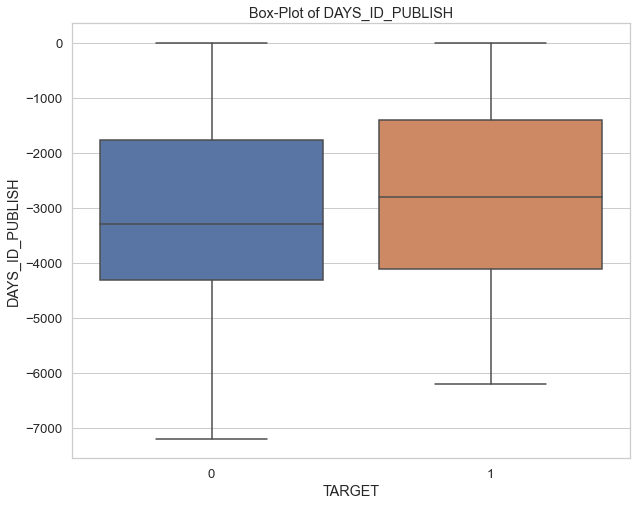

In [38]:
plot_continuous_variables(app_train, 'DAYS_ID_PUBLISH', plots = ['box'], figsize = (10,8))

## Distribution of EXT_SOURCES

----------------------------------------------------------------------------------------------------


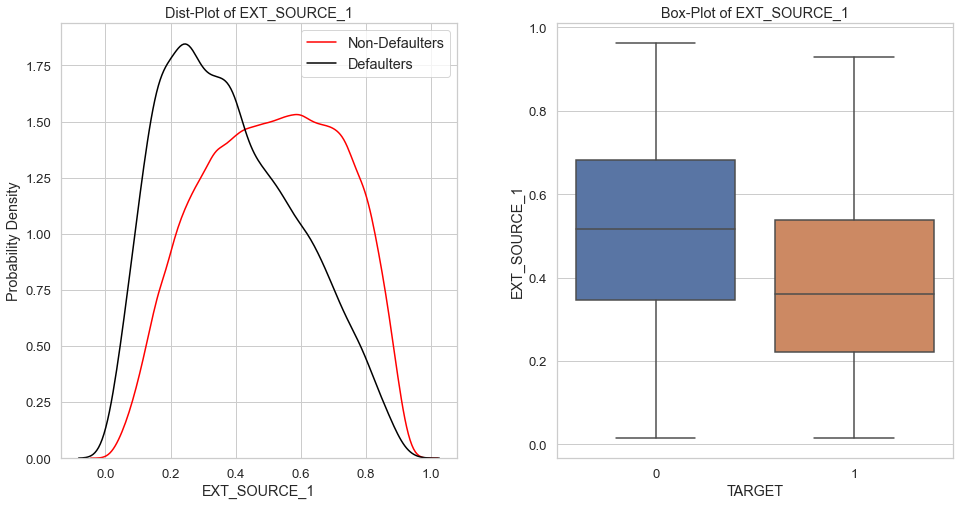

----------------------------------------------------------------------------------------------------


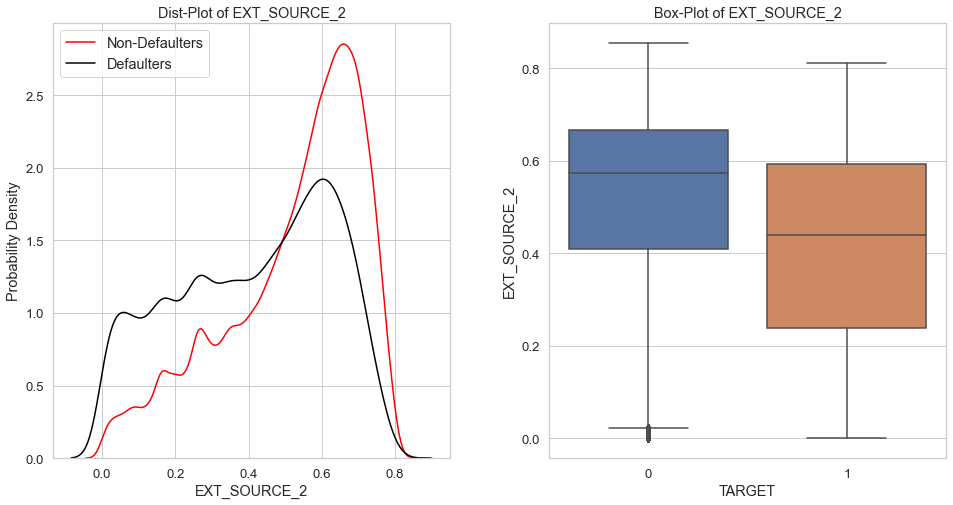

----------------------------------------------------------------------------------------------------


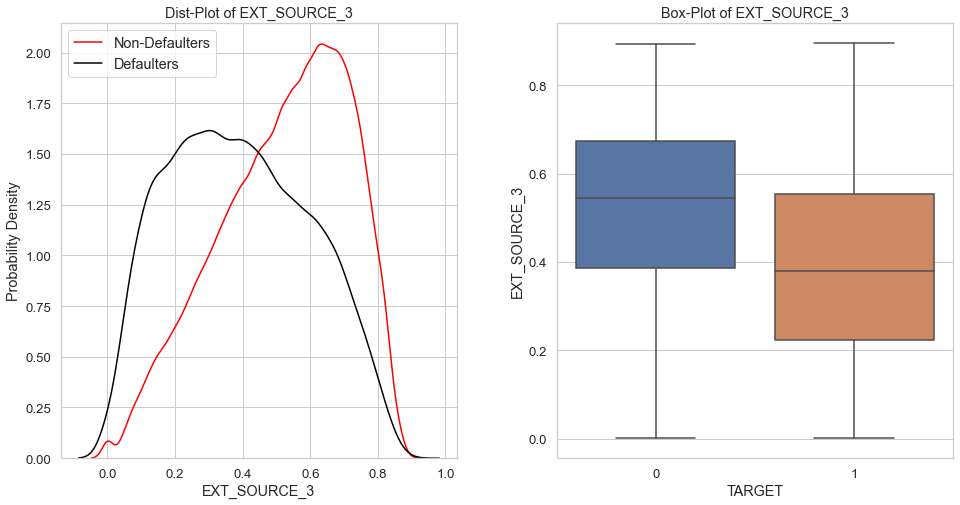

----------------------------------------------------------------------------------------------------


In [39]:
print('-'*100)
plot_continuous_variables(app_train, 'EXT_SOURCE_1', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)
plot_continuous_variables(app_train, 'EXT_SOURCE_2', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)
plot_continuous_variables(app_train, 'EXT_SOURCE_3', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)

## Distribution of FLOORSMAX_AVG and FLOORSMIN_MODE

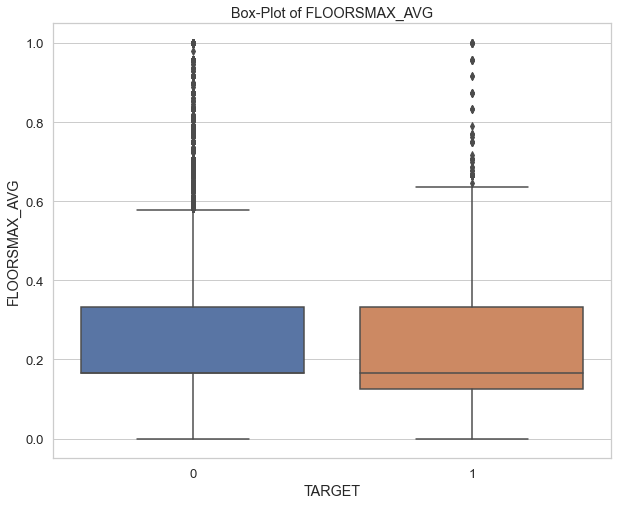

In [40]:
plot_continuous_variables(app_train, 'FLOORSMAX_AVG', plots = ['box'], figsize = (10,8))

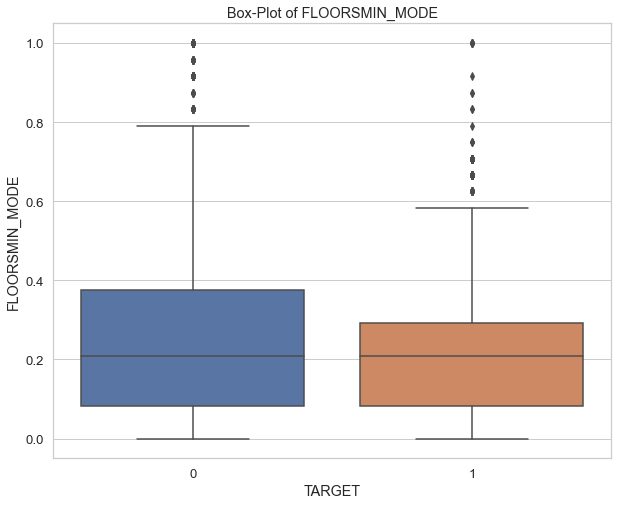

In [41]:
plot_continuous_variables(app_train, 'FLOORSMIN_MODE', plots = ['box'], figsize = (10,8))

### Distribution of AMT_CREDIT

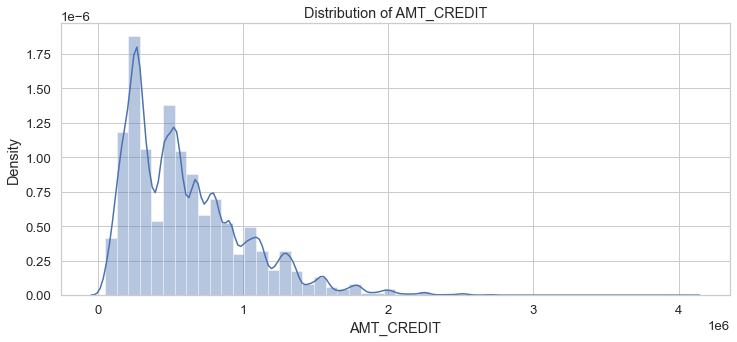

In [42]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(app_train["AMT_CREDIT"])

### Distribution of AMT_INCOME_TOTAL

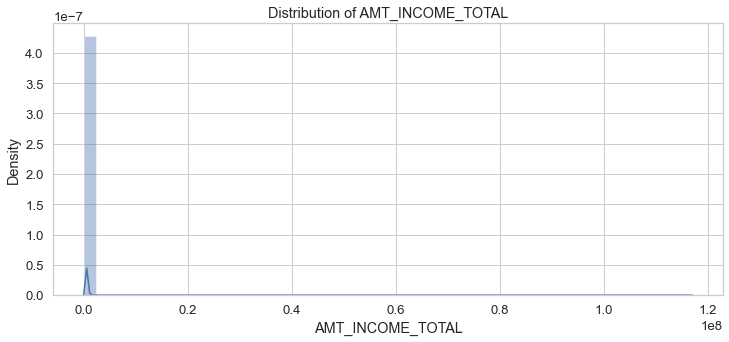

In [43]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_INCOME_TOTAL")
ax = sns.distplot(app_train["AMT_INCOME_TOTAL"].dropna())

### Distribution of  AMT_ANNUITY

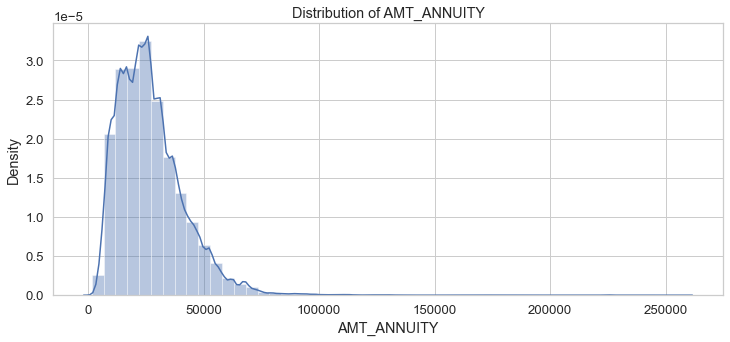

In [44]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_ANNUITY")
ax = sns.distplot(app_train["AMT_ANNUITY"].dropna())

### Distribution of AMT_GOODS_PRICE 

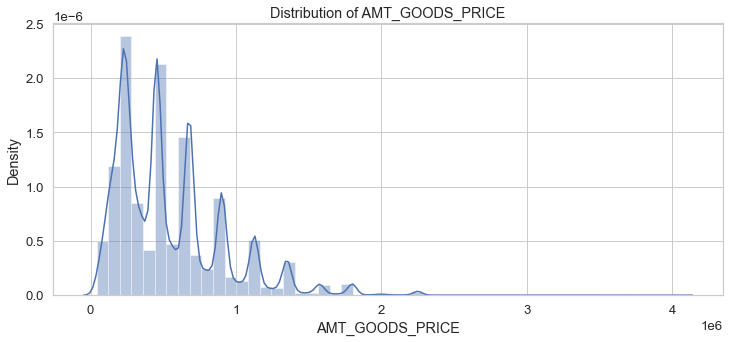

In [45]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_GOODS_PRICE")
ax = sns.distplot(app_train["AMT_GOODS_PRICE"].dropna())

### Distribution of REGION_POPULATION_RELATIVE 

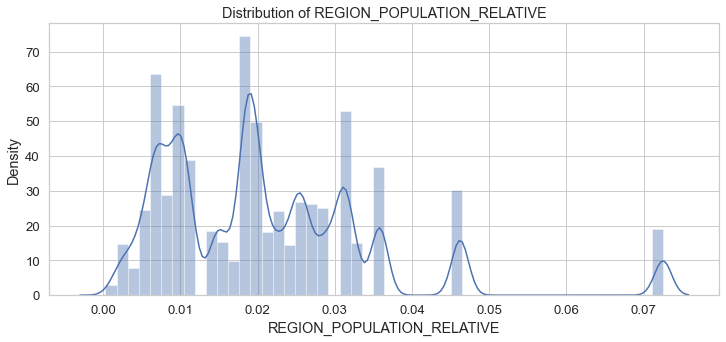

In [46]:
plt.figure(figsize=(12,5))
plt.title("Distribution of REGION_POPULATION_RELATIVE")
ax = sns.distplot(app_train["REGION_POPULATION_RELATIVE"])

### Distribution of DAYS_BIRTH 

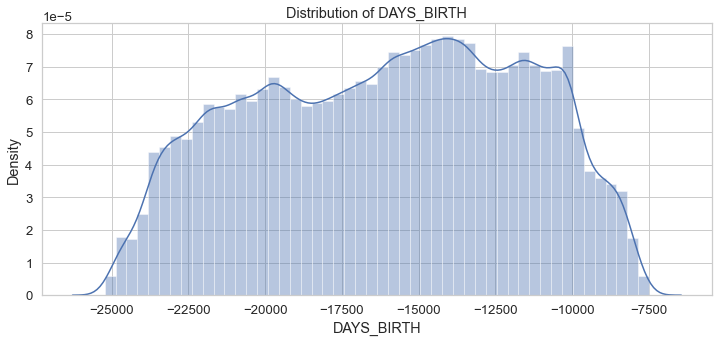

In [47]:
plt.figure(figsize=(12,5))
plt.title("Distribution of DAYS_BIRTH")
ax = sns.distplot(app_train["DAYS_BIRTH"])

### Distribution of DAYS_EMPLOYED 

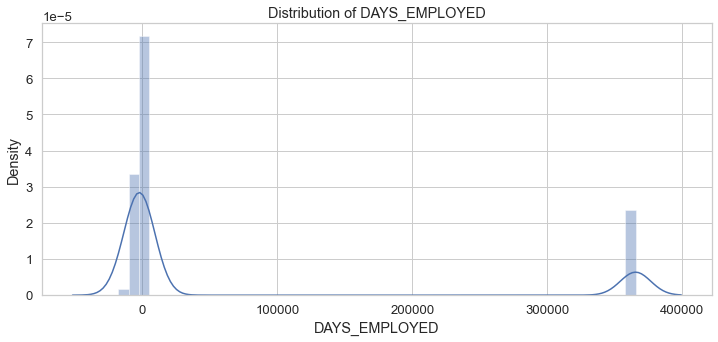

In [48]:
plt.figure(figsize=(12,5))
plt.title("Distribution of DAYS_EMPLOYED")
ax = sns.distplot(app_train["DAYS_EMPLOYED"].dropna())

### Who accompanied client when applying for the application

In [49]:
temp = app_train["NAME_TYPE_SUITE"].value_counts()

trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
)
data = [trace]
layout = go.Layout(
    title = "Who accompanied client when applying for the  application in % ",
    xaxis=dict(
        title='Name of type of the Suite',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of Name of type of the Suite in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

### Type of loan

In [50]:
temp = app_train["NAME_CONTRACT_TYPE"].value_counts()
fig = {
  "data": [
    {
      "values": temp.values,
      "labels": temp.index,
      "domain": {"x": [0, .48]},
      "hole": .7,
      "type": "pie"
    },
    
    ],
  "layout": {
        "title":"Types of loan",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Loan Types",
                "x": 0.17,
                "y": 0.5
            }
            
        ]
    }
}
iplot(fig, filename='donut')

### Income sources of Applicant's in terms of loan is repayed or not in %

In [51]:
temp = app_train["NAME_INCOME_TYPE"].value_counts()

temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train["TARGET"][app_train["NAME_INCOME_TYPE"]==val] == 1))
    temp_y0.append(np.sum(app_train["TARGET"][app_train["NAME_INCOME_TYPE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Income sources of Applicant's in terms of loan is repayed or not  in %",
    width = 1000,
    xaxis=dict(
        title='Income source',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Family Status of Applicant's in terms of loan is repayed or not in %

In [52]:
temp = app_train["NAME_FAMILY_STATUS"].value_counts()

temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train["TARGET"][app_train["NAME_FAMILY_STATUS"]==val] == 1))
    temp_y0.append(np.sum(app_train["TARGET"][app_train["NAME_FAMILY_STATUS"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Family Status of Applicant's in terms of loan is repayed or not in %",
    width = 1000,
    xaxis=dict(
        title='Family Status',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Education of Applicant's in terms of loan is repayed or not in %

In [53]:
temp = app_train["NAME_EDUCATION_TYPE"].value_counts()

temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train["TARGET"][app_train["NAME_EDUCATION_TYPE"]==val] == 1))
    temp_y0.append(np.sum(app_train["TARGET"][app_train["NAME_EDUCATION_TYPE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Education of Applicant's in terms of loan is repayed or not in %",
    width = 1000,
    xaxis=dict(
        title='Education of Applicant\'s',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

### For which types of house higher applicant's applied for loan in terms of loan is repayed or not in %

In [54]:
temp = app_train["NAME_HOUSING_TYPE"].value_counts()

temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train["TARGET"][app_train["NAME_HOUSING_TYPE"]==val] == 1))
    temp_y0.append(np.sum(app_train["TARGET"][app_train["NAME_HOUSING_TYPE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "For which types of house higher applicant's applied for loan in terms of loan is repayed or not in %",
    width = 1000,
    xaxis=dict(
        title='types of house',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Types of Organizations in terms of loan is repayed or not in %

In [55]:
temp = app_train["ORGANIZATION_TYPE"].value_counts()
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train["TARGET"][app_train["ORGANIZATION_TYPE"]==val] == 1))
    temp_y0.append(np.sum(app_train["TARGET"][app_train["ORGANIZATION_TYPE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Types of Organizations in terms of loan is repayed or not in %",
    width = 1000,
    xaxis=dict(
        title='Types of Organizations',
        tickfont=dict(
            size=10,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Defining a UDF to create stacked plots

In [56]:
def bar_hor(df, col, title, color, w=None, h=None, lm=0, limit=100, return_trace=False, rev=False, xlb = False):
    cnt_srs = df[col].value_counts()
    yy = cnt_srs.head(limit).index[::-1] 
    xx = cnt_srs.head(limit).values[::-1] 
    if rev:
        yy = cnt_srs.tail(limit).index[::-1] 
        xx = cnt_srs.tail(limit).values[::-1] 
    if xlb:
        trace = go.Bar(y=xlb, x=xx, orientation = 'h', marker=dict(color=color))
    else:
        trace = go.Bar(y=yy, x=xx, orientation = 'h', marker=dict(color=color))
    if return_trace:
        return trace 
    layout = dict(title=title, margin=dict(l=lm), width=w, height=h)
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

def bar_hor_noagg(x, y, title, color, w=None, h=None, lm=0, limit=100, rt=False):
    trace = go.Bar(y=x, x=y, orientation = 'h', marker=dict(color=color))
    if rt:
        return trace
    layout = dict(title=title, margin=dict(l=lm), width=w, height=h)
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)


def bar_ver_noagg(x, y, title, color, w=None, h=None, lm=0, rt = False):
    trace = go.Bar(y=y, x=x, marker=dict(color=color))
    if rt:
        return trace
    layout = dict(title=title, margin=dict(l=lm), width=w, height=h)
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
def gp(col, title):
    df1 = app_train[app_train["TARGET"] == 1]
    df0 = app_train[app_train["TARGET"] == 0]
    a1 = df1[col].value_counts()
    b1 = df0[col].value_counts()
    
    total = dict(app_train[col].value_counts())
    x0 = a1.index
    x1 = b1.index
    
    y0 = [float(x)*100 / total[x0[i]] for i,x in enumerate(a1.values)]
    y1 = [float(x)*100 / total[x1[i]] for i,x in enumerate(b1.values)]

    trace1 = go.Bar(x=a1.index, y=y0, name='Target : 1', marker=dict(color="#96D38C"))
    trace2 = go.Bar(x=b1.index, y=y1, name='Target : 0', marker=dict(color="#FEBFB3"))
    return trace1, trace2 

### Gender type of applications

In [57]:
tr0 = bar_hor(app_train, "CODE_GENDER", "Distribution of CODE_GENDER Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1, tr2 = gp('CODE_GENDER', 'Distribution of Target with Applicant Gender')

fig = tools.make_subplots(rows=1, cols=3, print_grid=False, subplot_titles = ["Gender Distribution" , "Gender, Target=1" ,"Gender, Target=0"])
fig.append_trace(tr0, 1, 1);
fig.append_trace(tr1, 1, 2);
fig.append_trace(tr2, 1, 3);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=50));
iplot(fig);

C:\Users\Varun\anaconda3\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



### Family status of applicants

In [58]:
tr0 = bar_hor(app_train, "NAME_FAMILY_STATUS", "Distribution of CODE_GENDER Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1, tr2 = gp('NAME_FAMILY_STATUS', 'Distribution of Target with Applicant Gender')

fig = tools.make_subplots(rows=1, cols=3, print_grid=False, subplot_titles = ["Family Status Distribution" , "Family Status, Target = 1" ,"Family Status, Target = 0"])
fig.append_trace(tr0, 1, 1);
fig.append_trace(tr1, 1, 2);
fig.append_trace(tr2, 1, 3);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120));
iplot(fig);

### Check the applicant suite and income type

In [59]:
tr0 = bar_hor(app_train, "NAME_TYPE_SUITE", "Distribution of CODE_GENDER Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1 = bar_hor(app_train, "NAME_INCOME_TYPE", "Distribution of CODE_GENDER Variable" ,"#f975ae", w=700, lm=100, return_trace= True)

fig = tools.make_subplots(rows=1, cols=2, print_grid=False, subplot_titles = ['Applicants Suite Type' , 'Applicants Income Type'])
fig.append_trace(tr0, 1, 1);
fig.append_trace(tr1, 1, 2);
fig['layout'].update(height=400, showlegend=False, margin=dict(l=100));
iplot(fig);

Top 3 Type Suites which applies for loan are the houses which are:
- Unaccompanined (about 248K applicants) 
- Family (about 40K applicants)  
- Spouse, partner (about 11K applicants) 

The income type of people who applies for loan include about 8 categroes, top ones are :
- Working Class (158K)
- Commercial Associate (71K)
- Pensiner (55K)

### How does Target Varies with Suite and Income Type of Applicants?

In [60]:
tr1, tr2 = gp('NAME_TYPE_SUITE', 'Applicants Type Suites which repayed the loan')
fig = tools.make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["Applicants Type Suites distribution when Target = 1", "Applicants Type Suites distribution when Target = 0"])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr2, 1, 2);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120));
iplot(fig);


tr1, tr2 = gp('NAME_INCOME_TYPE', 'Applicants Income Types which repayed the loan')
fig = tools.make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["Applicants Income Types when Target = 1", "Applicants Income Type When Target = 0"])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr2, 1, 2);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120));
iplot(fig);

We see that Applicants having Income Types : Maternity Leaves and UnEmployed has the highest percentage (about 40% and 36% approx) of Target = 1 ie. having more payment problems, while Pensioners have the least (about 5.3%).

### Applicant's Contract Type

In [61]:
t = app_train['NAME_CONTRACT_TYPE'].value_counts()
labels = t.index
values = t.values
trace = go.Pie(labels=labels, values=values)
layout = go.Layout(title='Applicants Contract Type', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

### Does applicants own Real Estate or Car ?

In [62]:
# Real estate 

t = app_train['FLAG_OWN_REALTY'].value_counts()
labels = t.index
values = t.values
trace = go.Pie(labels=labels, values=values)
layout = go.Layout(title='Applicants Owning Real Estate', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


t = app_train['FLAG_OWN_CAR'].value_counts()
labels = t.index
values = t.values
trace = go.Pie(labels=labels, values=values)
layout = go.Layout(title='Applicants Owning Car', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


tr1, tr2 = gp('FLAG_OWN_REALTY', 'Applicants Owning Real Estate wrt Target Variable')
tr3, tr4 = gp('FLAG_OWN_CAR', 'Applicants Owning Car wrt Target Variable')
fig = tools.make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["% Applicants with RealEstate and Target = 1", "% Applicants with Car and Target = 1"])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr3, 1, 2);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120));
iplot(fig);

### Suite Type and Income Type of Applicants 

In [63]:
tr0 = bar_hor(app_train, "NAME_TYPE_SUITE", "Distribution of CODE_GENDER Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1 = bar_hor(app_train, "NAME_INCOME_TYPE", "Distribution of CODE_GENDER Variable" ,"#f975ae", w=700, lm=100, return_trace= True)

fig = tools.make_subplots(rows=1, cols=2, print_grid=False, subplot_titles = ['Applicants Suite Type' , 'Applicants Income Type'])
fig.append_trace(tr0, 1, 1);
fig.append_trace(tr1, 1, 2);
fig['layout'].update(height=400, showlegend=False, margin=dict(l=100));
iplot(fig);

Top 3 Type Suites which applies for loan are the houses which are:

- Unaccompanined (about 248K applicants) 
- Family (about 40K applicants)  
- Spouse, partner (about 11K applicants) 

The income type of people who applies for loan include about 8 categroes, top ones are :

- Working Class (158K)
- Commercial Associate (71K)
- Pensiner (55K)

### How does Target Varies with Suite and Income Type of Applicants 

In [64]:
tr1, tr2 = gp('NAME_TYPE_SUITE', 'Applicants Type Suites which repayed the loan')
fig = tools.make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["Applicants Type Suites distribution when Target = 1", "Applicants Type Suites distribution when Target = 0"])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr2, 1, 2);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120));
iplot(fig);


tr1, tr2 = gp('NAME_INCOME_TYPE', 'Applicants Income Types which repayed the loan')
fig = tools.make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["Applicants Income Types when Target = 1", "Applicants Income Type When Target = 0"])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr2, 1, 2);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120));
iplot(fig);

We see that Applicants having Income Types : Maternity Leaves and UnEmployed has the highest percentage (about 40% and 36% approx) of Target = 1 ie. having more payment problems, while Pensioners have the least (about 5.3%).

### Applicant's Contract Type

In [65]:
t = app_train['NAME_CONTRACT_TYPE'].value_counts()
labels = t.index
values = t.values

trace = go.Pie(labels=labels, values=values)
layout = go.Layout(title='Applicants Contract Type', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Cash loans with about 278K loans contributes to a majorty of total lonas in this dataset. Revolving loans has significantly lesser number equal to about 29K as compared to Cash loans.

### Education Type and Housing Type 

In [66]:
tr1 = bar_hor(app_train, "NAME_EDUCATION_TYPE", "Distribution of " ,"#f975ae", w=700, lm=100, return_trace= True)
tr2 = bar_hor(app_train, "NAME_HOUSING_TYPE", "Distribution of " ,"#f975ae", w=700, lm=100, return_trace = True)

fig = tools.make_subplots(rows=1, cols=2, print_grid=False, subplot_titles = ['Applicants Education Type', 'Applicants Housing Type' ])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr2, 1, 2);
fig['layout'].update(height=400, showlegend=False, margin=dict(l=100));
iplot(fig);


tr1, tr2 = gp('NAME_EDUCATION_TYPE', 'Applicants Income Types which repayed the loan')
tr3, tr4 = gp('NAME_HOUSING_TYPE', 'Applicants Income Types which repayed the loan')
fig = tools.make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["Applicants Education Types, Target=1", "Applicants Housing Type, Target=1"])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr3, 1, 2);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=30));
iplot(fig);

A large number of applications (218K) are filed by people having secondary education followed by people with Higher Education with 75K applications. Applicants living in House / apartments has the highest number of loan apllications equal to 272K. While we see that the applicants with Lower Secondary education status has the highest percentage of payment related problems. Also, Applicants living in apartments or living with parents also shows the same trend.

### Which Organization and Occupation Type applies for loan and which repays

In [67]:
tr1 = bar_hor(app_train, "ORGANIZATION_TYPE", "Distribution of " ,"#f975ae", w=700, lm=100, return_trace= True)
tr2 = bar_hor(app_train, "OCCUPATION_TYPE", "Distribution of " ,"#f975ae", w=700, lm=100, return_trace = True)
fig = tools.make_subplots(rows=1, cols=2, print_grid=False, subplot_titles = ['Applicants Organization Type', 'Applicants Occupation Type' ])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr2, 1, 2);
fig['layout'].update(height=600, showlegend=False, margin=dict(l=150));
iplot(fig);

Top Applicant's who applied for loan : Laborers - Approx 55 K, Sales Staff - Approx 32 K, Core staff - Approx 28 K. Entity Type 3 type organizations have filed maximum number of loans equal to approx 67K

### Target Variable with respect to Organization and Occupation Type 

In [68]:
tr1, tr2 = gp('ORGANIZATION_TYPE', 'Applicants Income Types which repayed the loan')
tr3, tr4 = gp('OCCUPATION_TYPE', 'Applicants Income Types which repayed the loan')
fig = tools.make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["Applicants Organization Types - Repayed", "Applicants Occupation Type - Repayed"])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr3, 1, 2);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120));
iplot(fig);

### Walls Material, Foundation, and House Type 

In [69]:
tr1 = bar_hor(app_train, "FONDKAPREMONT_MODE", "Distribution of FLAG_OWN_REALTY" ,"#639af2", w=700, lm=100, return_trace= True)
tr2 = bar_hor(app_train, "WALLSMATERIAL_MODE", "Distribution of FLAG_OWN_CAR" ,"#a4c5f9", w=700, lm=100, return_trace = True)
tr1 = bar_hor(app_train, "HOUSETYPE_MODE", "Distribution of FLAG_OWN_CAR" ,"#a4c5f9", w=700, lm=100, return_trace = True)

fig = tools.make_subplots(rows=1, cols=2, print_grid=False, subplot_titles = [ 'House Type', 'Walls Material'])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr2, 1, 2);

fig['layout'].update(height=400, showlegend=False, margin=dict(l=100));
iplot(fig);

"Blocks and Flats" related house types have filed the largest number of loan applications equal to about 150K, rest of the other categories : Specific Housing and Terraced house have less than 1500 applications. Similarly houses having Panel and Stone Brick type walls material have filed the largest applciations close to 120K combined.

### Target Variable with respect to Walls Material, Fondkappremont, House Type 

In [70]:
tr1, tr2 = gp('HOUSETYPE_MODE', 'Applicants Income Types which repayed the loan')
tr3, tr4 = gp('WALLSMATERIAL_MODE', 'Applicants Income Types which repayed the loan')
fig = tools.make_subplots(rows=1, cols=2, print_grid=False, subplot_titles = ["HouseTypes - Repayed", "WallsMaterial - Repayed"])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr3, 1, 2);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120));
iplot(fig);

### Contract Status Distribution in Previously Filed Applications

In [71]:
t = previous_application['NAME_CONTRACT_STATUS'].value_counts()
labels = t.index
values = t.values

trace = go.Pie(labels=labels, values=values)

layout = go.Layout(title='Name Contract Status in Previous Applications', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

### Suite Type Distribution of Previous Applications

In [72]:
t = previous_application['NAME_TYPE_SUITE'].value_counts()
labels = t.index
values = t.values

trace = go.Pie(labels=labels, values=values)

layout = go.Layout(title='Suite Type in Previous Application Distribution', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

### Client Type of Previous Applications

In [73]:
t = previous_application['NAME_CLIENT_TYPE'].value_counts()
labels = t.index
values = t.values

trace = go.Pie(labels=labels, values=values)

layout = go.Layout(title='Client Type in Previous Applications', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

### Channel Type - Previous Applications 

In [74]:
t = previous_application['CHANNEL_TYPE'].value_counts()
labels = t.index
values = t.values

trace = go.Pie(labels=labels, values=values)

layout = go.Layout(title='Channel Type in Previous Applications', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

### Contract product type of previous application

In [75]:
t = previous_application['NAME_CONTRACT_TYPE'].value_counts()
labels = t.index
values = t.values

trace = go.Pie(labels=labels, values=values)

layout = go.Layout(title='Name Contract Type in Previous Applications', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

### Effect of Age on Repayment

In [76]:
# Find the correlation of the positive days since birth and target

app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

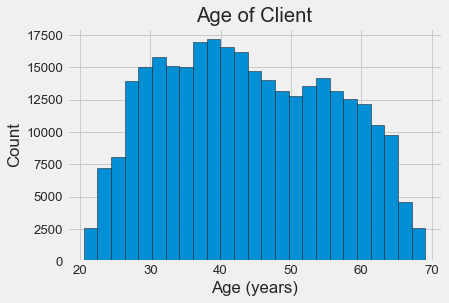

In [77]:
# Set the style of plots

plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years

plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. A kernel density estimate plot shows the distribution of a single variable and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn kdeplot for this graph.

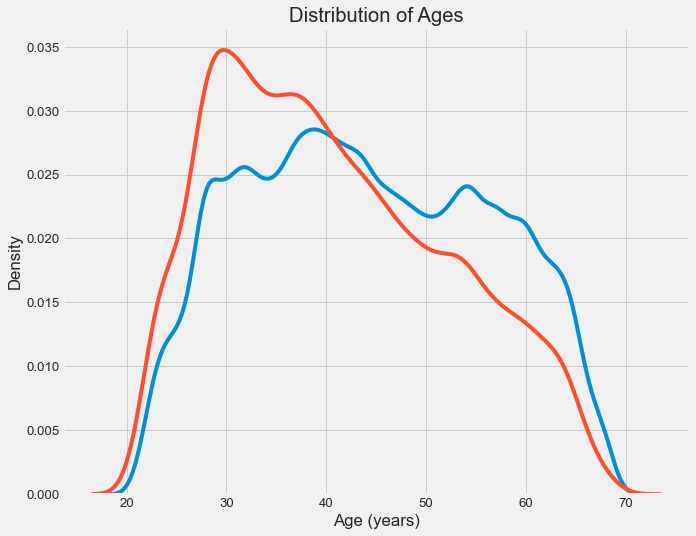

In [78]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time

sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time

sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot

plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [79]:
# Age information into a separate dataframe

age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data

age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [80]:
# Group by the bin and calculate averages

age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

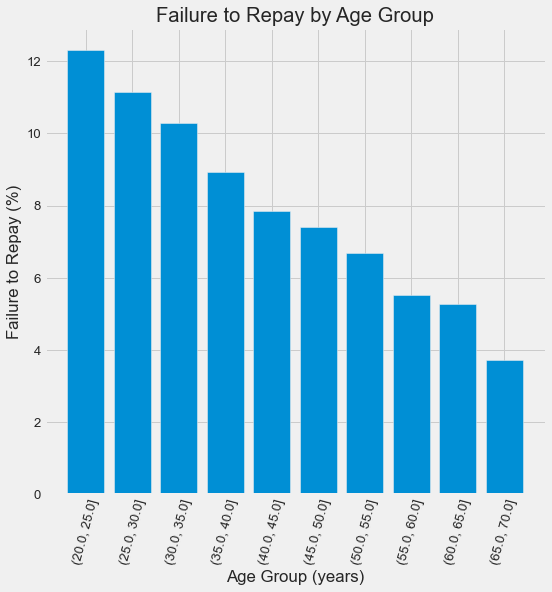

In [81]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot

plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling

plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

## Exterior Sources
The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data.

Let's take a look at these variables.

First, we can show the correlations of the EXT_SOURCE features with the target and with each other.

In [82]:
# Extract the EXT_SOURCE variables and show correlations

ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

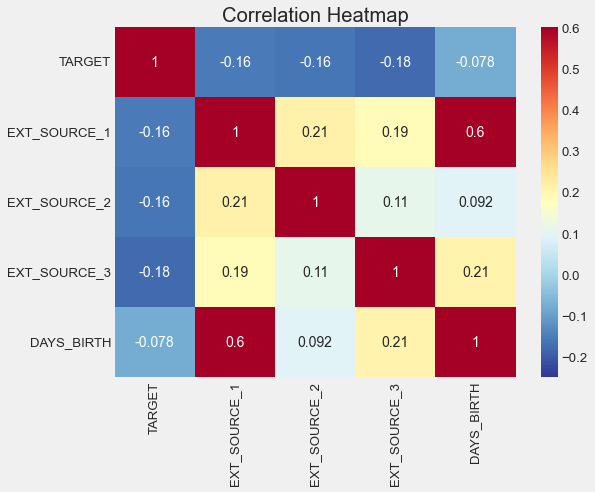

In [83]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations

sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three EXT_SOURCE features have negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

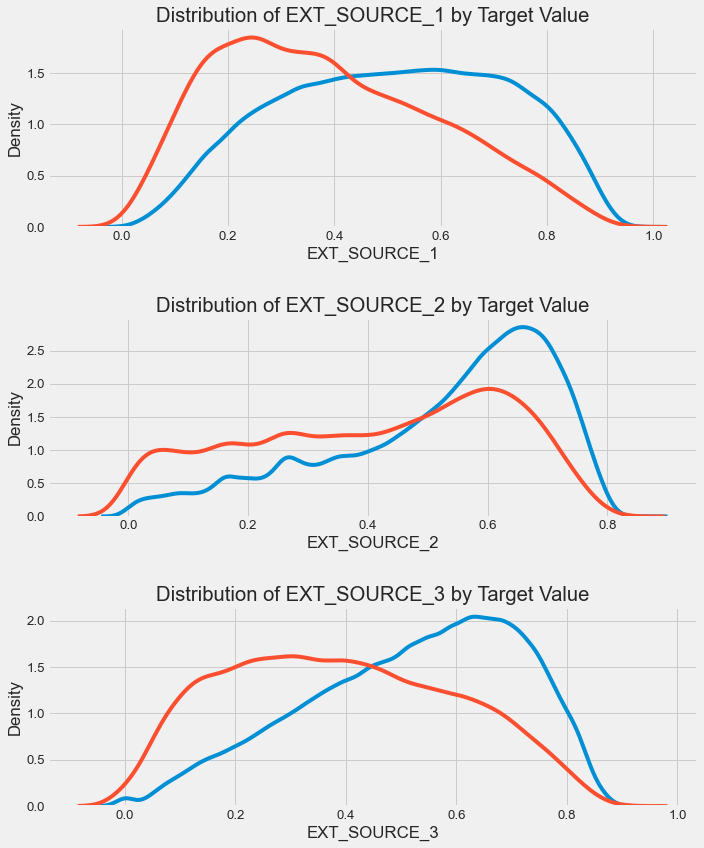

In [84]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong. In fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

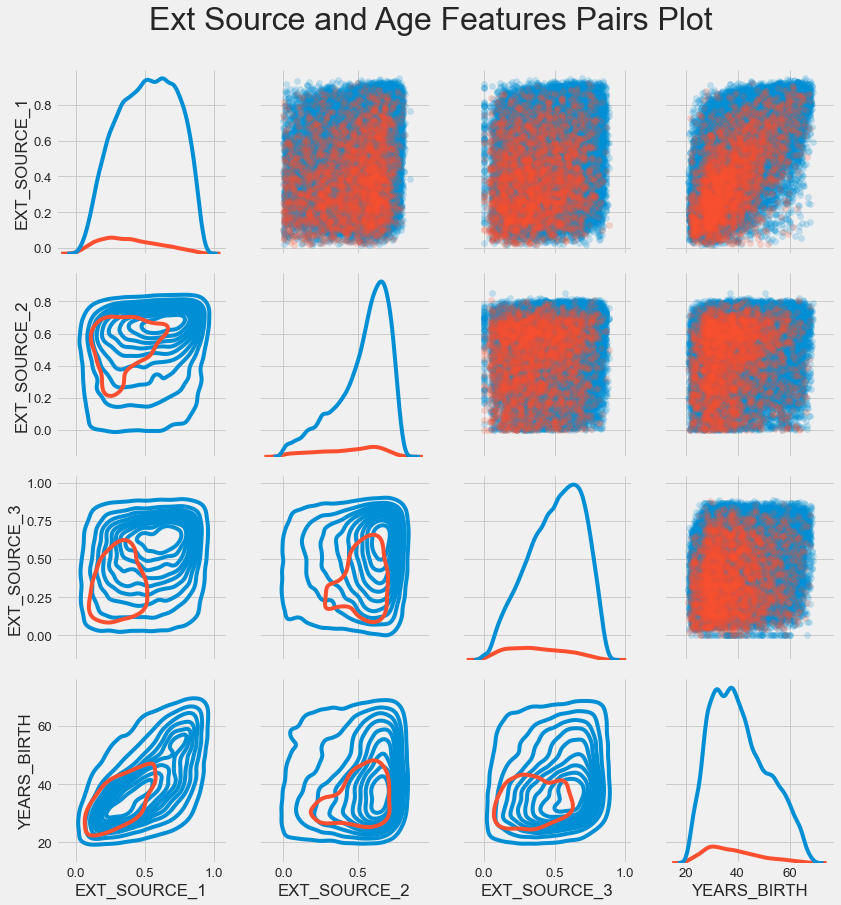

In [85]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

## EDA for Bureau data
Bureau data contains all client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in the sample). For every loan in the sample, there are as many rows as number of credits the client had in Credit Bureau before the application date. SK_ID_CURR is the key connecting application_train|test data with bureau data.

Let's merge application_train with bureau.

In [86]:
app_bureau_train = app_train.merge(bureau_data, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

print("The resulting dataframe `application_bureau_train` has ",app_bureau_train.shape[0]," rows and ", 
      app_bureau_train.shape[1]," columns.")

The resulting dataframe `application_bureau_train` has  1465325  rows and  138  columns.


In [87]:
def plot_b_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = app_bureau_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = app_bureau_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

## NaN Columns and Percentages

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 7 columns


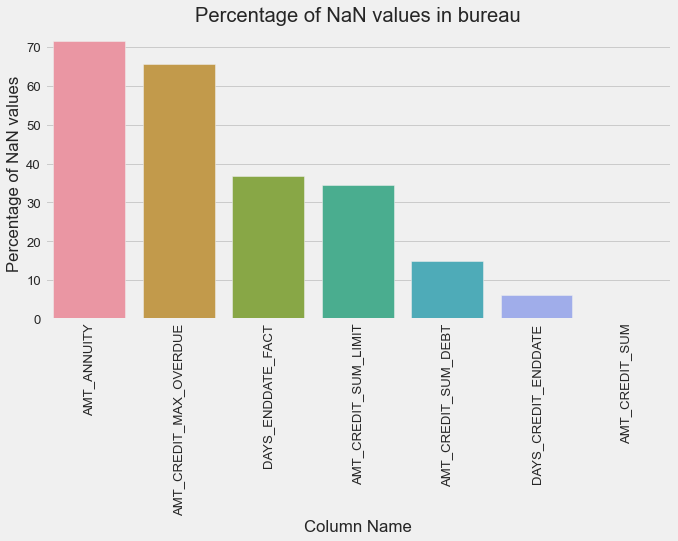

----------------------------------------------------------------------------------------------------


In [88]:
nan_df_bureau = nan_df_create(bureau_data)
print("-"*100)
plot_nan_percent(nan_df_bureau, 'bureau', tight_layout = False, figsize = (10,5))
print('-'*100)

In [89]:
# Merging the TARGETS from application_train to bureau table.

print("-"*100)
print("Merging TARGET with bureau Table")
bureau_merged = app_train.iloc[:,:2].merge(bureau_data, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with bureau Table
----------------------------------------------------------------------------------------------------


## Phi-K Matrix

----------------------------------------------------------------------------------------------------


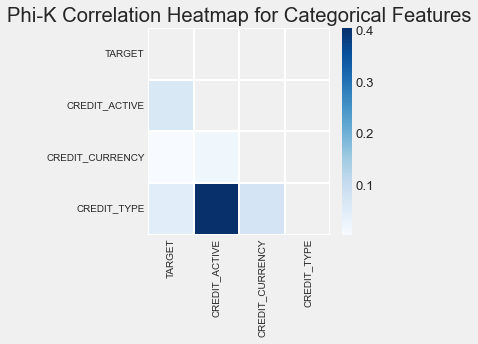

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


Column Name  Phik-Correlation
0    CREDIT_ACTIVE          0.064481
2      CREDIT_TYPE          0.049954
1  CREDIT_CURRENCY          0.004993

----------------------------------------------------------------------------------------------------


In [90]:
cols_for_phik = ['TARGET','CREDIT_ACTIVE','CREDIT_CURRENCY','CREDIT_TYPE']
plot_phik_matrix(bureau_merged, cols_for_phik,  figsize = (5,5))

## Correlation Matrix of Features

----------------------------------------------------------------------------------------------------


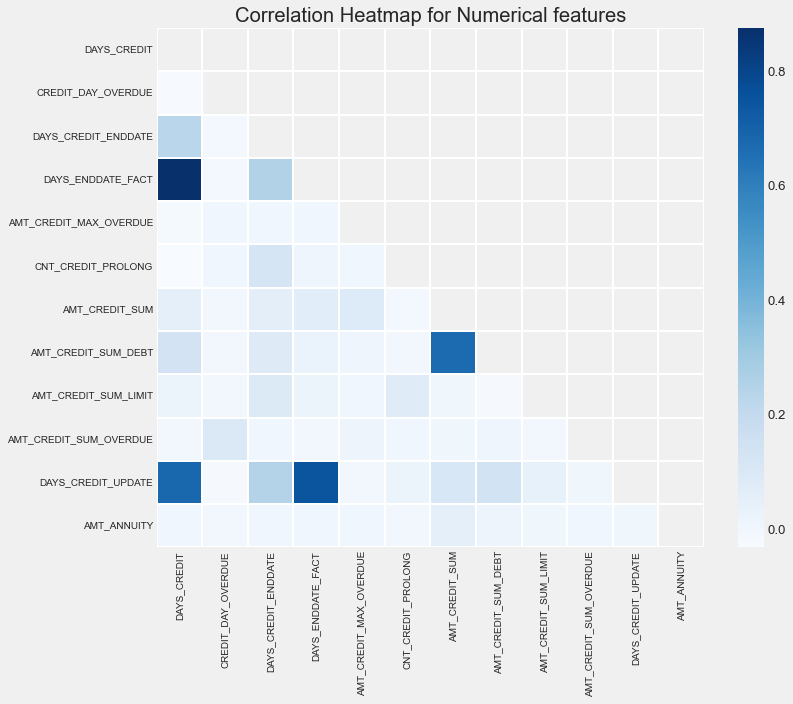

----------------------------------------------------------------------------------------------------


In [91]:
corr_mat = correlation_matrix(bureau_merged, ['SK_ID_CURR','SK_ID_BUREAU'], cmap = 'Blues', figsize = (12,10))
corr_mat.plot_correlation_matrix()

# Plotting Categorical Variables

## Distribution of Categorical Variable CREDIT_ACTIVE

----------------------------------------------------------------------------------------------------
The unique categories of 'CREDIT_ACTIVE' are:
['Closed' 'Active' nan 'Sold' 'Bad debt']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Closed      917733
Active      541919
Sold          5653
Bad debt        20
Name: CREDIT_ACTIVE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CREDIT_ACTIVE = 5


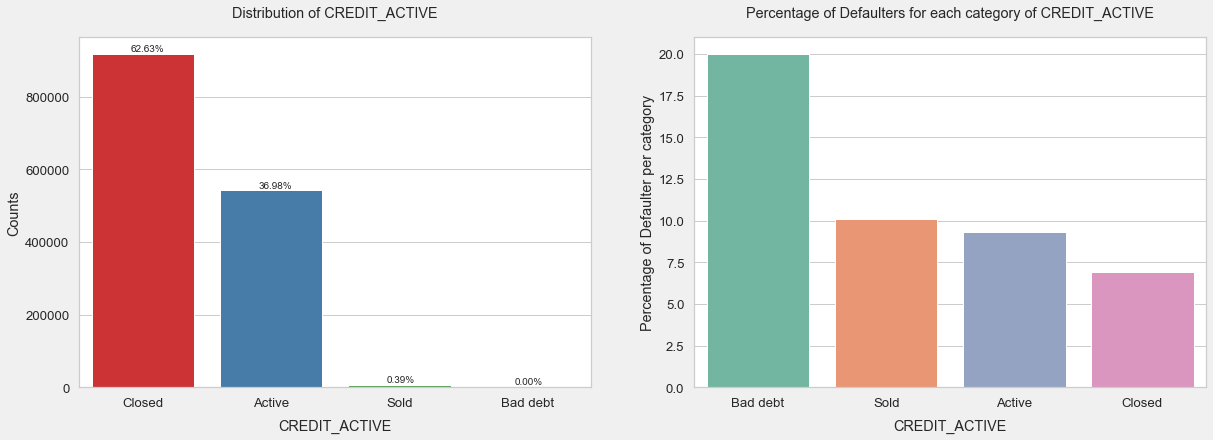

----------------------------------------------------------------------------------------------------


In [92]:
#let us first see the unique categories of 'CREDIT_ACTIVE'
print_unique_categories(bureau_merged, 'CREDIT_ACTIVE', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(bureau_merged, column_name = 'CREDIT_ACTIVE', horizontal_adjust = 0.3, fontsize_percent = 'x-small')
print('-'*100)

# Plotting Continuous Variables

## Distribution of Continuous Variable with DAYS Features

## DAYS_CREDIT

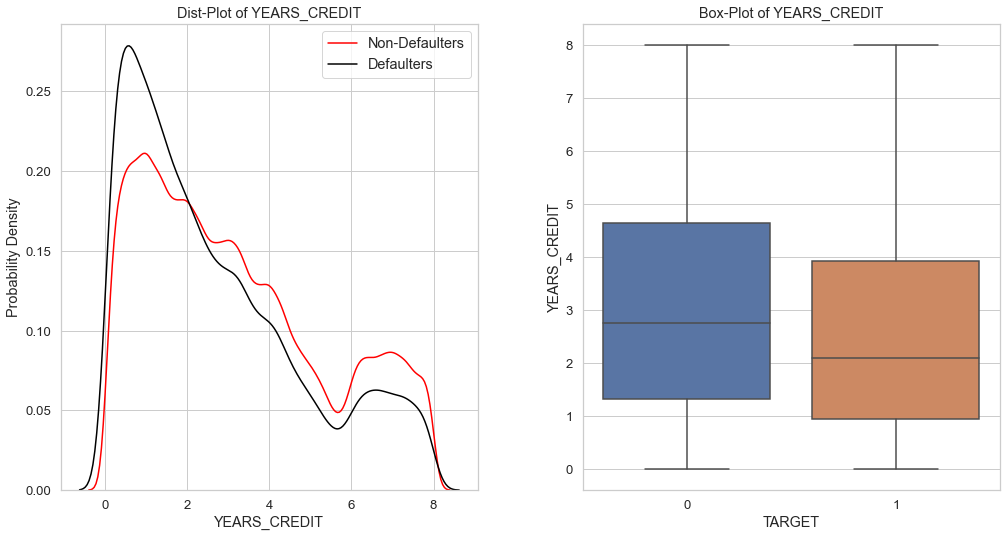

In [93]:
bureau_merged['YEARS_CREDIT'] = bureau_merged['DAYS_CREDIT'] / -365
plot_continuous_variables(bureau_merged, 'YEARS_CREDIT', plots = ['distplot', 'box'], figsize = (15,8))
_ = bureau_merged.pop('YEARS_CREDIT')

## DAYS_CREDIT_ENDDATE

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT_ENDDATE is -42060.0
The 2th percentile value of DAYS_CREDIT_ENDDATE is -2487.0
The 4th percentile value of DAYS_CREDIT_ENDDATE is -2334.0
The 6th percentile value of DAYS_CREDIT_ENDDATE is -2202.0
The 8th percentile value of DAYS_CREDIT_ENDDATE is -2073.9199999999983
The 10th percentile value of DAYS_CREDIT_ENDDATE is -1939.0
The 25th percentile value of DAYS_CREDIT_ENDDATE is -1144.0
The 50th percentile value of DAYS_CREDIT_ENDDATE is -334.0
The 75th percentile value of DAYS_CREDIT_ENDDATE is 473.0
The 100th percentile value of DAYS_CREDIT_ENDDATE is 31199.0
----------------------------------------------------------------------------------------------------


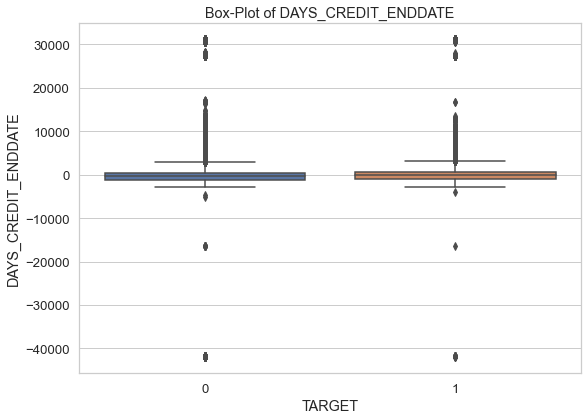

----------------------------------------------------------------------------------------------------


In [94]:
print_percentiles(bureau_merged, 'DAYS_CREDIT_ENDDATE', percentiles = list(range(0,11,2)) + [25,50,75,100])
plot_continuous_variables(bureau_merged, 'DAYS_CREDIT_ENDDATE', plots = ['box'], figsize = (8,6))
print('-'*100)

## DAYS_ENDDATE_FACT

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_ENDDATE_FACT is -42023.0
The 2th percentile value of DAYS_ENDDATE_FACT is -2561.0
The 4th percentile value of DAYS_ENDDATE_FACT is -2450.0
The 6th percentile value of DAYS_ENDDATE_FACT is -2351.0
The 8th percentile value of DAYS_ENDDATE_FACT is -2265.0
The 10th percentile value of DAYS_ENDDATE_FACT is -2173.0
The 25th percentile value of DAYS_ENDDATE_FACT is -1503.0
The 50th percentile value of DAYS_ENDDATE_FACT is -900.0
The 75th percentile value of DAYS_ENDDATE_FACT is -427.0
The 100th percentile value of DAYS_ENDDATE_FACT is 0.0
----------------------------------------------------------------------------------------------------


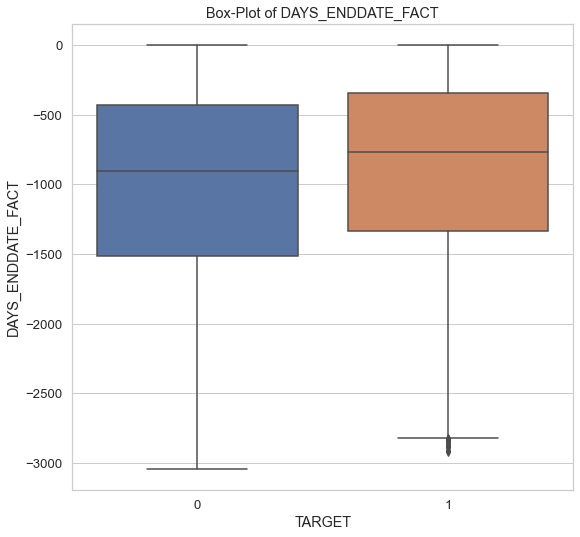

----------------------------------------------------------------------------------------------------


In [95]:
print_percentiles(bureau_merged, 'DAYS_ENDDATE_FACT', percentiles = list(range(0,11,2)) + [25,50,75,100])
plot_continuous_variables(bureau_merged, 'DAYS_ENDDATE_FACT', plots = ['box'], figsize = (8,8), scale_limits = [-40000, 0])
print('-'*100)

## DAYS_CREDIT_UPDATE

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT_UPDATE is -41947.0
The 2th percentile value of DAYS_CREDIT_UPDATE is -2415.0
The 4th percentile value of DAYS_CREDIT_UPDATE is -2213.0
The 6th percentile value of DAYS_CREDIT_UPDATE is -2002.0
The 8th percentile value of DAYS_CREDIT_UPDATE is -1766.0
The 10th percentile value of DAYS_CREDIT_UPDATE is -1582.0
The 25th percentile value of DAYS_CREDIT_UPDATE is -904.0
The 50th percentile value of DAYS_CREDIT_UPDATE is -406.0
The 75th percentile value of DAYS_CREDIT_UPDATE is -33.0
The 100th percentile value of DAYS_CREDIT_UPDATE is 372.0
----------------------------------------------------------------------------------------------------


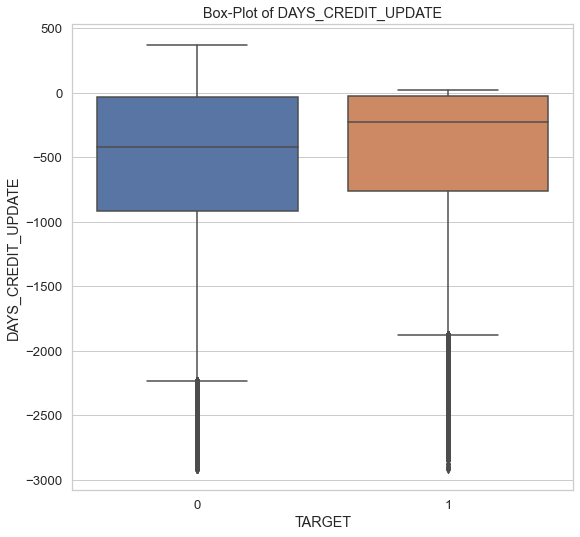

----------------------------------------------------------------------------------------------------


In [96]:
print_percentiles(bureau_merged, 'DAYS_CREDIT_UPDATE', percentiles = list(range(0,11,2)) + [25,50,75,100])
plot_continuous_variables(bureau_merged, 'DAYS_CREDIT_UPDATE', plots = ['box'], figsize = (8,8), scale_limits = [-40000, 400])
print('-'*100)

### Credit status

Let's see the credit status distribution. We show first the number of credits per category (could be Closed, Active, Sold and Bad debt).

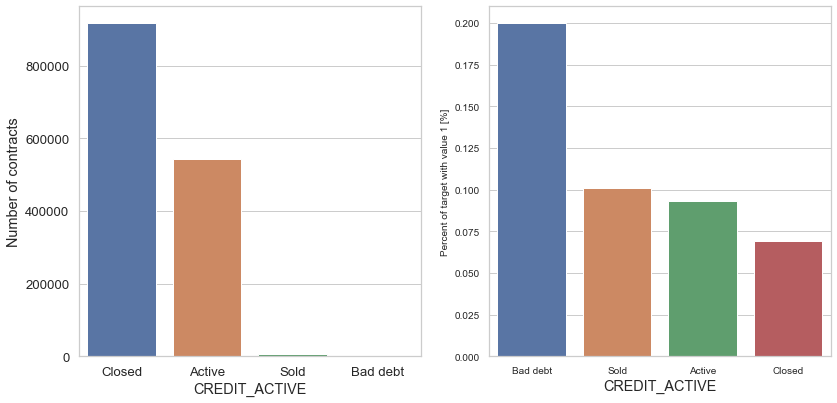

In [97]:
plot_b_stats('CREDIT_ACTIVE')

Most of the credits registered at the Credit Bureau are in the status Closed (~900K). On the second place are the Active credits ( a bit under 600K). Sold and Bad debt are just a few.

In the same time, as percent having TARGET = 1 from total number per category, clients with credits registered to the Credit Bureau with Bad debt have 20% default on the currrent applications.

Clients with credits Sold, Active and Closed have percent of TARGET == 1 (default credit) equal or less than 10% (10% being the rate overall). The smallest rate of default credit have the clients with credits registered at the Credit Bureau with Closed credits.

That means the former registered credit history (as registered at Credit Bureau) is a strong predictor for the dafault credit, since the percent of applications defaulting with a history of Bad debt is twice as large as for Sold or Active and almost three times larger as for Closed

### Credit currency

Let's check now the number of credits registered at the Credit Bureau with different currencies. Also, let's check procent of defaulting credits (for current applications) per different currencies of credits credits registered at the Credit Bureau in the past for the same client.

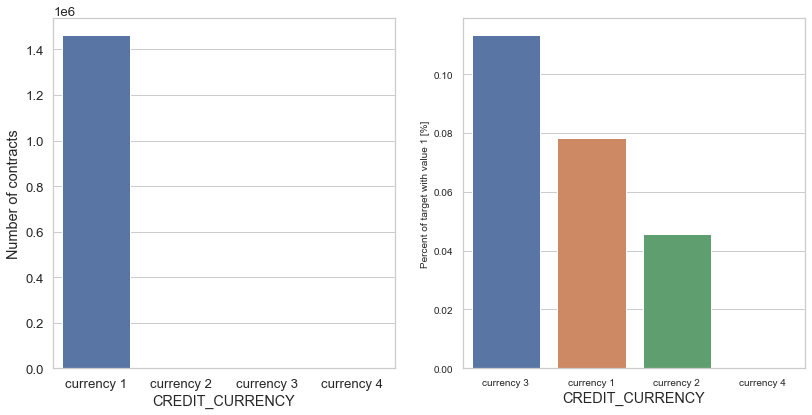

In [98]:
plot_b_stats('CREDIT_CURRENCY')

Credits are mostly in currency_1.

Depending on the currency, the percent of clients defaulting is quite different. Starting with currency_3, then currency_1 and currency_2, the percent of clients defaulting is 11%, 8% and 5%. Percent of defaulting applications for clients that have credits registered with currency_4 is close to 0.

### Credit type

Let's check now the credit types for credits registered at the Credit Bureau.

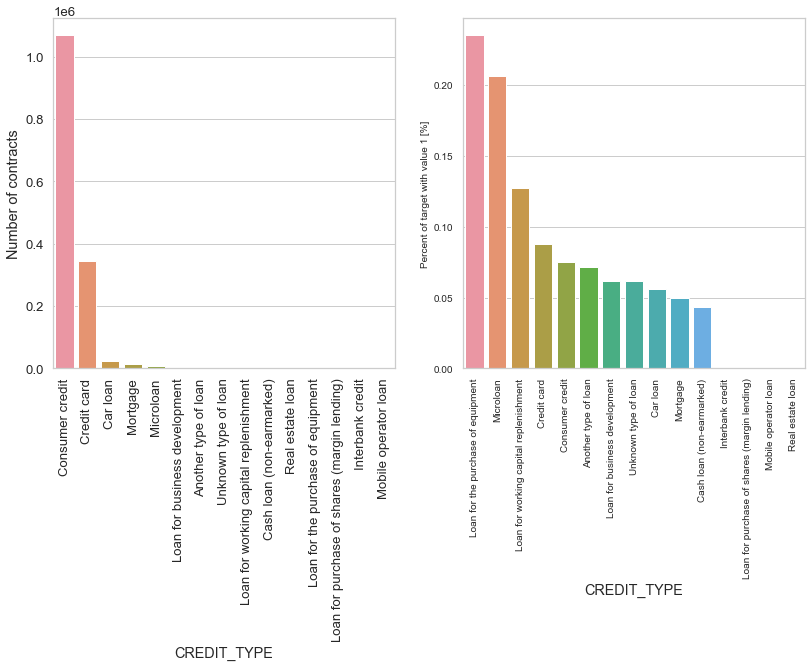

In [99]:
plot_b_stats('CREDIT_TYPE', True, True)

Majority of historical credits registered at the Credit Bureau are Consumer credit and Credit card. Smaller number of credits are Car loan, Mortgage and Microloan.

Looking now to the types of historical credits registered at the Credit Bureau, there are few types with a high percent of current credit defaults, as following:

Loan for the purchase of equipment - with over 20% current credits defaults;
Microloan - with over 20% current credits defaults;
Loan for working capital replenishement - with over 12% current credits defaults.

### Duration of credit (DAYS_CREDIT)

Let's check the distribution of number of days for the credit (registered at the Credit bureau).

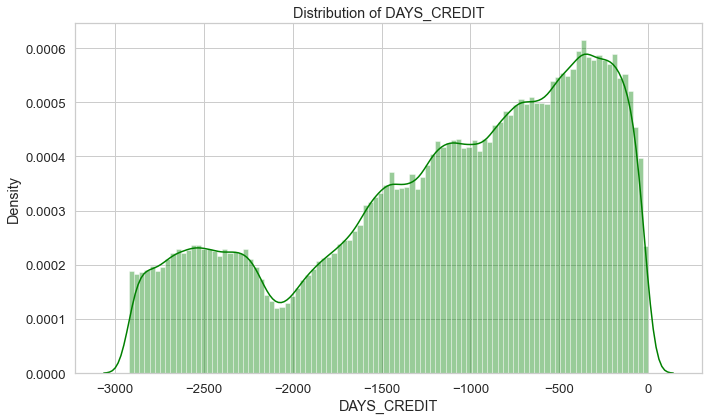

In [100]:
def plot_b_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(app_bureau_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show() 
    
plot_b_distribution('DAYS_CREDIT','green')

The credit duration (in days) is ranging between less than 3000 days (with a local sadle around 2000 days) and with a increasing frequence for shorter number of days - and with a peak around 300 days (or less than one year).

### Credit overdue (CREDIT_DAY_OVERDUE)

Let's check the distribution of number of days for the credit overdue (registered at the Credit bureau).

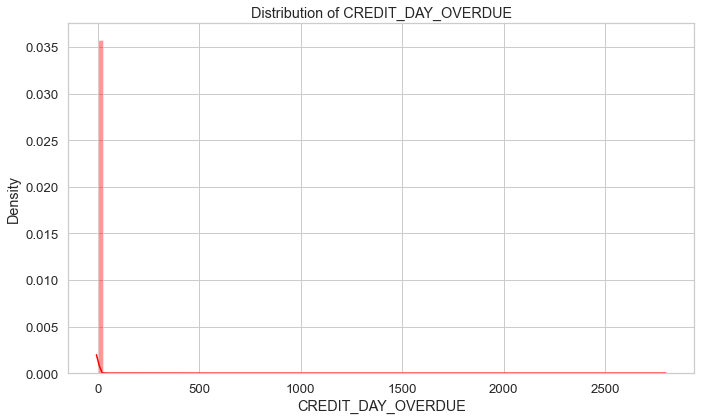

In [101]:
plot_b_distribution('CREDIT_DAY_OVERDUE','red')

Most of the credits have 0 or close to 0 days overdue. The maximum number of credit days overdue is ~3000 days.

### Credit sum (AMT_CREDIT_SUM)

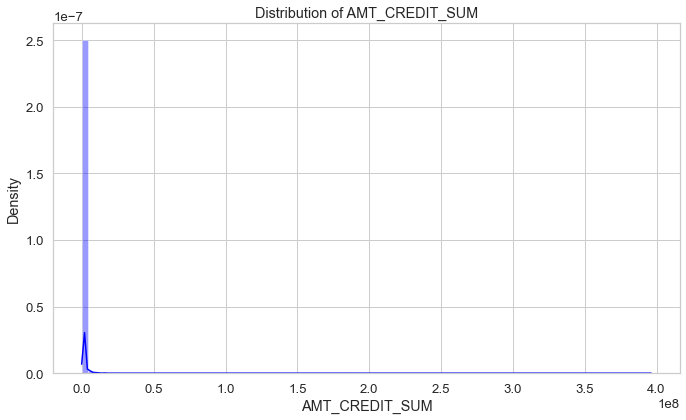

In [102]:
plot_b_distribution('AMT_CREDIT_SUM','blue')

The distribution of the AMT_CREDIT_SUM shows a concentration of the credits for the lower credit sum range.

Let's remove the outliers so that we can see better the distribution around 0.

Let's introduce a function to identify and filter the outliers (with a predefined threshold).

Then, let's also modify the function to display a distribution, this time by using the function to filter the outliers.

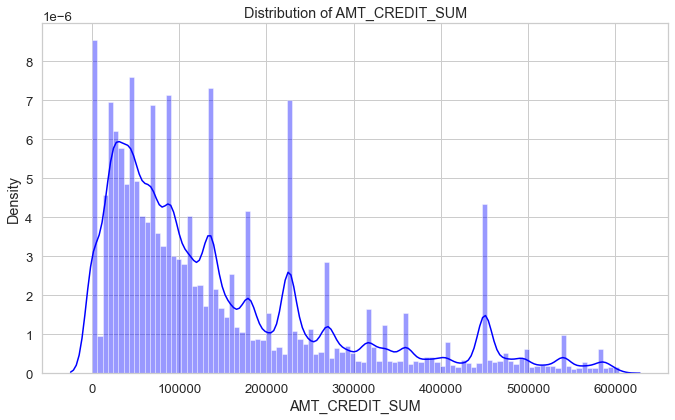

In [103]:
def is_outlier(points, thresh=3.5):

    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def plot_b_o_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    x = app_bureau_train[feature].dropna()
    filtered = x[~is_outlier(x)]
    sns.distplot(filtered,color=color, kde=True,bins=100)
    plt.show() 

plot_b_o_distribution('AMT_CREDIT_SUM','blue')

We can observe that the distribution function shows several peaks and the maximum concentration of the values is around 20,000 but we also see several other peaks at higher values.

### Credit sum limit (AMT_CREDIT_SUM_LIMIT)

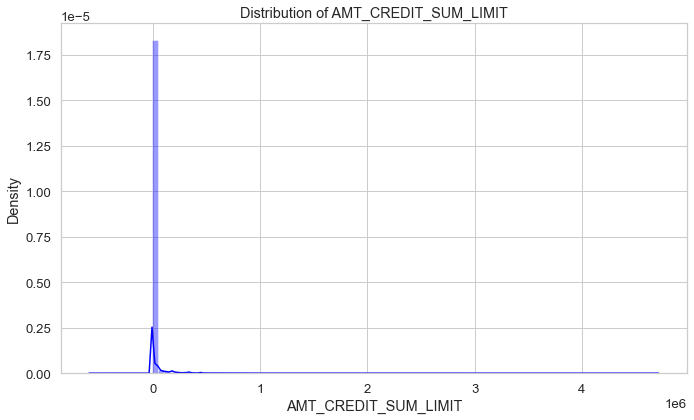

In [104]:
plot_b_distribution('AMT_CREDIT_SUM_LIMIT','blue')

### Comparison of interval values with TARGET = 1 and TARGET = 0

Let's compare the distribution of interval values ploted above for values of TARGET = 1 and TARGET = 0

In [105]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_b_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = app_bureau_train.loc[app_bureau_train['TARGET'] != 0]
    t0 = app_bureau_train.loc[app_bureau_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

<Figure size 432x288 with 0 Axes>

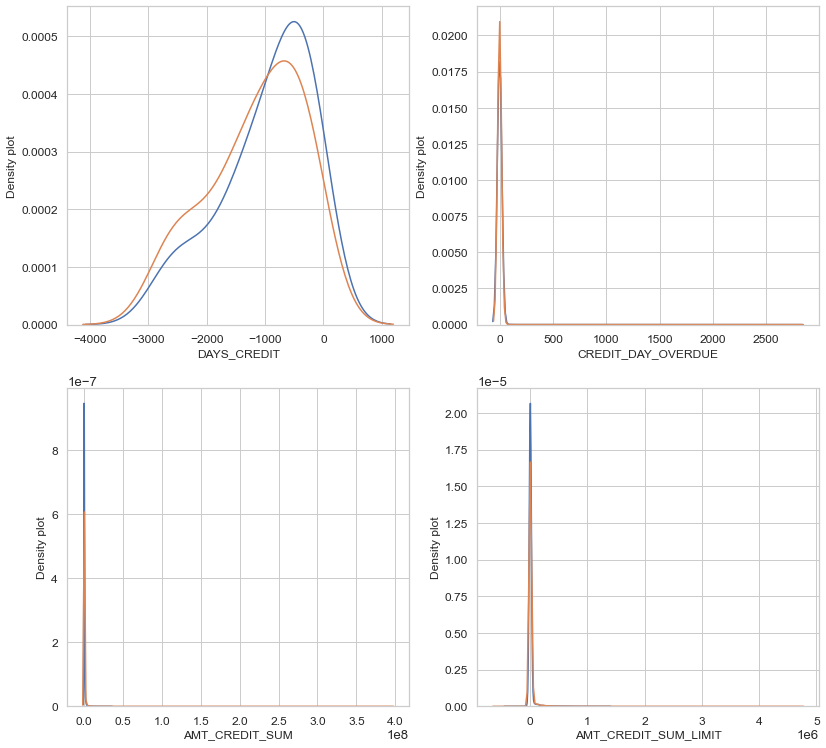

In [106]:
var = ['DAYS_CREDIT','CREDIT_DAY_OVERDUE','AMT_CREDIT_SUM','AMT_CREDIT_SUM_LIMIT']

plot_b_distribution_comp(var, nrow=2)

## EDA for Bureau Balance

## NaN Columns and Percentages

In [107]:
plot_nan_percent(nan_df_create(bureau_balance), 'bureau_balance')

The dataframe bureau_balance does not contain any NaN values.


In [108]:
bureau_status_counter = Counter()
for status in bureau_balance['STATUS'].values:
    bureau_status_counter.update(status.split(','))

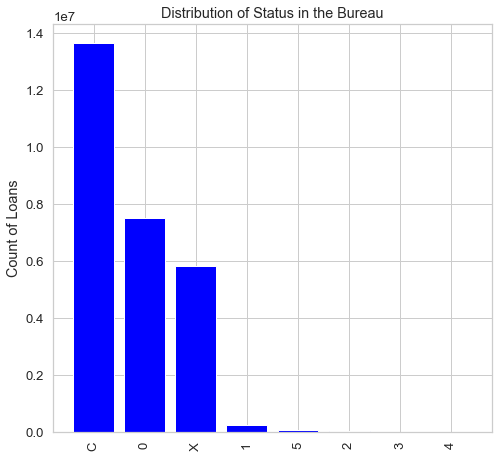

In [109]:
status_dict = dict(bureau_status_counter)
sorted_status_dict = dict(sorted(status_dict.items(), key=lambda kv: kv[1], reverse=True))


ind_3 = np.arange(len(sorted_status_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_3, list(sorted_status_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Status in the Bureau')
plt.xticks(ind_3, list(sorted_status_dict.keys()),rotation=90)
plt.show()

Most of the loans are Closed in the Credit Bureau, which is followed by clients with 0 DPD and then by applicants whose status is unknown.
We can conclude that there are very few annuity defaulters in the data.

In [110]:
# Columns

cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(bureau_data, car_th=10)

Observations: 1716428
Variables: 17
date_cols: 0
cat_cols: 2
num_cols: 14
cat_but_car: 1
num_but_cat: 0


In [111]:
# Numeric Features

bureau_data.drop(["SK_ID_CURR" ,"SK_ID_BUREAU"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
mean -1142.107685            0.818167           510.517362       -1017.437148   
std    795.164928           36.544428          4994.219837         714.010626   
min  -2922.000000            0.000000        -42060.000000      -42023.000000   
1%   -2867.000000            0.000000         -2571.000000       -2639.000000   
10%  -2443.000000            0.000000         -1922.000000       -2159.000000   
25%  -1666.000000            0.000000         -1138.000000       -1489.000000   
50%   -987.000000            0.000000          -330.000000        -897.000000   
75%   -474.000000            0.000000           474.000000        -425.000000   
80%   -385.000000            0.000000           725.000000        -340.000000   
90%   -215.000000            0.000000          1334.000000        -178.000000   
95%   -125.000000            0.000000          2623.000000         -94.000000   
99%    -38.000000            0.000000         31029.000000         -24.000000   
max      0.000000         2792.000000         31199.000000           0.000000   

      AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
mean            3.825418e+03            0.006410    3.549946e+05   
std             2.060316e+05            0.096224    1.149811e+06   
min             0.000000e+00            0.000000    0.000000e+00   
1%              0.000000e+00            0.000000    0.000000e+00   
10%             0.000000e+00            0.000000    2.250000e+04   
25%             0.000000e+00            0.000000    5.130000e+04   
50%             0.000000e+00            0.000000    1.255185e+05   
75%             0.000000e+00            0.000000    3.150000e+05   
80%             4.500000e+01            0.000000    4.230000e+05   
90%             7.594875e+03            0.000000    7.787547e+05   
95%             1.422045e+04            0.000000    1.350000e+06   
99%             4.198875e+04            0.000000    3.700916e+06   
max             1.159872e+08            9.000000    5.850000e+08   

      AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
mean         1.370851e+05          6.229515e+03            3.791276e+01   
std          6.774011e+05          4.503203e+04            5.937650e+03   
min         -4.705600e+06         -5.864061e+05            0.000000e+00   
1%           0.000000e+00          0.000000e+00            0.000000e+00   
10%          0.000000e+00          0.000000e+00            0.000000e+00   
25%          0.000000e+00          0.000000e+00            0.000000e+00   
50%          0.000000e+00          0.000000e+00            0.000000e+00   
75%          4.015350e+04          0.000000e+00            0.000000e+00   
80%          9.000900e+04          0.000000e+00            0.000000e+00   
90%          2.954565e+05          0.000000e+00            0.000000e+00   
95%          6.289024e+05          5.736067e+03            0.000000e+00   
99%          2.259728e+06          1.996206e+05            0.000000e+00   
max          1.701000e+08          4.705600e+06            3.756681e+06   

      DAYS_CREDIT_UPDATE   AMT_ANNUITY  
mean         -593.748320  1.571276e+04  
std           720.747312  3.258269e+05  
min        -41947.000000  0.000000e+00  
1%          -2531.000000  0.000000e+00  
10%         -1561.000000  0.000000e+00  
25%          -908.000000  0.000000e+00  
50%          -395.000000  0.000000e+00  
75%           -33.000000  1.350000e+04  
80%           -25.000000  1.766021e+04  
90%           -13.000000  3.143250e+04  
95%            -8.000000  4.657140e+04  
99%            -3.000000  1.184519e+05  
max           372.000000  1.184534e+08

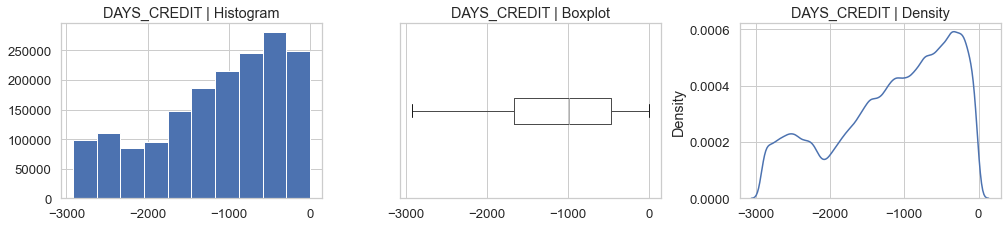

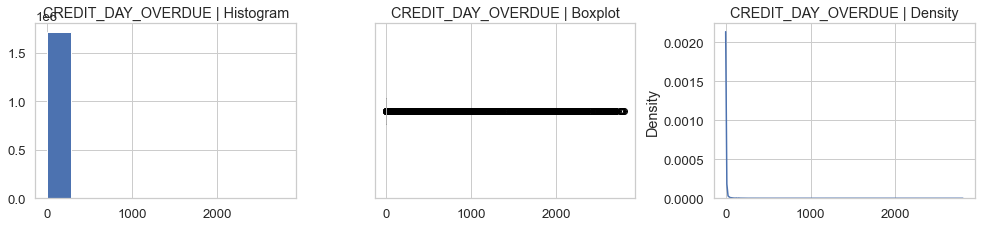

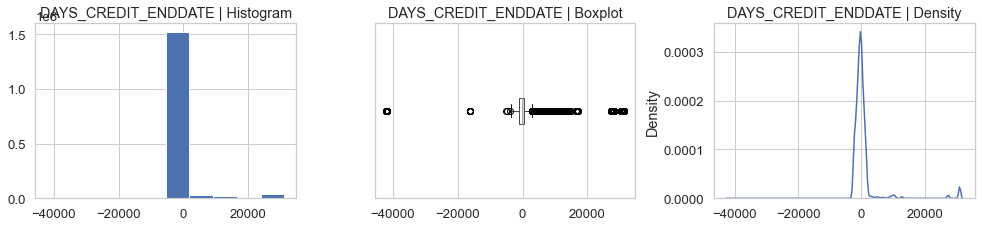

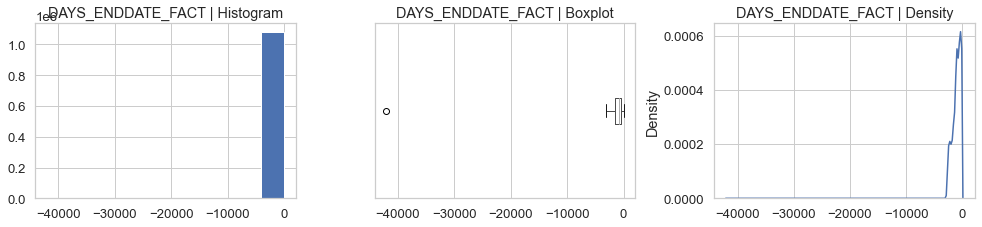

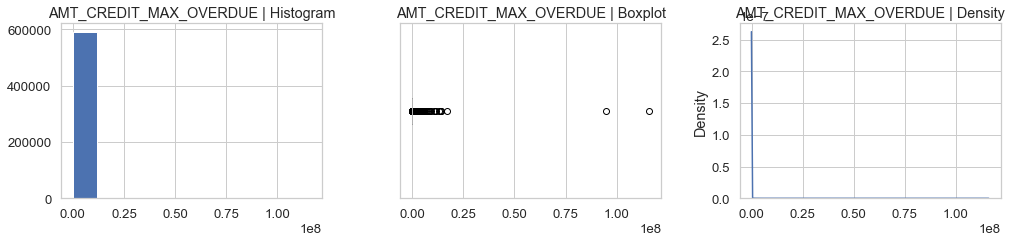

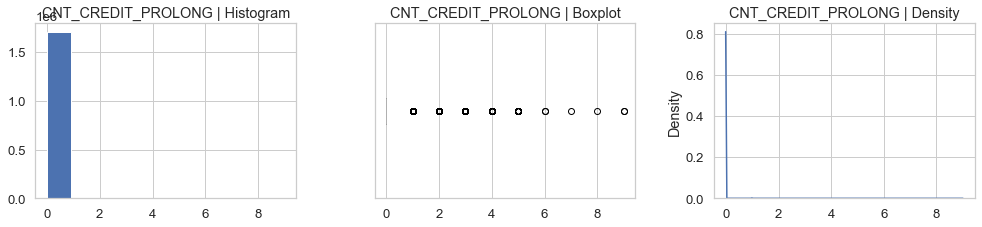

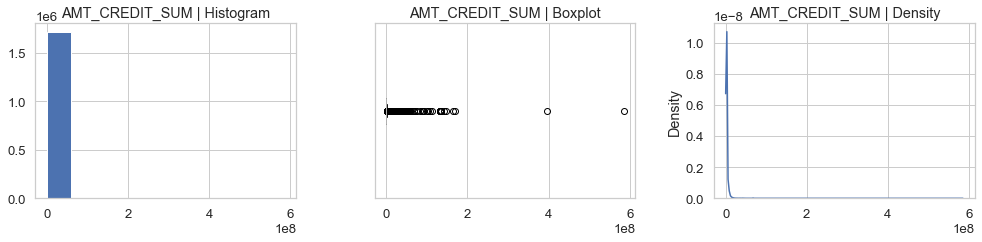

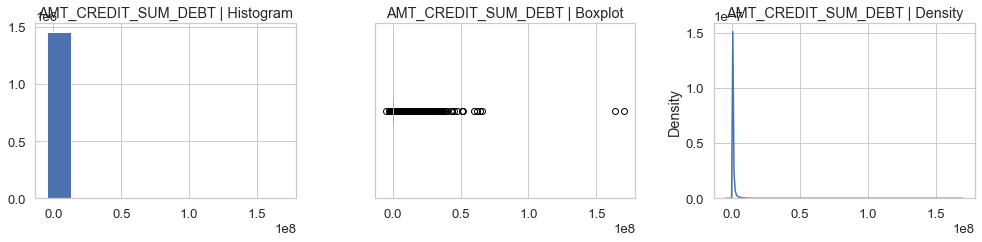

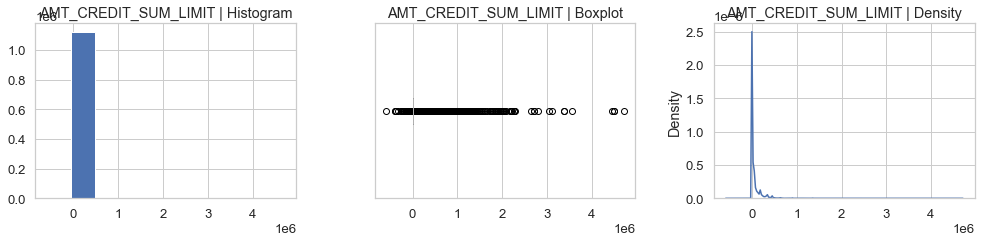

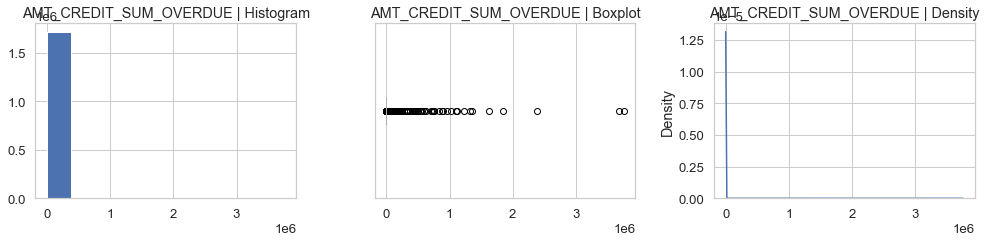

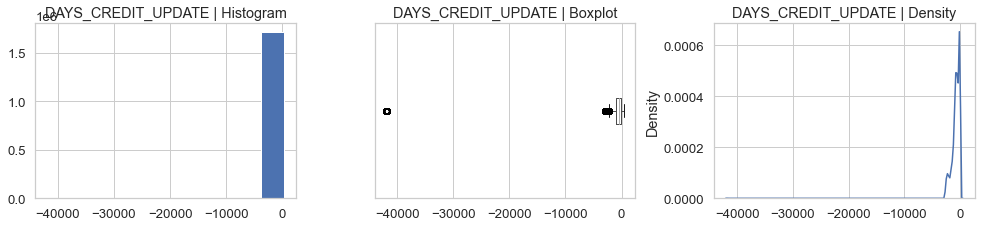

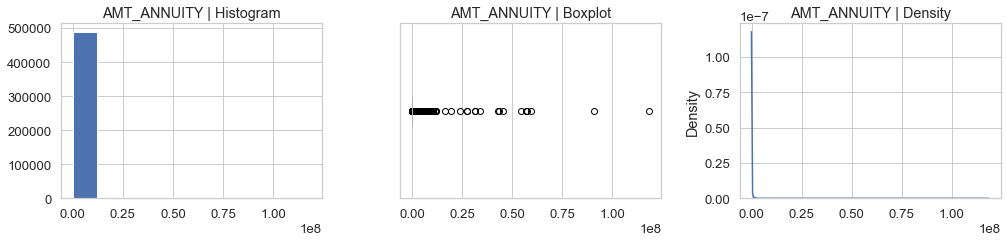

In [112]:
# Quick Visualization for numerical variables

num_plot(bureau_data, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_BUREAU'], figsize = (15,3))

### Previous application data

The dataframe previous_application contains information about all previous applications for Home Credit loans of clients who have loans in the sample. There is one row for each previous application related to loans in our data sample. SK_ID_CURR is the key connecting app_train|test data with previous_application data.

Let's merge app_train with previous_application.

In [113]:
app_prev_train = app_train.merge(previous_application, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

print("The resulting dataframe `app_prev_train` has ",app_prev_train.shape[0]," rows and ", 
      app_prev_train.shape[1]," columns.")

The resulting dataframe `app_prev_train` has  1413701  rows and  158  columns.


In [114]:
def plot_p_stats(feature,label_rotation=False,horizontal_layout=True):
    
    temp = app_prev_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = app_prev_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

### Contract type

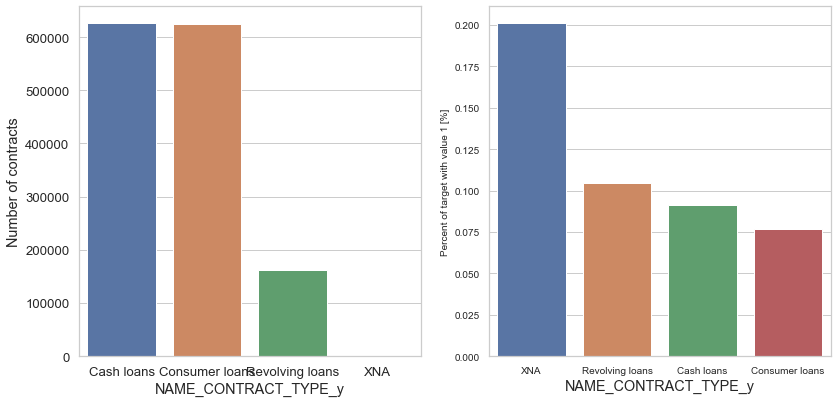

In [115]:
plot_p_stats('NAME_CONTRACT_TYPE_y')

There are three types of contract in the previous application data: Cash loans, Consumer loans, Revolving loans. Cash loans and Consumer loans are almost the same number (~600K) whilst Revolving loans are ~150K.

The percent of defauls loans for clients with previous applications is different for the type of previous applications contracts, decreasing from ~10% for Revolving loans, then ~ 9.5% for Cash loans and ~8% for Consumer loans.

### Cash loan purpose

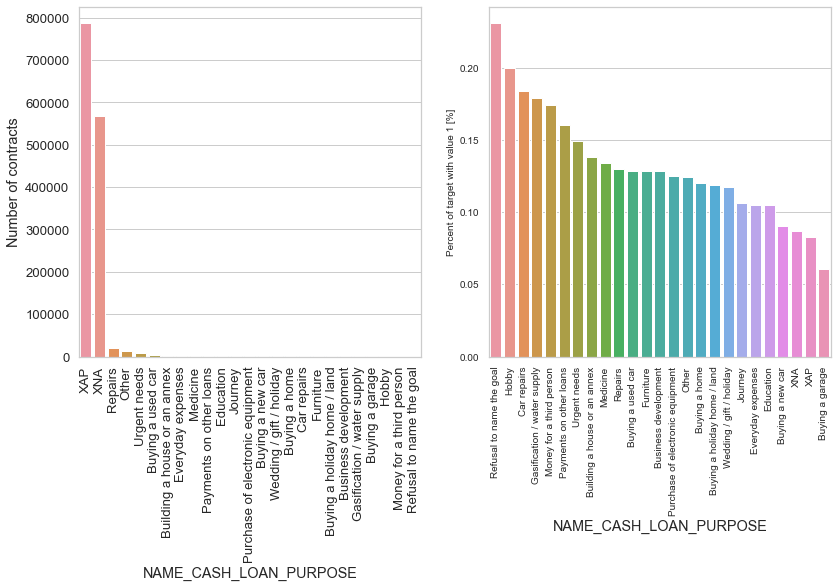

In [116]:
plot_p_stats('NAME_CASH_LOAN_PURPOSE', True, True)

Besides not identifed/not available categories, Repairs, Other, Urgent needs, Buying a used car, Building a house or an annex accounts for the largest number of contracts.

In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history are previous applications for cash loans for Refusal to name the goal - 23% (which makes a lot of sense), Hobby (20%), Car repairs (~18%).

### Contract status

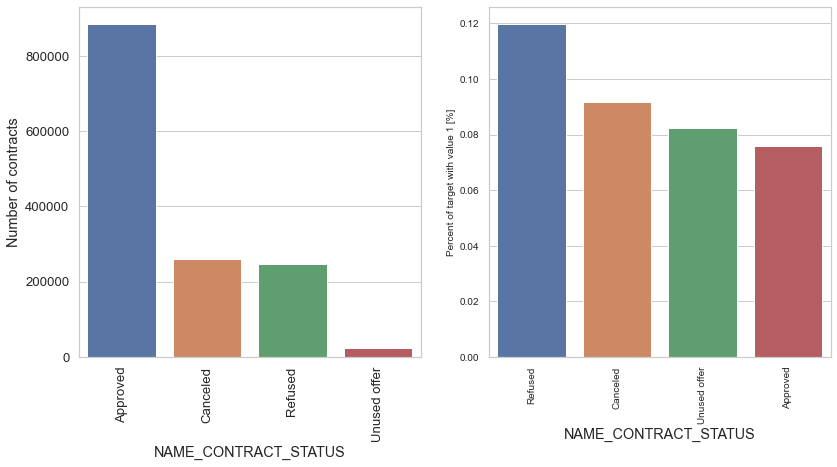

In [117]:
plot_p_stats('NAME_CONTRACT_STATUS', True, True)

Most previous applications contract statuses are Approved (~ 850K), Canceled and Refused (~ 240K). There are only ~20K in status Unused offer.

In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history contract statuses are Refused (12%), followed by Canceled (9%), Unused offer (~8%) and Approved (lowest percent of defaults in current applictions, with less than 8%).

### Payment type

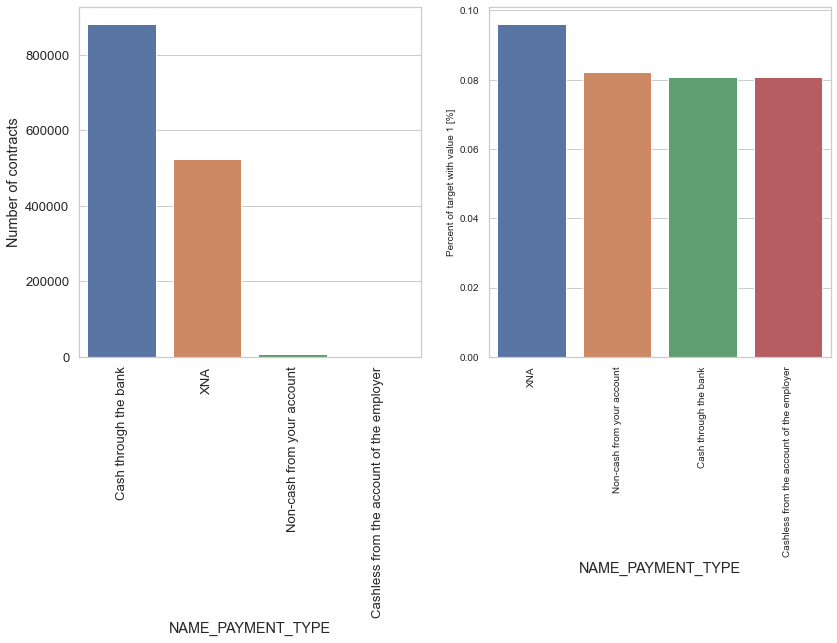

In [118]:
plot_p_stats('NAME_PAYMENT_TYPE', True, True)

Most of the previous applications were paid with Cash through the bank (850K). Payments using Non-cash from your account or Cashless from the account of the employer are much rare. These three types of payments in previous applications results in allmost the same percent of defaults for current clients (~8% each).

### Client type

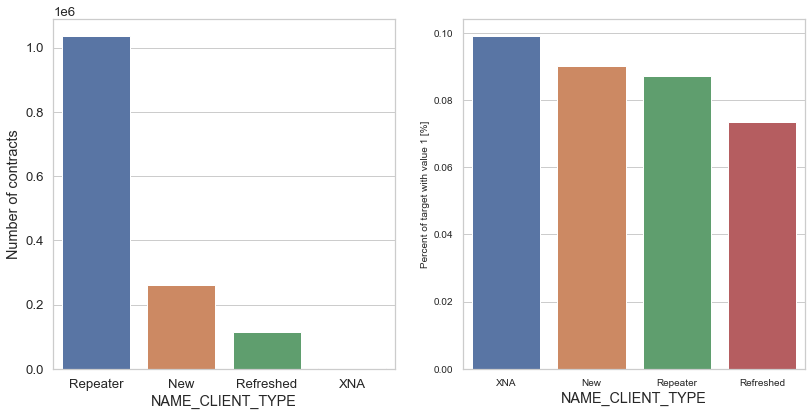

In [119]:
plot_p_stats('NAME_CLIENT_TYPE')

Most of the previous applications have client type Repeater (~1M), just over 200K are New and ~100K are Refreshed.

In terms of default percent for current applications of clients with history of previous applications, current clients with previous applications have values of percent of defaults ranging from from 8.5%, 8.25% and 7% corresponding to client types in the past New, Repeater and Refreshed, respectivelly.

### Code Reject Reason

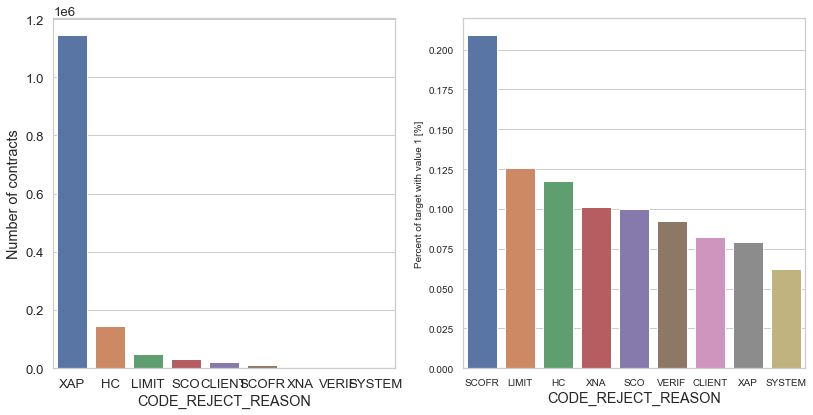

In [120]:
plot_p_stats('CODE_REJECT_REASON')

## EDA for POS CASH Balance

In [121]:
# Merging the TARGETS from application_train to POS_CASH_balance table.

print("-"*100)
print("Merging TARGET with POS_CASH_balance Table")
pos_cash_merged = app_train.iloc[:,:2].merge(pos_cash_balance, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with POS_CASH_balance Table
----------------------------------------------------------------------------------------------------


## Correlation Matrix of Features

----------------------------------------------------------------------------------------------------


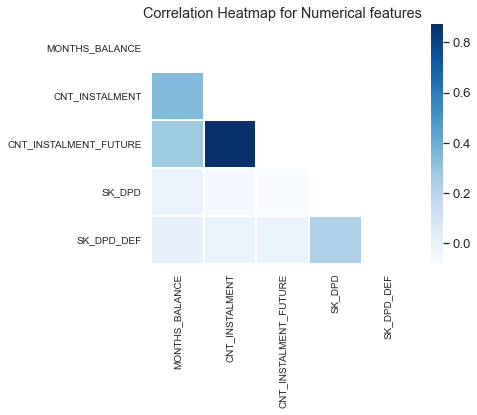

----------------------------------------------------------------------------------------------------


In [122]:
corr_mat = correlation_matrix(pos_cash_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (7,6))
corr_mat.plot_correlation_matrix()

In [123]:
#Seeing the top columns with highest phik-correlation with the target variable in POS_CASH_balance table

top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT_FUTURE']
interval columns not set, guessing: ['TARGET', 'SK_DPD']
interval columns not set, guessing: ['TARGET', 'SK_DPD_DEF']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


Column Name  Phik-Correlation
2  CNT_INSTALMENT_FUTURE          0.033194
1         CNT_INSTALMENT          0.030947
0         MONTHS_BALANCE          0.027391
3                 SK_DPD          0.012773
4             SK_DPD_DEF          0.010539

----------------------------------------------------------------------------------------------------


In [124]:
# Columns

cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(pos_cash_balance, car_th=10)

Observations: 10001358
Variables: 8
date_cols: 0
cat_cols: 1
num_cols: 7
cat_but_car: 0
num_but_cat: 0


In [125]:
# Numeric Features

pos_cash_balance.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

MONTHS_BALANCE  CNT_INSTALMENT  CNT_INSTALMENT_FUTURE       SK_DPD  \
mean      -35.012588       17.089650              10.483840    11.606928   
std        26.066570       11.995056              11.109058   132.714043   
min       -96.000000        1.000000               0.000000     0.000000   
1%        -94.000000        4.000000               0.000000     0.000000   
10%       -77.000000        6.000000               0.000000     0.000000   
25%       -54.000000       10.000000               3.000000     0.000000   
50%       -28.000000       12.000000               7.000000     0.000000   
75%       -13.000000       24.000000              14.000000     0.000000   
80%       -11.000000       24.000000              17.000000     0.000000   
90%        -6.000000       36.000000              24.000000     0.000000   
95%        -4.000000       45.000000              35.000000     0.000000   
99%        -2.000000       60.000000              53.000000   235.000000   
max        -1.000000       92.000000              85.000000  4231.000000   

       SK_DPD_DEF  
mean     0.654468  
std     32.762491  
min      0.000000  
1%       0.000000  
10%      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
80%      0.000000  
90%      0.000000  
95%      0.000000  
99%      1.000000  
max   3595.000000

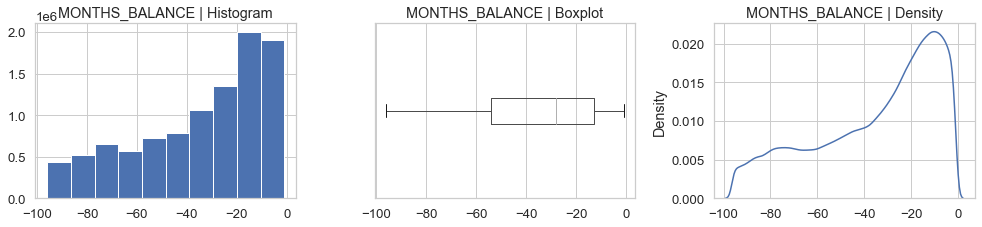

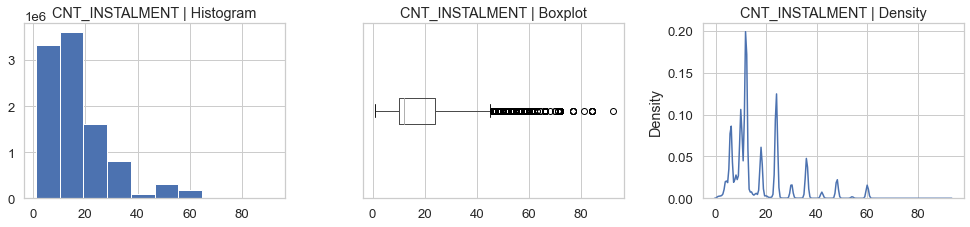

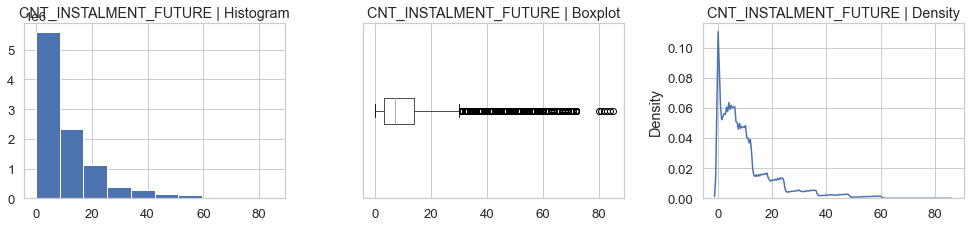

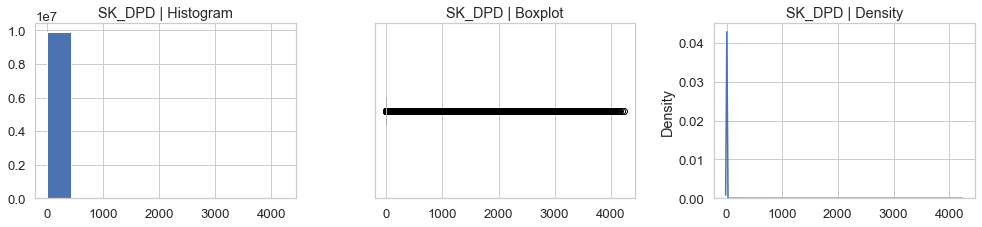

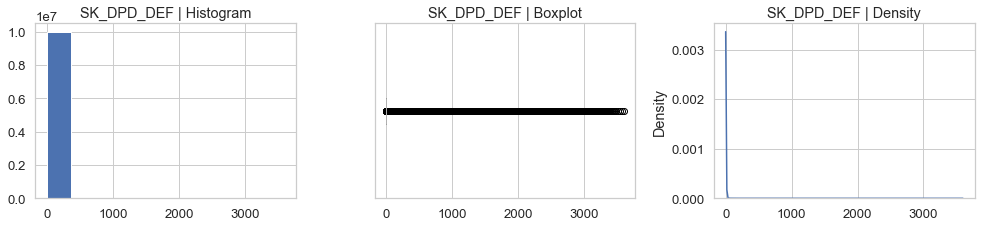

In [126]:
# Quick Visualization for numerical variables

num_plot(pos_cash_balance, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

## EDA for Credit Card Balance

## NaN Columns and Percentages

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 9 columns


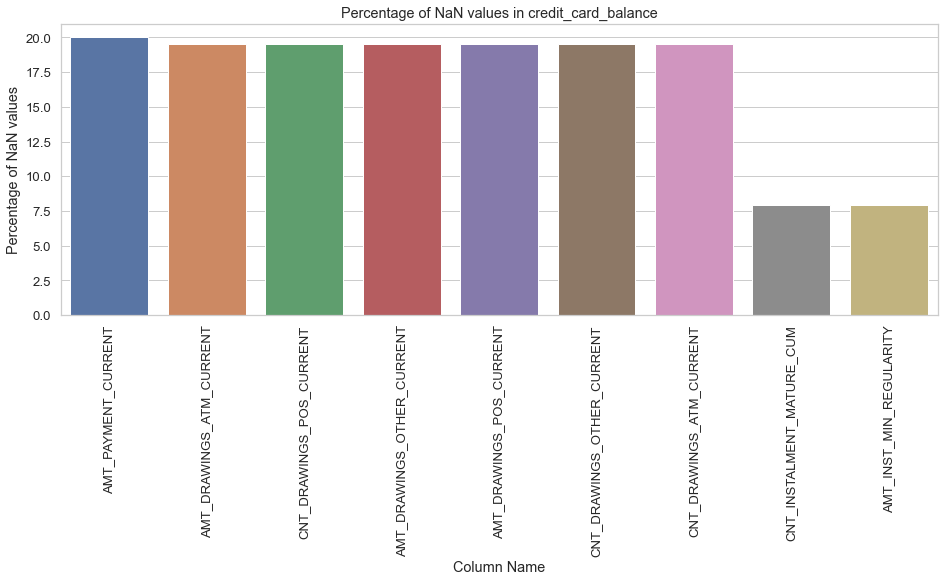

----------------------------------------------------------------------------------------------------


In [127]:
cc_balance_nan = nan_df_create(credit_card_balance)
print('-'*100)
plot_nan_percent(cc_balance_nan, 'credit_card_balance', tight_layout = False, rotation = 90, figsize = (14,5))
print('-'*100)

# Merging the TARGETS from application_train to credit_card_balance table.

In [128]:
print("-"*100)
print("Merging TARGET with credit_card_balance Table")
cc_balance_merged = app_train.iloc[:,:2].merge(credit_card_balance, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with credit_card_balance Table
----------------------------------------------------------------------------------------------------


## Correlation Matrix of Features

----------------------------------------------------------------------------------------------------


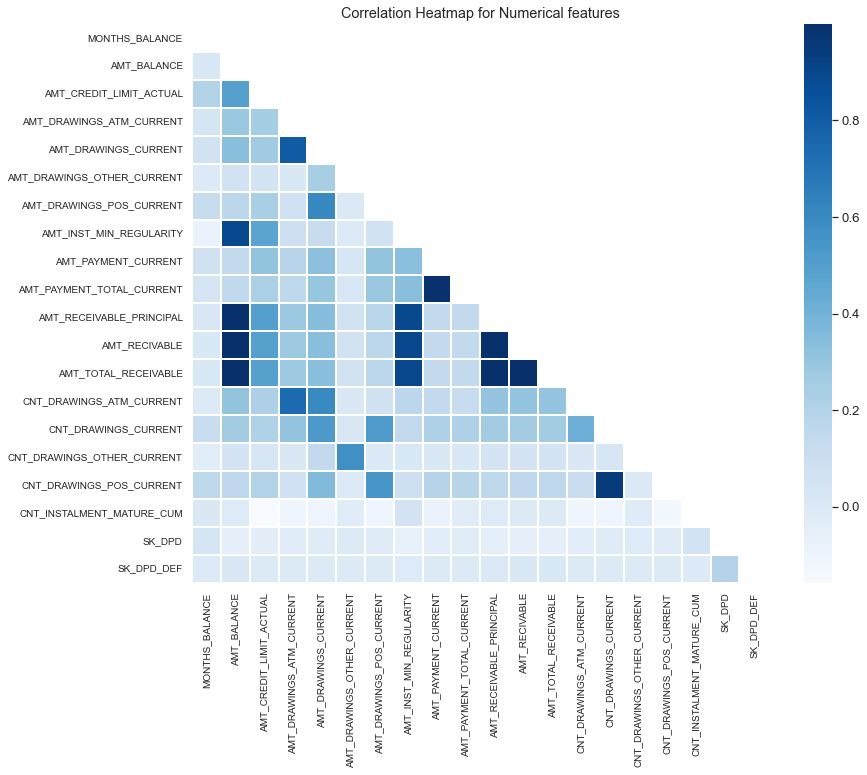

----------------------------------------------------------------------------------------------------


In [129]:
corr_mat = correlation_matrix(cc_balance_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (13,11))
corr_mat.plot_correlation_matrix()

In [130]:
#Seeing the top columns with highest phik-correlation with the target variable in credit_card_balance table

top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-" * 100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_LIMIT_ACTUAL']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_ATM_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_OTHER_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_POS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_INST_MIN_REGULARITY']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_TOTAL_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_RECEIVABLE_PRINCIPAL']
interval columns not set, guessing: ['TARGET', 'AMT_RECIVABLE']
interval columns not set, guessing: ['TARGET', 'AMT_TOTAL_RECEIVABLE']
interval columns not set, guessing: ['TARGET', 'CNT_DRAWINGS_ATM_CURREN

Column Name  Phik-Correlation
1                 AMT_BALANCE          0.059838
11              AMT_RECIVABLE          0.059311
12       AMT_TOTAL_RECEIVABLE          0.059287
10   AMT_RECEIVABLE_PRINCIPAL          0.058895
0              MONTHS_BALANCE          0.050360
7     AMT_INST_MIN_REGULARITY          0.042174
17  CNT_INSTALMENT_MATURE_CUM          0.038261
13   CNT_DRAWINGS_ATM_CURRENT          0.030052
2     AMT_CREDIT_LIMIT_ACTUAL          0.028752
14       CNT_DRAWINGS_CURRENT          0.027868

----------------------------------------------------------------------------------------------------


In [131]:
# Columns

cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(credit_card_balance, car_th=10)

Observations: 3840312
Variables: 23
date_cols: 0
cat_cols: 1
num_cols: 22
cat_but_car: 0
num_but_cat: 0


In [132]:
# Numeric Features

credit_card_balance.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

MONTHS_BALANCE   AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
mean      -34.521921  5.830016e+04             1.538080e+05   
std        26.667751  1.063070e+05             1.651457e+05   
min       -96.000000 -4.202502e+05             0.000000e+00   
1%        -93.000000  0.000000e+00             0.000000e+00   
10%       -76.000000  0.000000e+00             0.000000e+00   
25%       -55.000000  0.000000e+00             4.500000e+04   
50%       -28.000000  0.000000e+00             1.125000e+05   
75%       -11.000000  8.904669e+04             1.800000e+05   
80%        -9.000000  1.168807e+05             2.250000e+05   
90%        -5.000000  1.800162e+05             4.275000e+05   
95%        -3.000000  2.571814e+05             4.500000e+05   
99%        -1.000000  4.662951e+05             7.650000e+05   
max        -1.000000  1.505902e+06             1.350000e+06   

      AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
mean              5.961325e+03          7.433388e+03   
std               2.822569e+04          3.384608e+04   
min              -6.827310e+03         -6.211620e+03   
1%                0.000000e+00          0.000000e+00   
10%               0.000000e+00          0.000000e+00   
25%               0.000000e+00          0.000000e+00   
50%               0.000000e+00          0.000000e+00   
75%               0.000000e+00          0.000000e+00   
80%               0.000000e+00          0.000000e+00   
90%               6.750000e+03          1.125000e+04   
95%               3.375000e+04          4.500000e+04   
99%               1.350000e+05          1.575000e+05   
max               2.115000e+06          2.287098e+06   

      AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
mean                2.881696e+02              2.968805e+03   
std                 8.201989e+03              2.079689e+04   
min                 0.000000e+00              0.000000e+00   
1%                  0.000000e+00              0.000000e+00   
10%                 0.000000e+00              0.000000e+00   
25%                 0.000000e+00              0.000000e+00   
50%                 0.000000e+00              0.000000e+00   
75%                 0.000000e+00              0.000000e+00   
80%                 0.000000e+00              0.000000e+00   
90%                 0.000000e+00              0.000000e+00   
95%                 0.000000e+00              1.011600e+04   
99%                 0.000000e+00              7.708061e+04   
max                 1.529847e+06              2.239274e+06   

      AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
mean              3540.204129         1.028054e+04               7.588857e+03   
std               5600.154122         3.607808e+04               3.200599e+04   
min                  0.000000         0.000000e+00               0.000000e+00   
1%                   0.000000         0.000000e+00               0.000000e+00   
10%                  0.000000         0.000000e+00               0.000000e+00   
25%                  0.000000         1.523700e+02               0.000000e+00   
50%                  0.000000         2.702700e+03               0.000000e+00   
75%               6633.911250         9.000000e+03               6.750000e+03   
80%               7283.970000         1.080000e+04               9.000000e+03   
90%               9000.000000         1.890000e+04               1.350000e+04   
95%              13500.000000         3.150000e+04               2.340000e+04   
99%              23312.801250         1.506174e+05               1.286149e+05   
max             202882.005000         4.289207e+06               4.278316e+06   

      AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
mean              5.596588e+04   5.808881e+04          5.809829e+04   
std               1.025336e+05   1.059654e+05          1.059718e+05   
min              -4.233058e+05  -4.202502e+05         -4.202502e+05   
1%                0.000000e+00  -4.872600e+02     

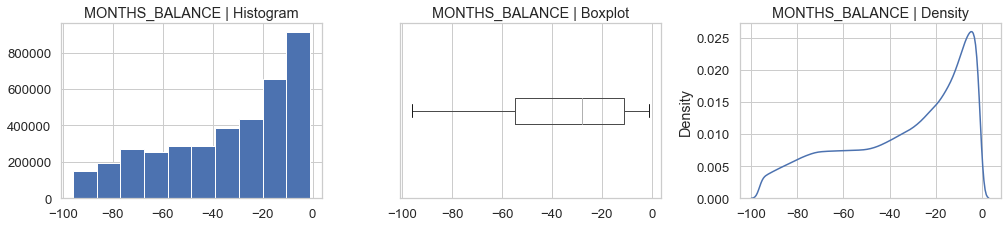

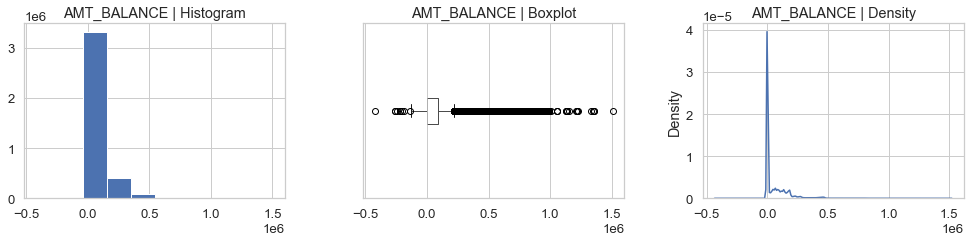

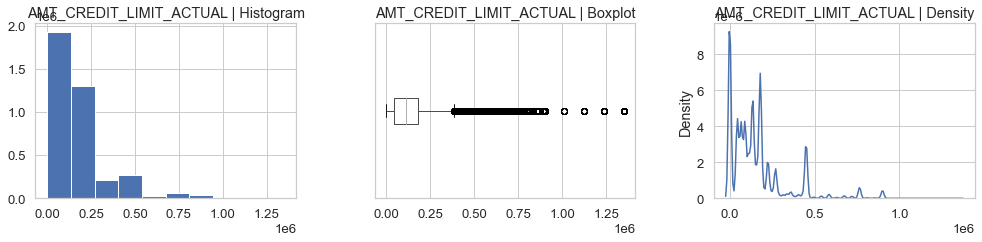

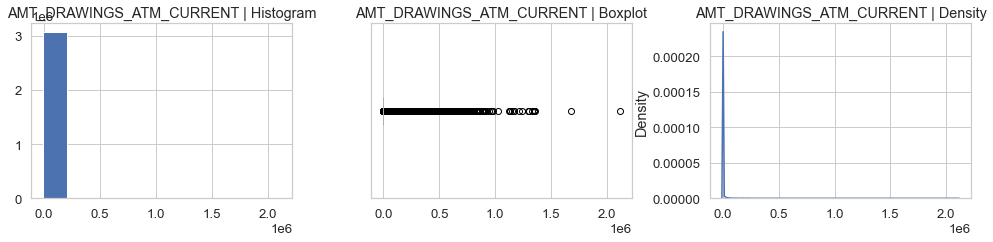

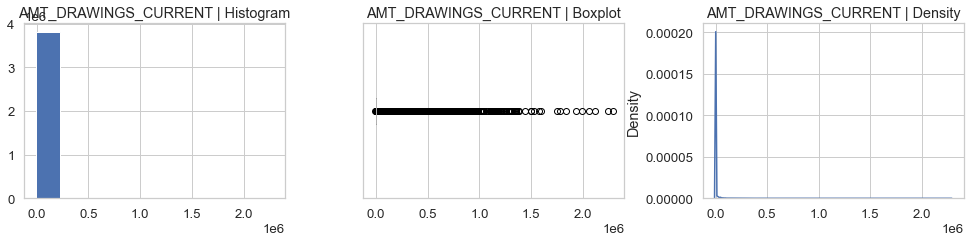

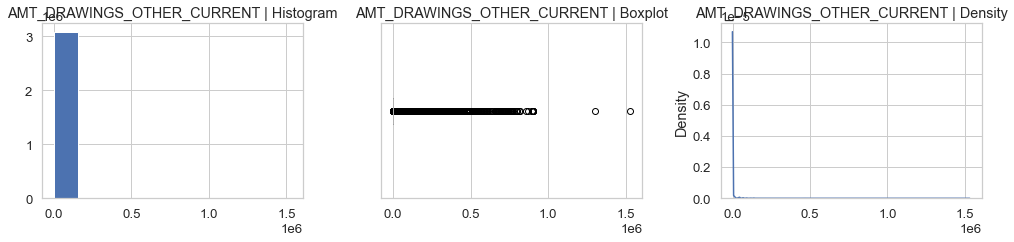

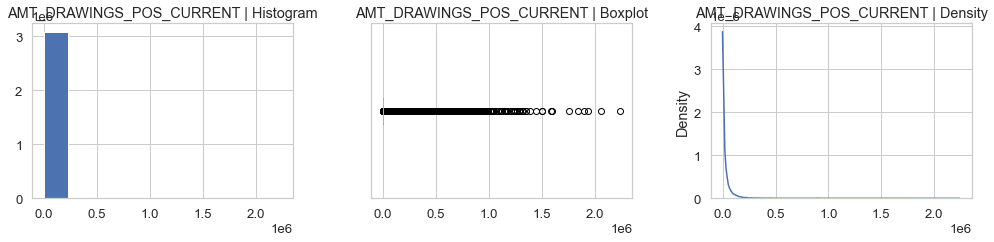

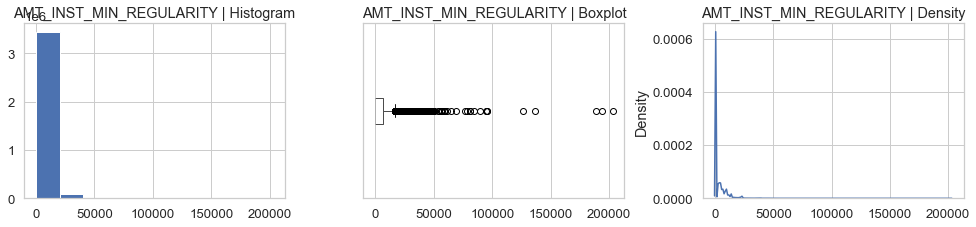

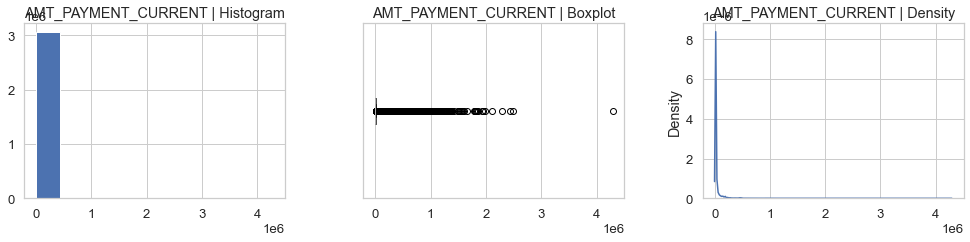

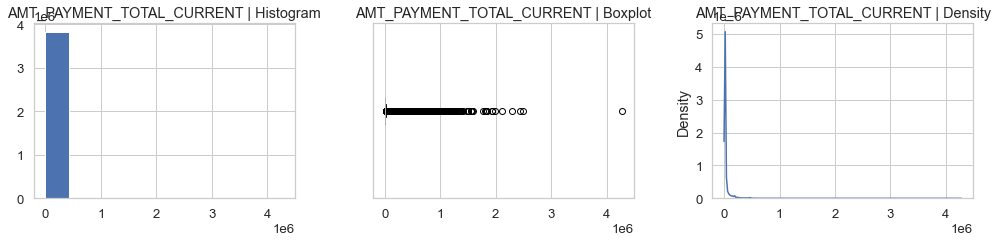

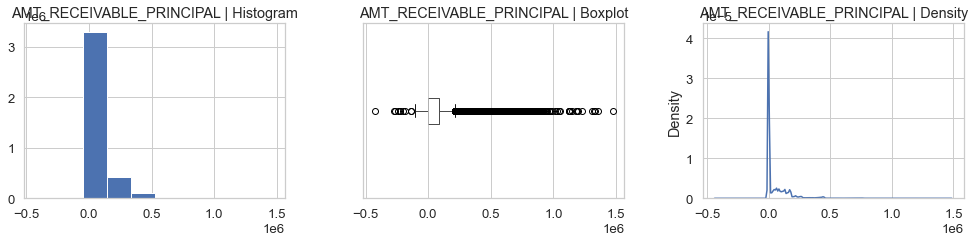

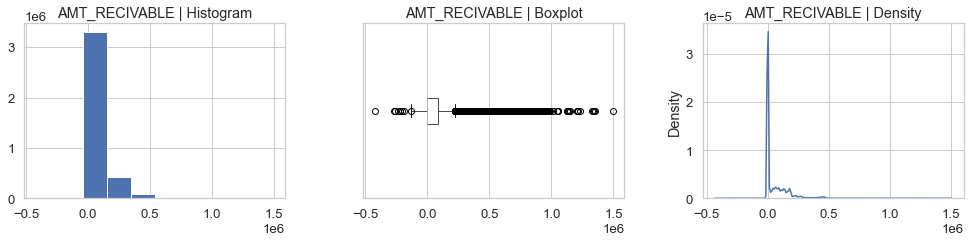

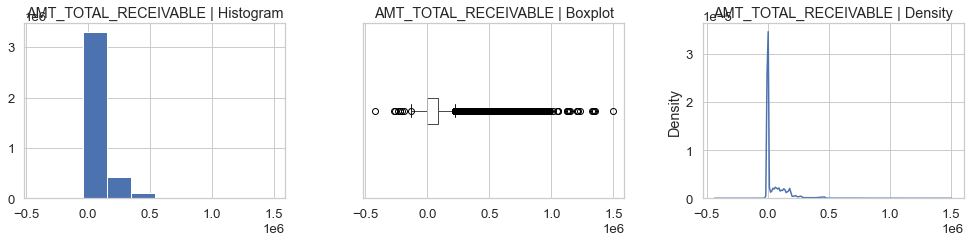

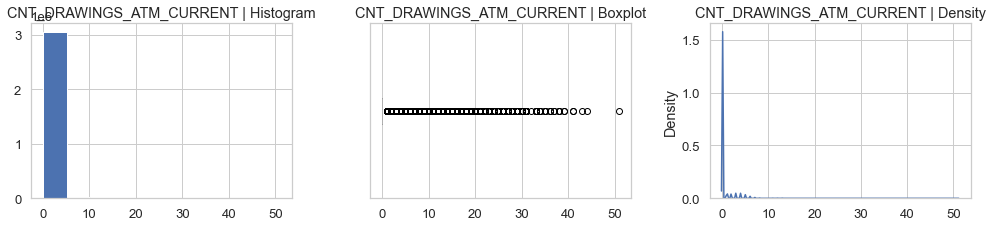

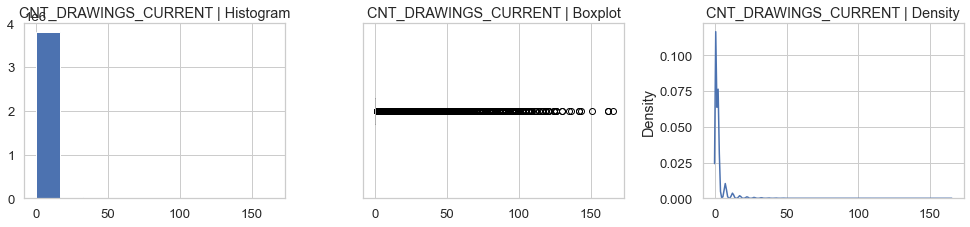

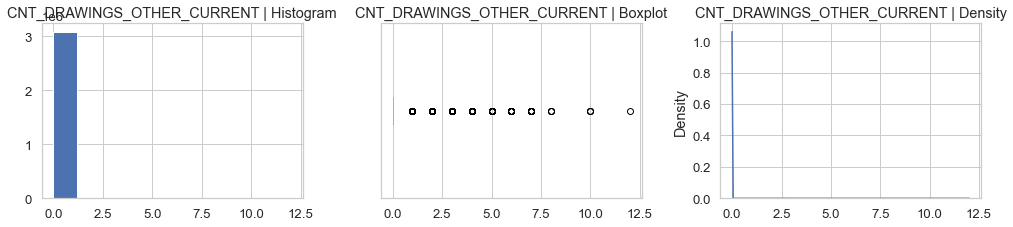

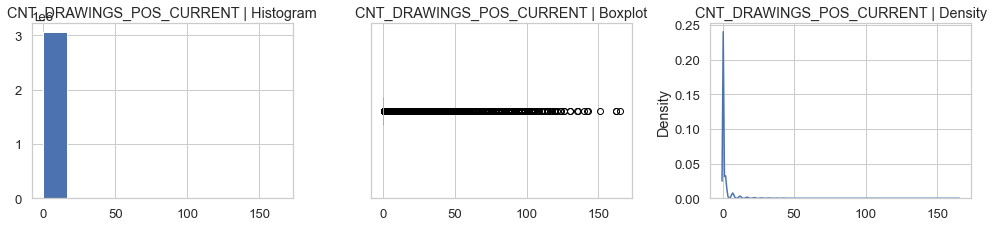

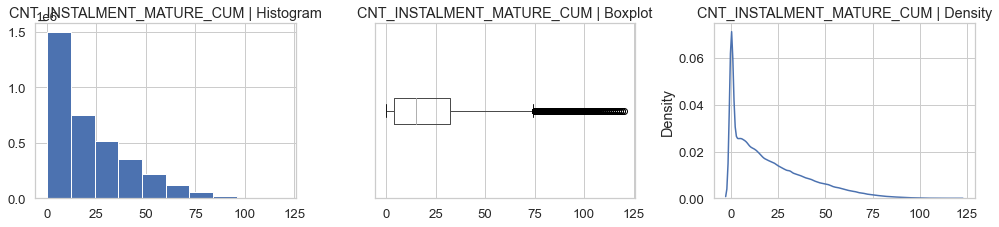

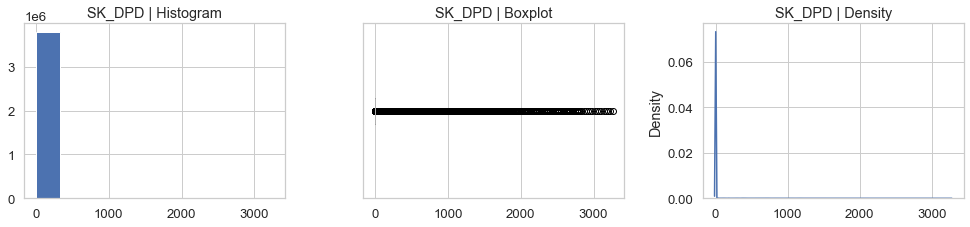

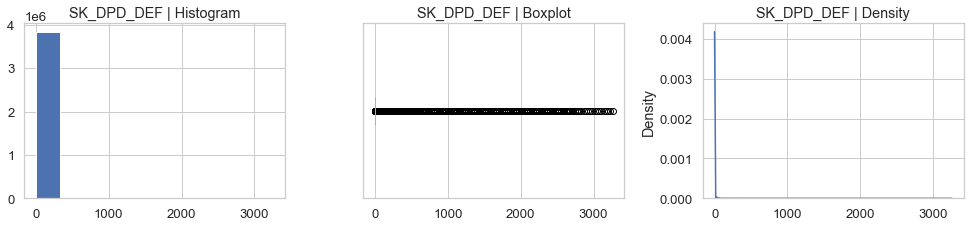

In [133]:
# Quick Visualization for numerical variables

num_plot(credit_card_balance, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

In [134]:
cc_balance_merged = cc_balance_merged.groupby('SK_ID_PREV').mean()

## Distribution of Continuous Vairable AMT_BALANCE

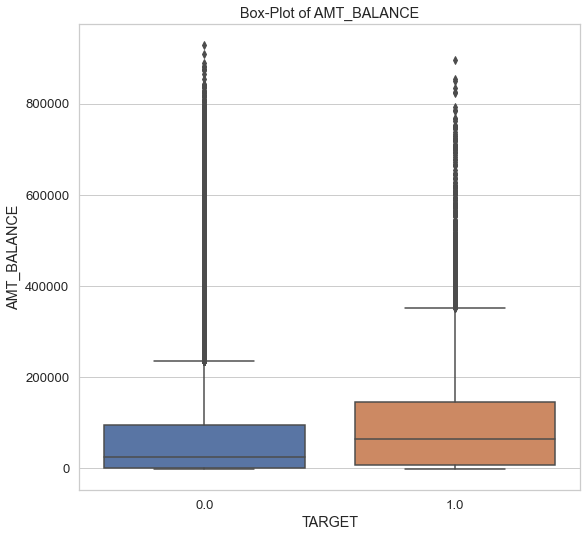

In [135]:
plot_continuous_variables(cc_balance_merged, 'AMT_BALANCE', plots = ['box'], figsize = (8,8))

## Distribution of Continuous Vairable AMT_TOTAL_RECEIVABLE

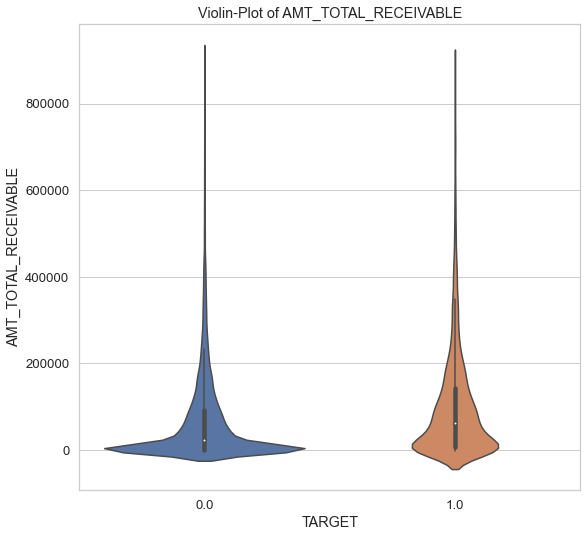

In [136]:
plot_continuous_variables(cc_balance_merged, 'AMT_TOTAL_RECEIVABLE', plots = ['violin'], figsize = (8,8))

## Distribution of Continuous Vairable CNT_INSTALMENT_MATURE_CUM

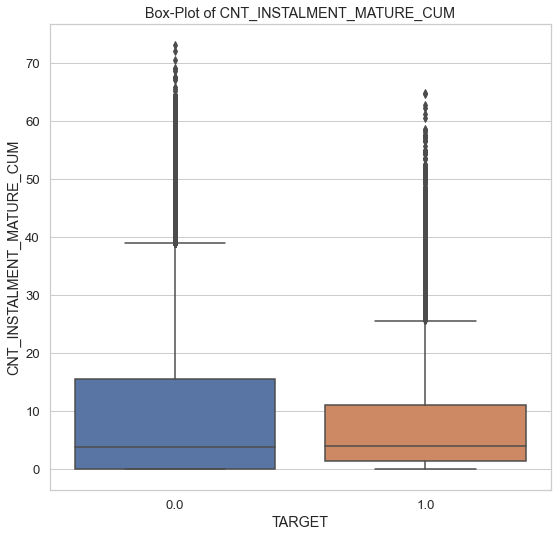

In [137]:
plot_continuous_variables(cc_balance_merged, 'CNT_INSTALMENT_MATURE_CUM', plots = ['box'], figsize = (8,8))

## EDA for Installments Payments

In [138]:
print("-"*100)
print("Merging TARGET with installments_payments Table")
installments_merged = app_train.iloc[:,:2].merge(installments_payments, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with installments_payments Table
----------------------------------------------------------------------------------------------------


## Correlation Matrix of Features

----------------------------------------------------------------------------------------------------


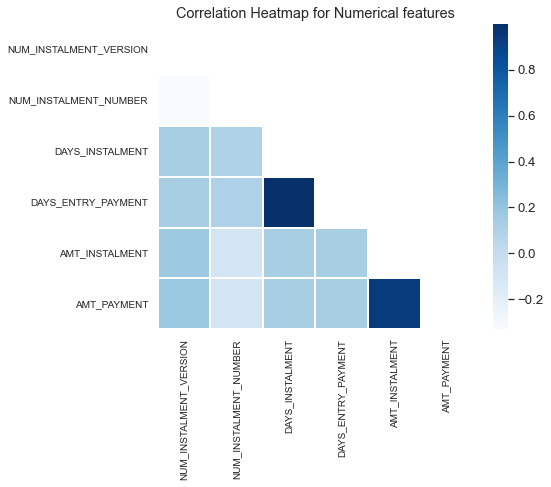

----------------------------------------------------------------------------------------------------


In [139]:
corr_mat = correlation_matrix(installments_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (8,7))
corr_mat.plot_correlation_matrix()

In [140]:
#Seeing the top columns with highest phik-correlation with the target variable in installments_payments table

top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_VERSION']
interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_NUMBER']
interval columns not set, guessing: ['TARGET', 'DAYS_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_ENTRY_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


Column Name  Phik-Correlation
2         DAYS_INSTALMENT          0.046824
3      DAYS_ENTRY_PAYMENT          0.033128
1   NUM_INSTALMENT_NUMBER          0.022993
4          AMT_INSTALMENT          0.004125
5             AMT_PAYMENT          0.003084
0  NUM_INSTALMENT_VERSION          0.002198

----------------------------------------------------------------------------------------------------


In [141]:
# Columns

cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(installments_payments, car_th=10)

Observations: 13605401
Variables: 8
date_cols: 0
cat_cols: 0
num_cols: 8
cat_but_car: 0
num_but_cat: 0


In [142]:
# Numeric Features

installments_payments.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  \
mean                0.856637              18.870896     -1042.269992   
std                 1.035216              26.664067       800.946284   
min                 0.000000               1.000000     -2922.000000   
1%                  0.000000               1.000000     -2832.000000   
10%                 0.000000               2.000000     -2307.000000   
25%                 0.000000               4.000000     -1654.000000   
50%                 1.000000               8.000000      -818.000000   
75%                 1.000000              19.000000      -361.000000   
80%                 1.000000              25.000000      -288.000000   
90%                 1.000000              56.000000      -150.000000   
95%                 2.000000              82.000000       -81.000000   
99%                 4.000000             121.000000       -21.000000   
max               178.000000             277.000000        -1.000000   

      DAYS_ENTRY_PAYMENT  AMT_INSTALMENT   AMT_PAYMENT  
mean        -1051.113684    1.705091e+04  1.723822e+04  
std           800.585883    5.057025e+04  5.473578e+04  
min         -4921.000000    0.000000e+00  0.000000e+00  
1%          -2837.000000    1.327500e+01  3.780000e+00  
10%         -2316.000000    7.177050e+02  3.318300e+02  
25%         -1662.000000    4.226085e+03  3.398265e+03  
50%          -827.000000    8.884080e+03  8.125515e+03  
75%          -370.000000    1.671021e+04  1.610842e+04  
80%          -298.000000    2.013183e+04  1.935000e+04  
90%          -159.000000    3.141517e+04  3.117992e+04  
95%           -90.000000    4.704133e+04  4.773218e+04  
99%           -28.000000    1.460687e+05  1.780040e+05  
max            -1.000000    3.771488e+06  3.771488e+06

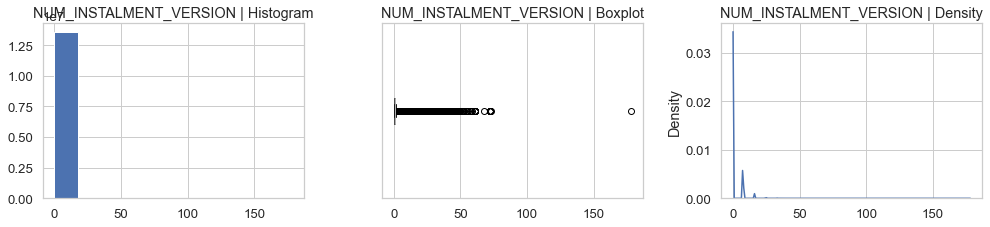

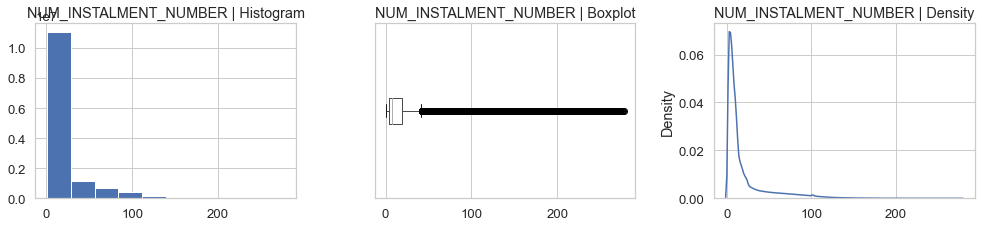

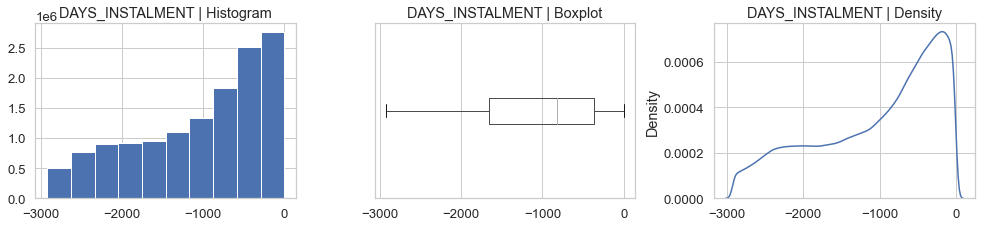

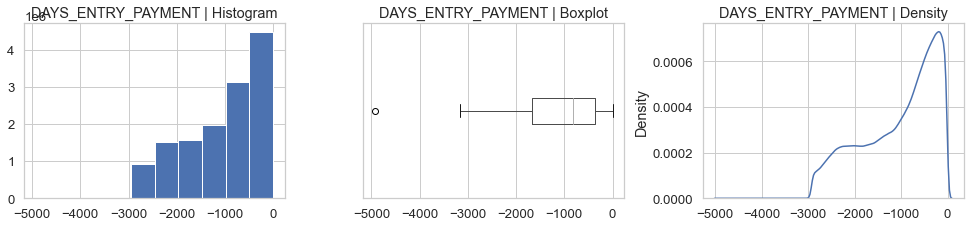

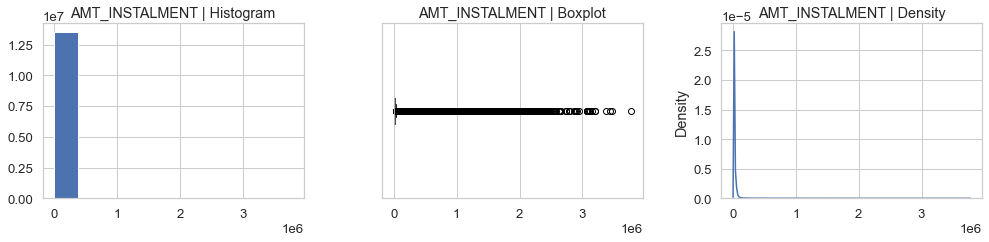

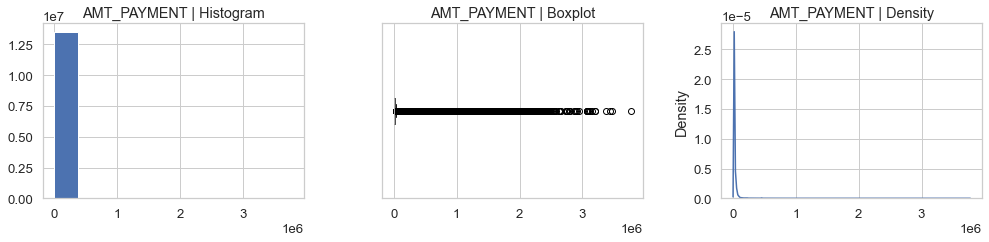

In [143]:
# Quick Visualization for numerical variables

num_plot(installments_payments, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

## Distribution of Continuous Vairable DAYS_INSTALMENT

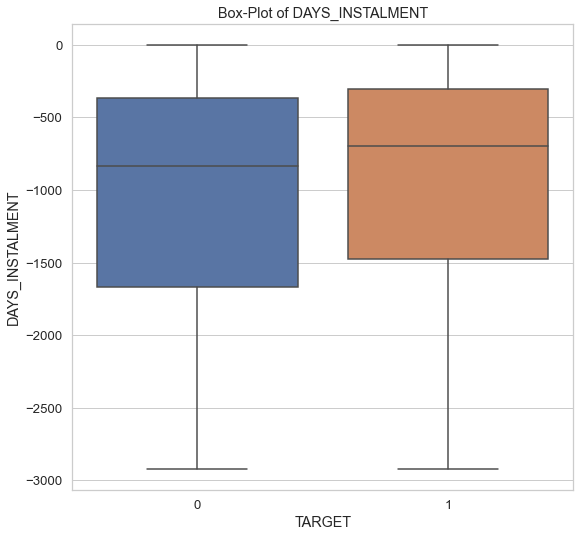

In [144]:
plot_continuous_variables(installments_merged, 'DAYS_INSTALMENT', plots = ['box'], figsize = (8,8))

## Distribution of Continuous Vairable DAYS_ENTRY_PAYMENT

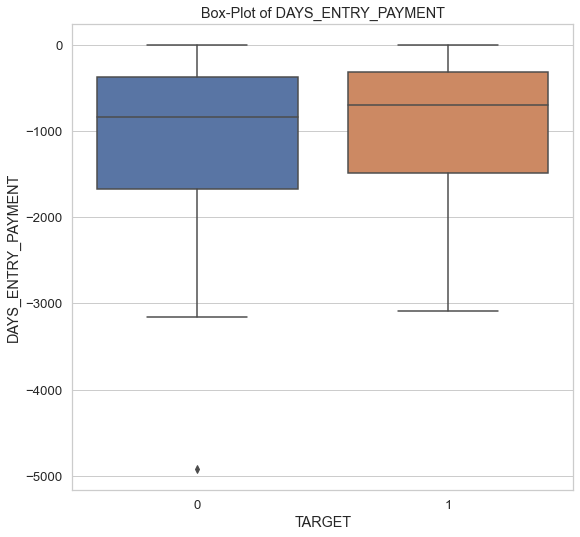

In [145]:
plot_continuous_variables(installments_merged, 'DAYS_ENTRY_PAYMENT', plots = ['box'], figsize = (8,8))

## EDA for Previous Applications Data

## NaN Columns and Percentages

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 16 columns


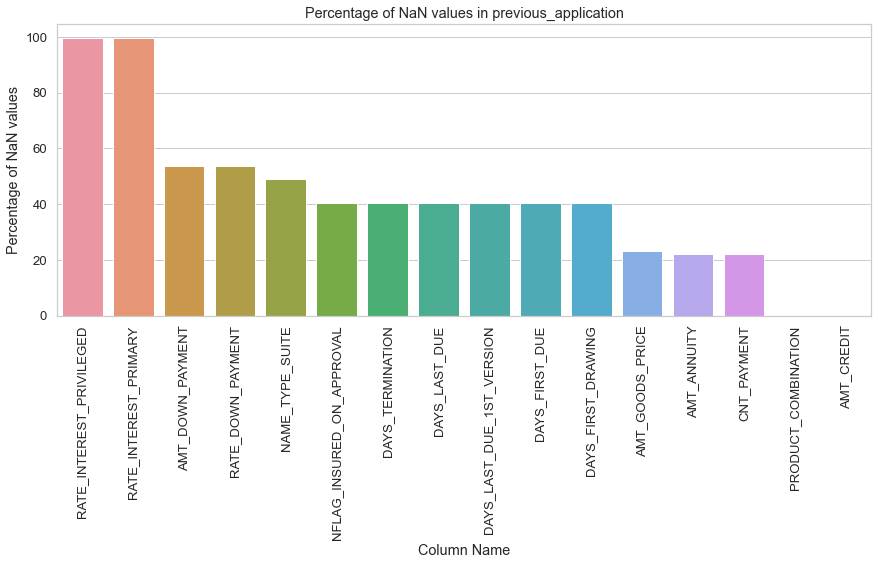

----------------------------------------------------------------------------------------------------


In [146]:
previous_application_nan = nan_df_create(previous_application)
print('-' * 100)
plot_nan_percent(previous_application_nan, 'previous_application', tight_layout = False, figsize = (13,5))
print('-' * 100)

In [147]:
print("-"*100)
print("Merging TARGET with previous_application Table")
prev_merged = app_train.iloc[:,:2].merge(previous_application, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with previous_application Table
----------------------------------------------------------------------------------------------------


## Phi-K Matrix

----------------------------------------------------------------------------------------------------


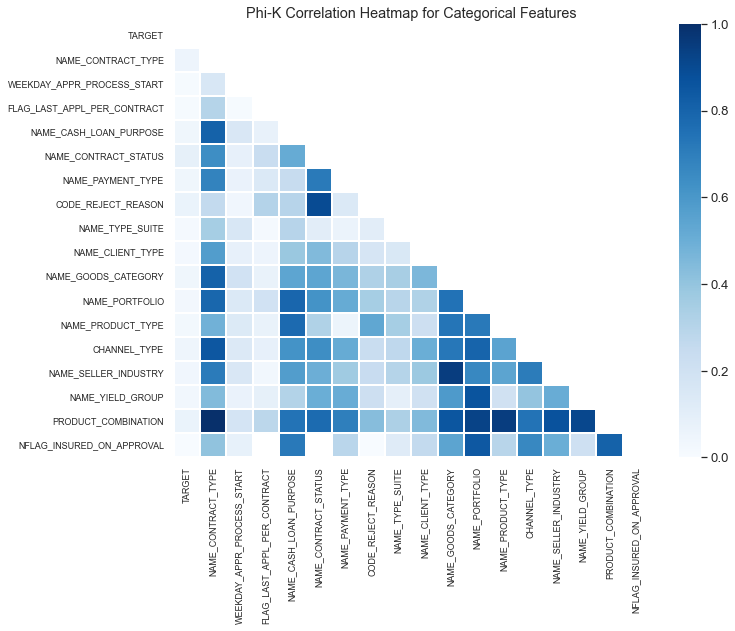

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


Column Name  Phik-Correlation
4     NAME_CONTRACT_STATUS          0.088266
15     PRODUCT_COMBINATION          0.063839
6       CODE_REJECT_REASON          0.062771
0       NAME_CONTRACT_TYPE          0.050859
12            CHANNEL_TYPE          0.050302
9      NAME_GOODS_CATEGORY          0.042951
3   NAME_CASH_LOAN_PURPOSE          0.040305
5        NAME_PAYMENT_TYPE          0.039752
13    NAME_SELLER_INDUSTRY          0.038077
14        NAME_YIELD_GROUP          0.034626

----------------------------------------------------------------------------------------------------


In [148]:
cols_for_phik = ['TARGET'] + prev_merged.dtypes[prev_merged.dtypes == 'object'].index.tolist() + ['NFLAG_INSURED_ON_APPROVAL']
plot_phik_matrix(prev_merged, cols_for_phik, cmap = 'Blues', figsize = (11,9), fontsize = 9)

In [149]:
## Correlation Matrix of Features

----------------------------------------------------------------------------------------------------


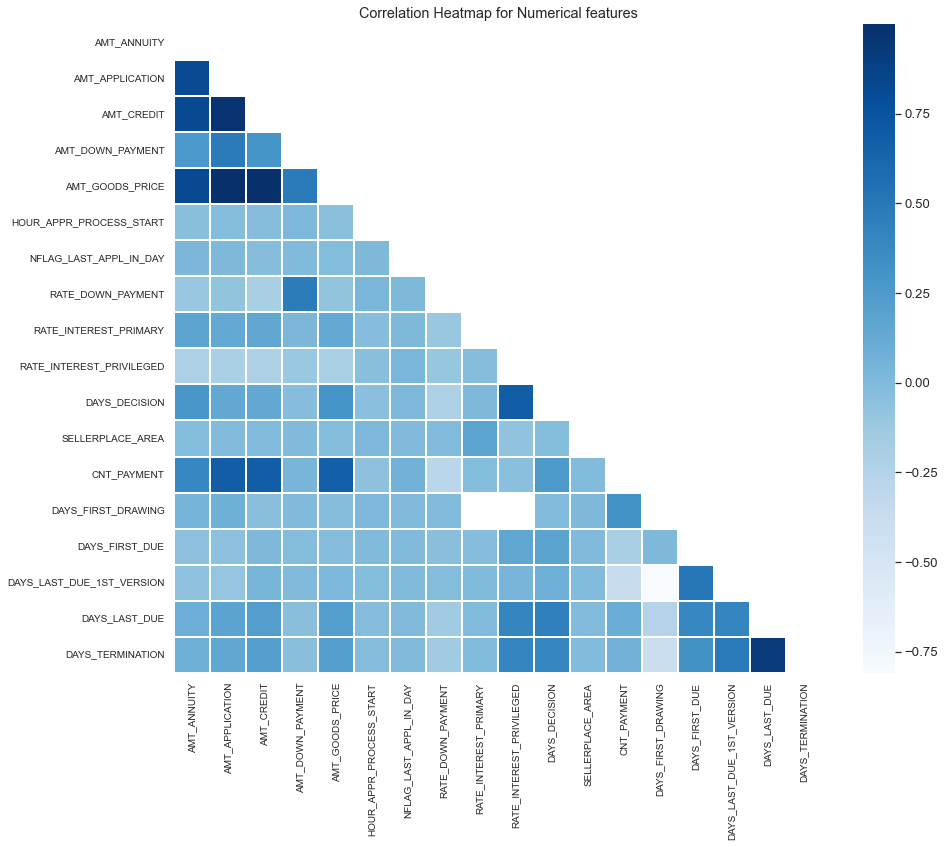

----------------------------------------------------------------------------------------------------


In [150]:
corr_mat = correlation_matrix(prev_merged, ['SK_ID_CURR','SK_ID_PREV','NFLAG_INSURED_ON_APPROVAL'], cmap = 'Blues', figsize = (14,12))
corr_mat.plot_correlation_matrix()

In [151]:
#Seeing the top columns with highest phik-correlation with the target variable in previous_applications table

top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_APPLICATION']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'NFLAG_LAST_APPL_IN_DAY']
interval columns not set, guessing: ['TARGET', 'RATE_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIMARY']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIVILEGED']
interval columns not set, guessing: ['TARGET', 'DAYS_DECISION']
interval columns not set, guessing: ['TARGET', 'SELLERPLACE_AREA']
interval columns not set, guessing: ['TARGET', 'CNT_PAYMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_FIRST_DRAWING']
interval columns not set, guessing: ['TARGET', 'DAYS_F

Column Name  Phik-Correlation
12                CNT_PAYMENT          0.056639
10              DAYS_DECISION          0.053694
13         DAYS_FIRST_DRAWING          0.048993
7           RATE_DOWN_PAYMENT          0.039592
5     HOUR_APPR_PROCESS_START          0.038121
9    RATE_INTEREST_PRIVILEGED          0.028204
15  DAYS_LAST_DUE_1ST_VERSION          0.027878
16              DAYS_LAST_DUE          0.027320
17           DAYS_TERMINATION          0.026479
0                 AMT_ANNUITY          0.013808

----------------------------------------------------------------------------------------------------


In [152]:
# Columns

cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(previous_application, car_th=10)

Observations: 1670214
Variables: 37
date_cols: 0
cat_cols: 14
num_cols: 19
cat_but_car: 4
num_but_cat: 2


In [153]:
# Numeric Features

previous_application.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

AMT_ANNUITY  AMT_APPLICATION    AMT_CREDIT  AMT_DOWN_PAYMENT  \
mean   15955.120659     1.752339e+05  1.961140e+05      6.697402e+03   
std    14782.137335     2.927798e+05  3.185746e+05      2.092150e+04   
min        0.000000     0.000000e+00  0.000000e+00     -9.000000e-01   
1%      2137.175100     0.000000e+00  0.000000e+00      0.000000e+00   
10%     3817.530000     0.000000e+00  0.000000e+00      0.000000e+00   
25%     6321.780000     1.872000e+04  2.416050e+04      0.000000e+00   
50%    11250.000000     7.104600e+04  8.054100e+04      1.638000e+03   
75%    20658.420000     1.803600e+05  2.164185e+05      7.740000e+03   
80%    23638.500000     2.289375e+05  2.700000e+05      9.450000e+03   
90%    34703.820000     4.500000e+05  5.331600e+05      1.710900e+04   
95%    45336.780000     7.875000e+05  8.865000e+05      2.618408e+04   
99%    69685.788600     1.350000e+06  1.515378e+06      6.593089e+04   
max   418058.145000     6.905160e+06  6.905160e+06      3.060045e+06   

      AMT_GOODS_PRICE  HOUR_APPR_PROCESS_START  NFLAG_LAST_APPL_IN_DAY  \
mean     2.278473e+05                12.484182                0.996468   
std      3.153966e+05                 3.334028                0.059330   
min      0.000000e+00                 0.000000                0.000000   
1%       1.530000e+04                 5.000000                1.000000   
10%      3.055500e+04                 8.000000                1.000000   
25%      5.084100e+04                10.000000                1.000000   
50%      1.123200e+05                12.000000                1.000000   
75%      2.340000e+05                15.000000                1.000000   
80%      3.150000e+05                16.000000                1.000000   
90%      5.850000e+05                17.000000                1.000000   
95%      9.000000e+05                18.000000                1.000000   
99%      1.395000e+06                20.000000                1.000000   
max      6.905160e+06                23.000000                1.000000   

      RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
mean           0.079637               0.188357                  0.773503   
std            0.107823               0.087671                  0.100879   
min           -0.000015               0.034781                  0.373150   
1%             0.000000               0.059135                  0.424419   
10%            0.000000               0.142440                  0.637949   
25%            0.000000               0.160716                  0.715645   
50%            0.051605               0.189122                  0.835095   
75%            0.108909               0.193330                  0.852537   
80%            0.109732               0.193330                  0.852537   
90%            0.211997               0.196900                  0.867336   
95%            0.294126               0.196914                  0.867336   
99%            0.521085               0.696178                  0.867336   
max            1.000000               1.000000                  1.000000   

      DAYS_DECISION  SELLERPLACE_AREA  CNT_PAYMENT  DAYS_FIRST_DRAWING  \
mean    -880.679668      3.139511e+02    16.054082       342209.855039   
std      779.099667      7.127443e+03    14.567288        88916.115834   
min    -2922.000000     -1.000000e+00     0.000000        -2922.000000   
1%     -2835.000000     -1.000000e+00     0.000000        -2441.000000   
10%    -2250.000000     -1.000000e+00     0.000000       365243.000000   
25%    -1300.000000     -1.000000e+00     6.000000       365243.000000   
50%     -581.000000      3.000000e+00    12.000000       365243.000000   
75%     -280.000000      8.200000e+01    24.000000       365243.000000   
80%     -239.000000      1.400000e+02    24.000000       365243.000000   
90%     -152.000000      9.190000e+02    36.000000       365243.000000   
95%      -85.000000      1.820000e+03    48.000000       365243.000000   
99%      

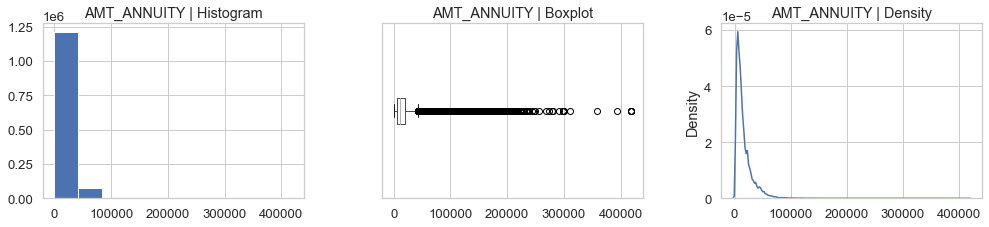

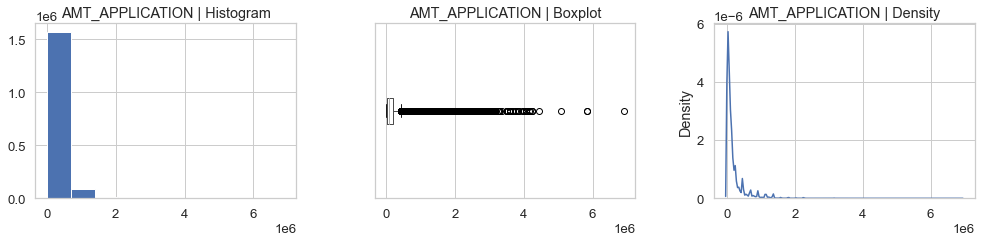

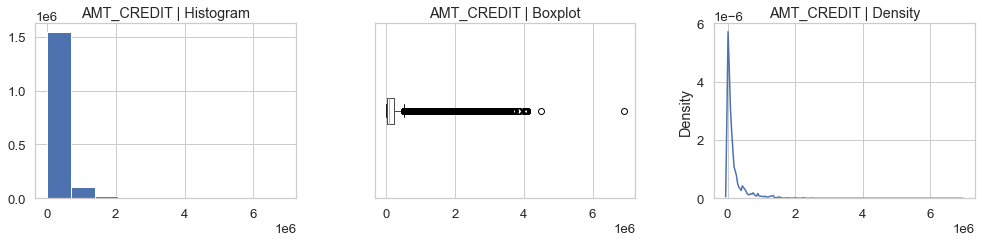

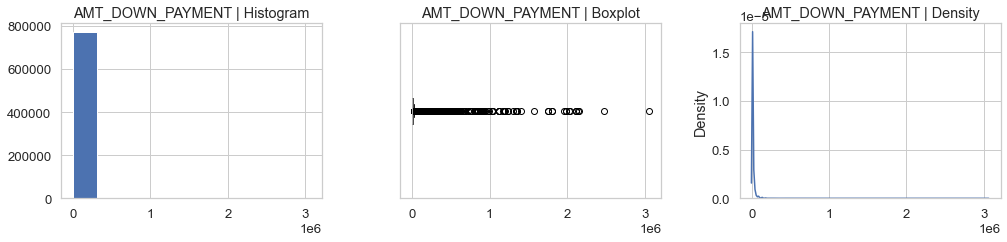

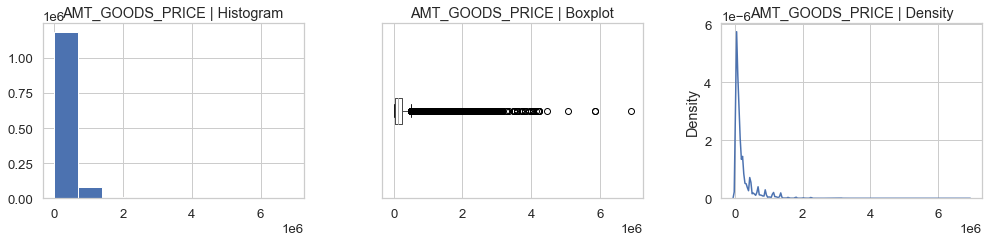

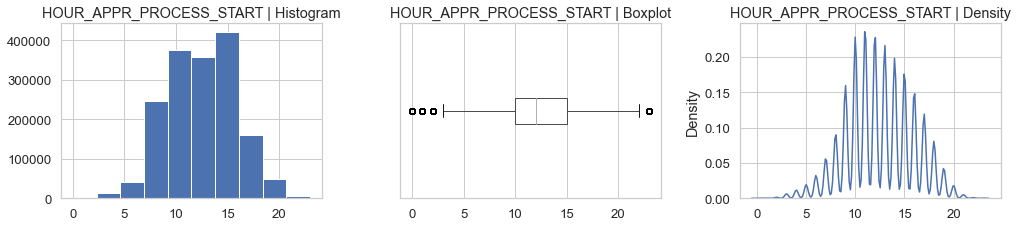

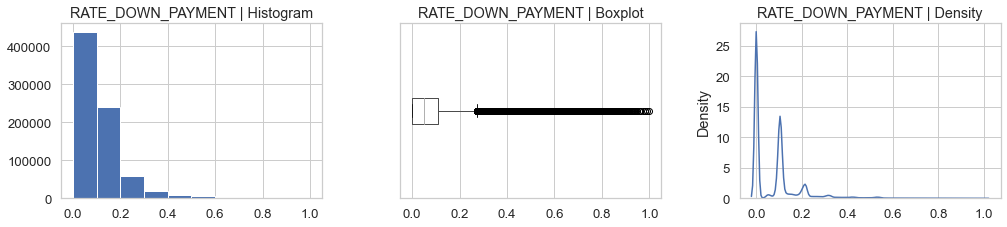

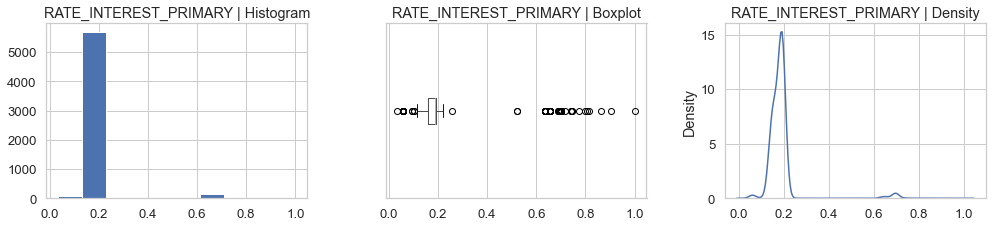

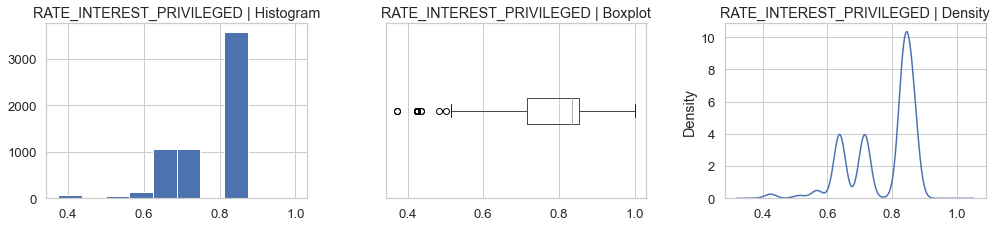

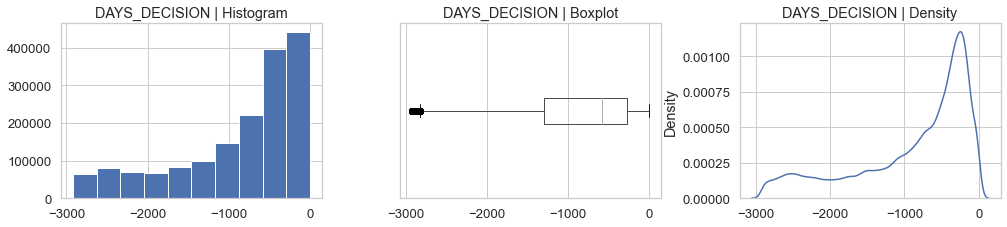

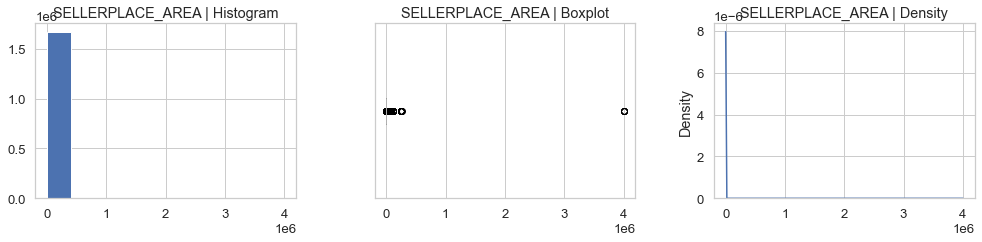

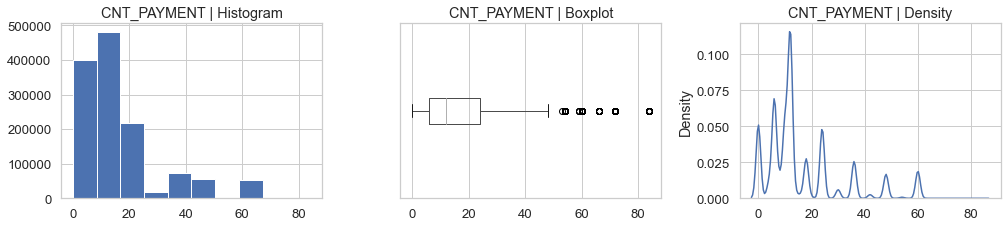

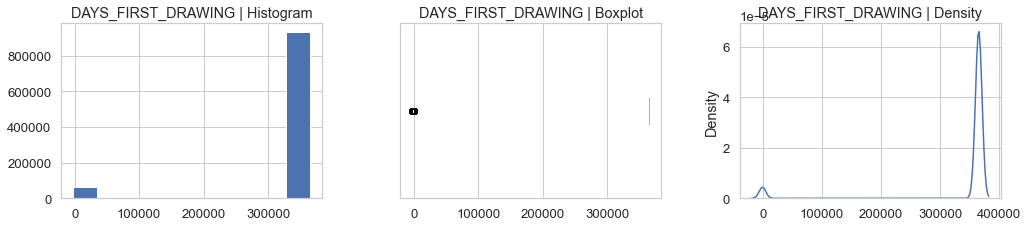

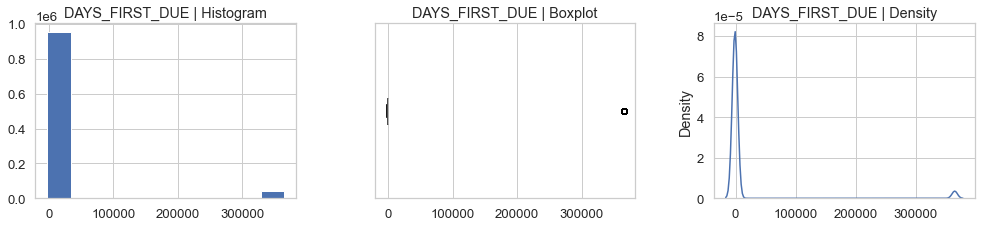

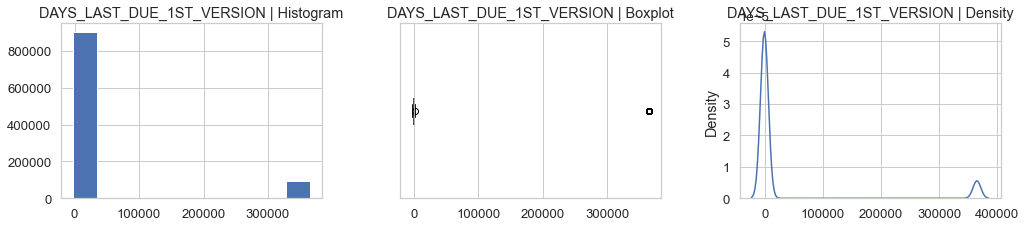

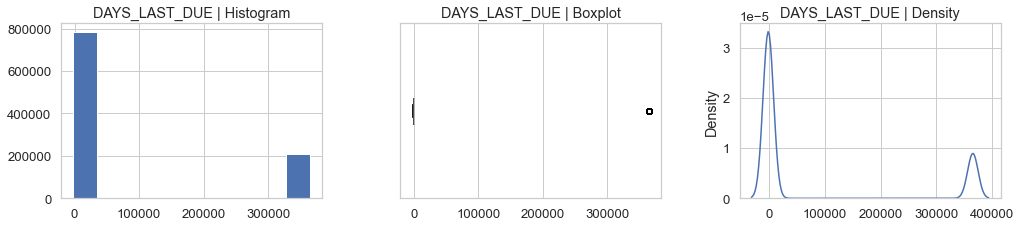

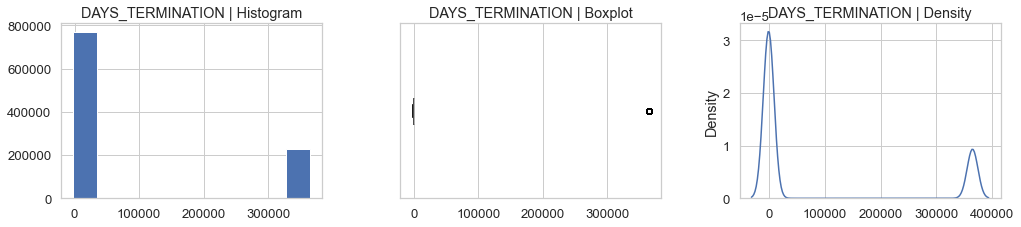

In [154]:
# Quick Visualization for numerical variables

num_plot(previous_application, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

## Distribution of Categorical Variable NAME_CONTRACT_TYPE

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_TYPE' are:
['Consumer loans' 'Cash loans' 'Revolving loans' nan 'XNA']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Cash loans         626764
Consumer loans     625256
Revolving loans    161368
XNA                   313
Name: NAME_CONTRACT_TYPE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CONTRACT_TYPE = 5


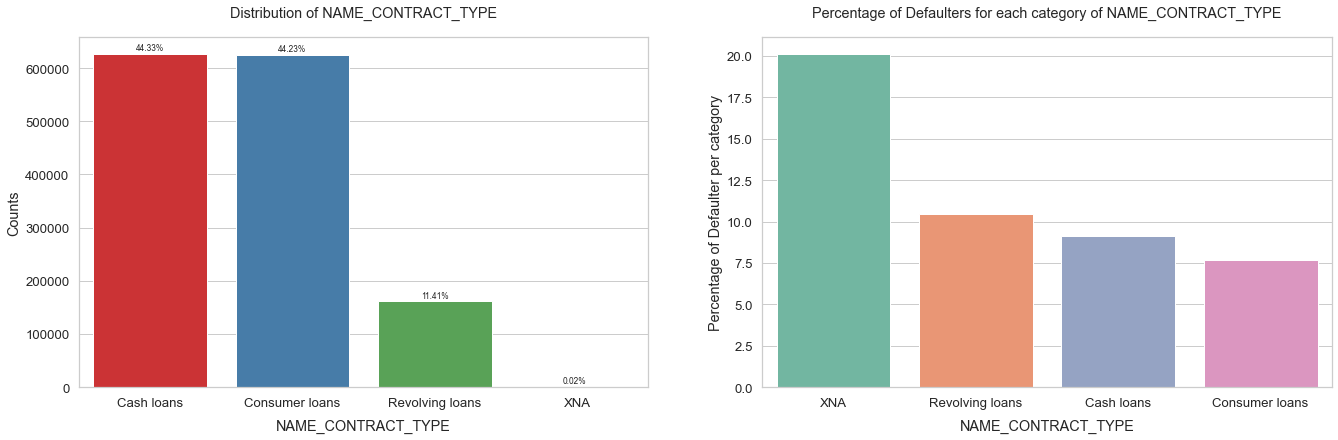

----------------------------------------------------------------------------------------------------


In [155]:
#let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(prev_merged, 'NAME_CONTRACT_TYPE', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_TYPE', horizontal_adjust = 0.3, figsize = (20, 6))
print('-'*100)

## Distribution of Categorical Variable NAME_CONTRACT_STATUS

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_STATUS' are:
['Approved' 'Canceled' 'Refused' nan 'Unused offer']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CONTRACT_STATUS = 5


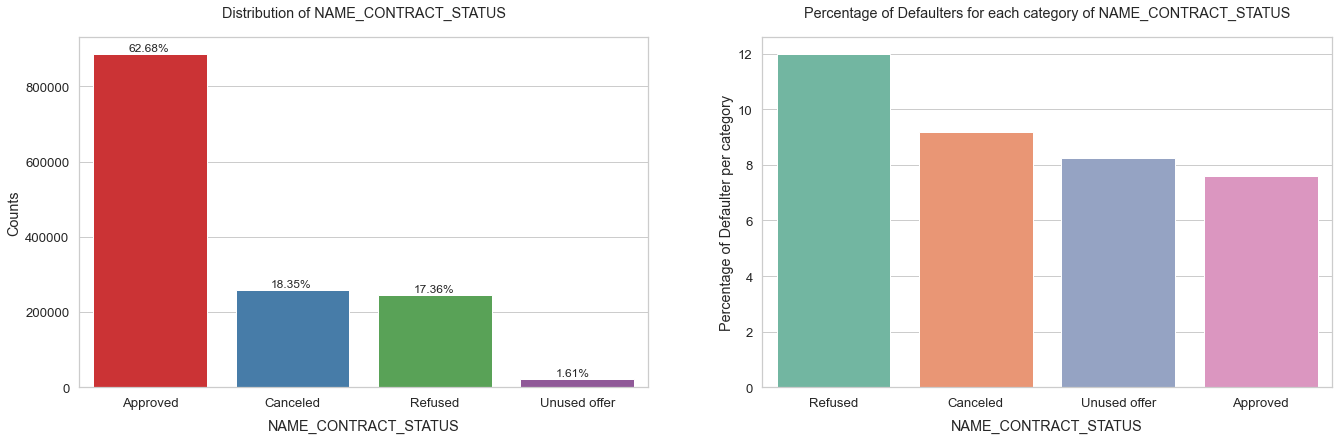

----------------------------------------------------------------------------------------------------


In [156]:
#let us first see the unique categories of 'NAME_CONTRACT_STATUS'
print_unique_categories(prev_merged, 'NAME_CONTRACT_STATUS')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_STATUS', horizontal_adjust = 0.25, figsize = (20, 6), fontsize_percent = 'small')
print('-'*100)

## Distribution of Categorical Variable CODE_REJECT_REASON

----------------------------------------------------------------------------------------------------
The unique categories of 'CODE_REJECT_REASON' are:
['XAP' 'LIMIT' nan 'HC' 'SCO' 'SCOFR' 'VERIF' 'CLIENT' 'XNA' 'SYSTEM']
----------------------------------------------------------------------------------------------------
Counts of each category are:
XAP       1145533
HC         145984
LIMIT       47773
SCO         32636
CLIENT      22771
SCOFR       10875
XNA          4378
VERIF        3079
SYSTEM        672
Name: CODE_REJECT_REASON, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CODE_REJECT_REASON = 10


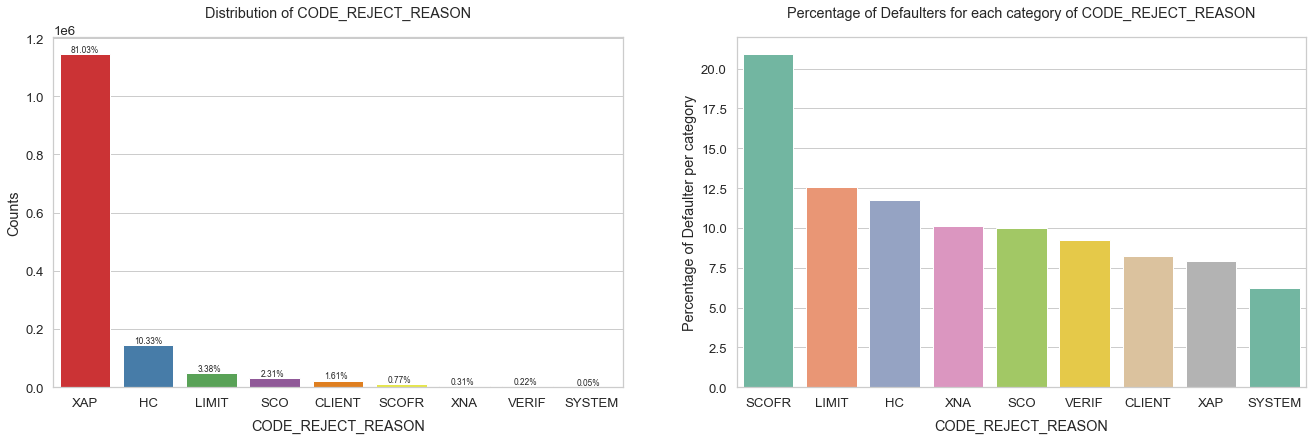

----------------------------------------------------------------------------------------------------


In [157]:
#let us first see the unique categories of 'CODE_REJECT_REASON'
print_unique_categories(prev_merged, 'CODE_REJECT_REASON', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'CODE_REJECT_REASON', horizontal_adjust = 0.18, figsize = (20, 6))
print('-'*100)

## Distribution of Categorical Variable CHANNEL_TYPE

----------------------------------------------------------------------------------------------------
The unique categories of 'CHANNEL_TYPE' are:
['Stone' 'Credit and cash offices' 'Country-wide' 'Regional / Local'
 'AP+ (Cash loan)' 'Contact center' nan 'Channel of corporate sales'
 'Car dealer']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CHANNEL_TYPE = 9


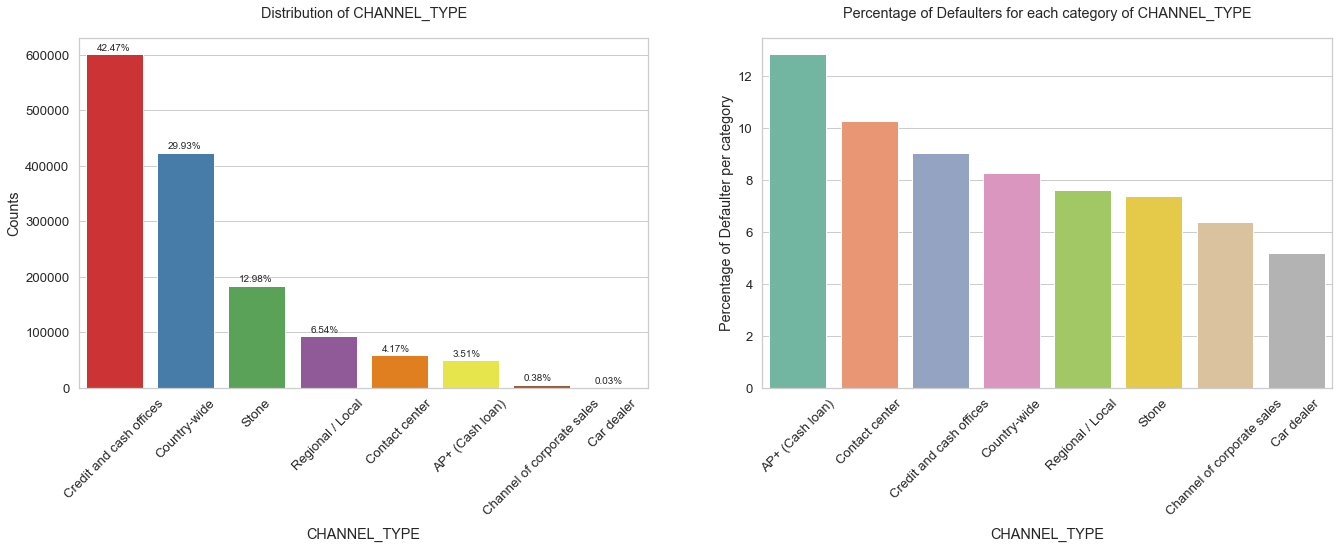

----------------------------------------------------------------------------------------------------


In [158]:
#let us first see the unique categories of 'CHANNEL_TYPE'
print_unique_categories(prev_merged, 'CHANNEL_TYPE')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'CHANNEL_TYPE', horizontal_adjust = 0.15, rotation = 45, figsize = (20, 6), fontsize_percent = 'x-small')
print('-'*100)

## Distribution of Categorical Variable PRODUCT_COMBINATION

----------------------------------------------------------------------------------------------------
The unique categories of 'PRODUCT_COMBINATION' are:
['POS other with interest' 'Cash X-Sell: low' 'POS industry with interest'
 'POS household with interest' 'POS mobile without interest' 'Card Street'
 'Card X-Sell' 'Cash X-Sell: high' 'Cash' 'Cash Street: high'
 'Cash X-Sell: middle' 'POS mobile with interest'
 'POS household without interest' 'POS industry without interest'
 'Cash Street: low' nan 'Cash Street: middle'
 'POS others without interest']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of PRODUCT_COMBINATION = 18


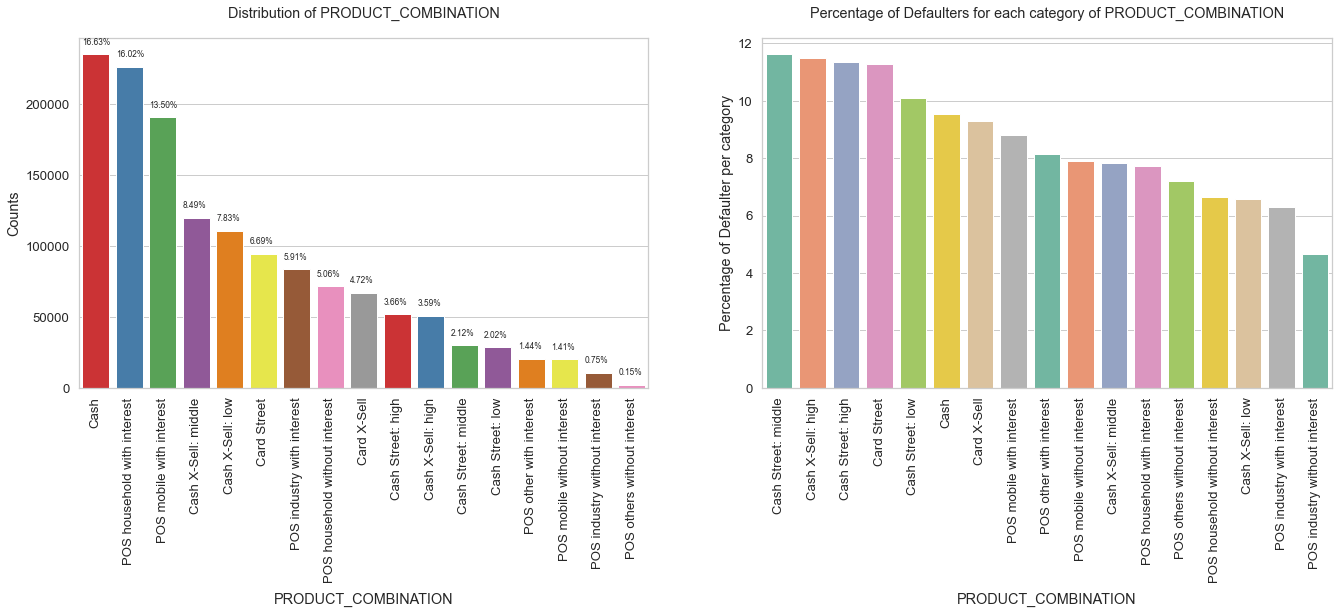

----------------------------------------------------------------------------------------------------


In [159]:
#let us first see the unique categories of 'PRODUCT_COMBINATION'
print_unique_categories(prev_merged, 'PRODUCT_COMBINATION')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'PRODUCT_COMBINATION', rotation = 90, figsize = (20, 6))
print('-'*100)

# Plotting Continuous Variables

## Distribution of Continuous Variable with DAYS Features

## DAYS_DECISION

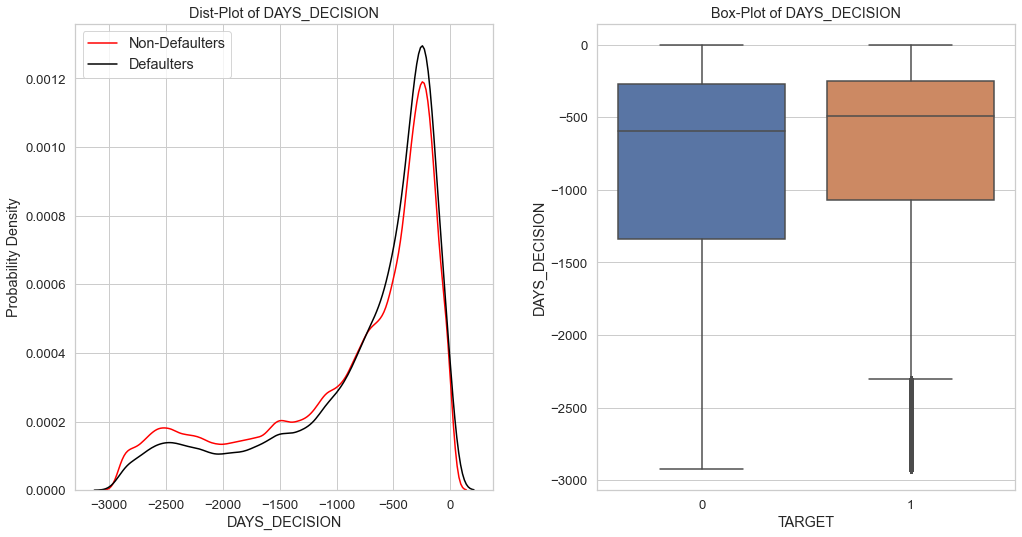

In [160]:
plot_continuous_variables(prev_merged, 'DAYS_DECISION', plots = ['distplot', 'box'], figsize = (15,8))

## DAYS_FIRST_DRAWING

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_FIRST_DRAWING is -2922.0
The 1th percentile value of DAYS_FIRST_DRAWING is -2451.0
The 2th percentile value of DAYS_FIRST_DRAWING is -1179.0
The 3th percentile value of DAYS_FIRST_DRAWING is -674.0
The 4th percentile value of DAYS_FIRST_DRAWING is -406.0
The 5th percentile value of DAYS_FIRST_DRAWING is -262.0
The 6th percentile value of DAYS_FIRST_DRAWING is -156.0
The 7th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 8th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 9th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 10th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 20th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 40th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 60th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 80th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 100th percentile

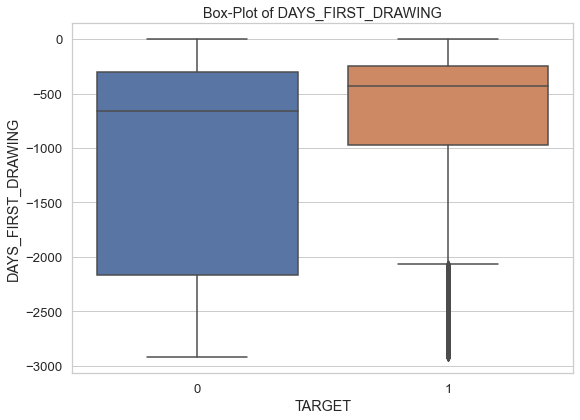

----------------------------------------------------------------------------------------------------


In [161]:
print_percentiles(prev_merged, 'DAYS_FIRST_DRAWING', percentiles = list(range(0,11)) + list(range(20,101,20)))
plot_continuous_variables(prev_merged, 'DAYS_FIRST_DRAWING', plots = ['box'], figsize = (8,6), scale_limits = [-3000,0])
print('-'*100)

## DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, and DAYS_TERMINATION

In [162]:
print('-'*100)
print("Percentile Values for DAYS_FIRST_DUE")
print_percentiles(prev_merged, 'DAYS_FIRST_DUE', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_LAST_DUE_1ST_VERSION")
print_percentiles(prev_merged, 'DAYS_LAST_DUE_1ST_VERSION', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_LAST_DUE")
print_percentiles(prev_merged, 'DAYS_LAST_DUE', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_TERMINATION")
print_percentiles(prev_merged, 'DAYS_TERMINATION', percentiles = list(range(0,11,2)) + [20,40,60,80,100])

----------------------------------------------------------------------------------------------------
Percentile Values for DAYS_FIRST_DUE
----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_FIRST_DUE is -2892.0
The 2th percentile value of DAYS_FIRST_DUE is -2759.0
The 4th percentile value of DAYS_FIRST_DUE is -2648.0
The 6th percentile value of DAYS_FIRST_DUE is -2555.0
The 8th percentile value of DAYS_FIRST_DUE is -2471.0
The 10th percentile value of DAYS_FIRST_DUE is -2388.0
The 20th percentile value of DAYS_FIRST_DUE is -1882.0
The 40th percentile value of DAYS_FIRST_DUE is -1070.0
The 60th percentile value of DAYS_FIRST_DUE is -647.0
The 80th percentile value of DAYS_FIRST_DUE is -329.0
The 100th percentile value of DAYS_FIRST_DUE is 365243.0
----------------------------------------------------------------------------------------------------
Percentile Values for DAYS_LAST_DUE_1ST_VERSION
------------

# Modelling

## Dataset Preparation

In [163]:
app_test['is_test'] = 1 
app_test['is_train'] = 0
app_train['is_test'] = 0
app_train['is_train'] = 1

# Target variable
Y = app_train['TARGET']
train_X = app_train.drop(['TARGET'], axis = 1)

# Test ID
test_id = app_test['SK_ID_CURR']
test_X = app_test

# Merge train and test datasets for preprocessing
data = pd.concat([train_X, test_X], axis=0)

### Handelling Categorical Features

In [164]:
# Function to obtain Categorical Features

def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats

# Function to factorize categorical features

def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

# Function to create dummy variables of categorical features

def _get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 

In [165]:
# Get categorical features

data_cats = _get_categorical_features(data)
prev_app_cats = _get_categorical_features(previous_application)
bureau_cats = _get_categorical_features(bureau_data)
pcb_cats = _get_categorical_features(pos_cash_balance)
ccbal_cats = _get_categorical_features(credit_card_balance)

# Create additional dummy features 

previous_application = _get_dummies(previous_application, prev_app_cats)
bureau_data = _get_dummies(bureau_data, bureau_cats)
pos_cash_balance = _get_dummies(pos_cash_balance, pcb_cats)
credit_card_balance = _get_dummies(credit_card_balance, ccbal_cats)

# Factorize the categorical features from train and test data

data = _factorize_categoricals(data, data_cats)

# Feature Engineering

### Feature Engineering - Previous Applications

In [166]:
# Count the number of previous applications for a given ID

prev_apps_count = previous_application[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
previous_application['SK_ID_PREV'] = previous_application['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

# Average values for all other features in previous applications

prev_apps_avg = previous_application.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['p_' + col for col in prev_apps_avg.columns]
data = data.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')

### Feature Engineering - Bureau Data

In [167]:
# Average Values for all bureau features 

bureau_avg = bureau_data.groupby('SK_ID_CURR').mean()
bureau_avg['buro_count'] = bureau_data[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
bureau_avg.columns = ['b_' + f_ for f_ in bureau_avg.columns]
data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')

### Feature Engineering - Previous Installments

In [168]:
# Count the number of previous installments

cnt_inst = installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
installments_payments['SK_ID_PREV'] = installments_payments['SK_ID_CURR'].map(cnt_inst['SK_ID_PREV'])

# Average values for all other variables in installments payments

avg_inst = installments_payments.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['i_' + f_ for f_ in avg_inst.columns]
data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')

### Feature Engineering - Pos Cash Balance

In [169]:
# Count the number of pos cash for a given ID

pcb_count = pos_cash_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos_cash_balance['SK_ID_PREV'] = pos_cash_balance['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])

# Average Values for all other variables in pos cash

pcb_avg = pos_cash_balance.groupby('SK_ID_CURR').mean()
data = data.merge(right=pcb_avg.reset_index(), how='left', on='SK_ID_CURR')

### Feature Engineering - Credit Card Balance Balance

In [170]:
# Count the number of previous applications for a given ID

nb_prevs = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_card_balance['SK_ID_PREV'] = credit_card_balance['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

# Average of all other columns 

avg_cc_bal = credit_card_balance.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

### Prepare Final Train and Test data

In [171]:
# Prepare final Train X and Test X dataframes 

ignore_features = ['SK_ID_CURR', 'is_train', 'is_test']
relevant_features = [col for col in data.columns if col not in ignore_features]
trainX = data[data['is_train'] == 1][relevant_features]
testX = data[data['is_test'] == 1][relevant_features]

### Create Validation Sets

In [172]:
x_train, x_val, y_train, y_val = train_test_split(trainX, Y, test_size=0.2, random_state=18)
x_train = x_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
x_val = x_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [173]:
over_sampler = RandomOverSampler()
x_oversample, y_oversample = over_sampler.fit_resample(x_train, y_train)

In [174]:
under_sampler = RandomUnderSampler()
x_undersample, y_undersample = under_sampler.fit_resample(x_train, y_train)

## CatBoost Model

0:	test: 0.6972327	best: 0.6972327 (0)	total: 400ms	remaining: 6m 39s
50:	test: 0.7720936	best: 0.7720936 (50)	total: 13.6s	remaining: 4m 13s
100:	test: 0.7853775	best: 0.7853775 (100)	total: 26s	remaining: 3m 51s
150:	test: 0.7967505	best: 0.7967505 (150)	total: 37.5s	remaining: 3m 31s
200:	test: 0.8082143	best: 0.8082143 (200)	total: 49.3s	remaining: 3m 16s
250:	test: 0.8178639	best: 0.8178639 (250)	total: 1m 1s	remaining: 3m 2s
300:	test: 0.8267936	best: 0.8267936 (300)	total: 1m 13s	remaining: 2m 49s
350:	test: 0.8349678	best: 0.8349678 (350)	total: 1m 24s	remaining: 2m 37s
400:	test: 0.8422596	best: 0.8422596 (400)	total: 1m 35s	remaining: 2m 22s
450:	test: 0.8498185	best: 0.8498185 (450)	total: 1m 47s	remaining: 2m 10s
500:	test: 0.8565256	best: 0.8565256 (500)	total: 1m 58s	remaining: 1m 57s
550:	test: 0.8632443	best: 0.8632443 (550)	total: 2m 9s	remaining: 1m 45s
600:	test: 0.8693919	best: 0.8693919 (600)	total: 2m 21s	remaining: 1m 33s
650:	test: 0.8756235	best: 0.8756235 (650

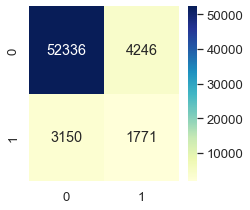

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     56582
           1       0.29      0.36      0.32      4921

    accuracy                           0.88     61503
   macro avg       0.62      0.64      0.63     61503
weighted avg       0.89      0.88      0.89     61503

------------------------------------------
AUC - ROC Score              = 0.6424223346742877
Model Training time            =  239.02636003494263 seconds 


In [175]:
# Model Training

start = time.time()

ctb = CatBoostClassifier(iterations=1000,
                         learning_rate=0.1,
                         depth=7,
                         l2_leaf_reg=40,
                         bootstrap_type='Bernoulli',
                         subsample=0.7,
                         scale_pos_weight=5,
                         eval_metric='AUC',
                         metric_period=50,
                         od_type='Iter',
                         od_wait=45,
                         random_seed=17,
                         allow_writing_files=False)
ctb.fit(x_train, y_train, eval_set = (x_train, y_train), use_best_model=True, verbose=True)

# Model Prediction

y_pred_ctb = ctb.predict(x_val)

# Model Evaluation

print("Training Accuracy :", ctb.score(x_train, y_train))
print("Testing Accuracy :", ctb.score(x_val, y_val))

cm = confusion_matrix(y_val, y_pred_ctb)
plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(cm, annot = True, cmap = 'YlGnBu', fmt = '.8g')
plt.show()

cr = classification_report(y_val, y_pred_ctb)
print(cr)

print("------------------------------------------")

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val,y_pred_ctb)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("AUC - ROC Score              =",roc_auc)
end = time.time()
print("Model Training time            =  {} seconds ".format(end-start))

In [176]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:20], y=fi_df['feature_names'][:20])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

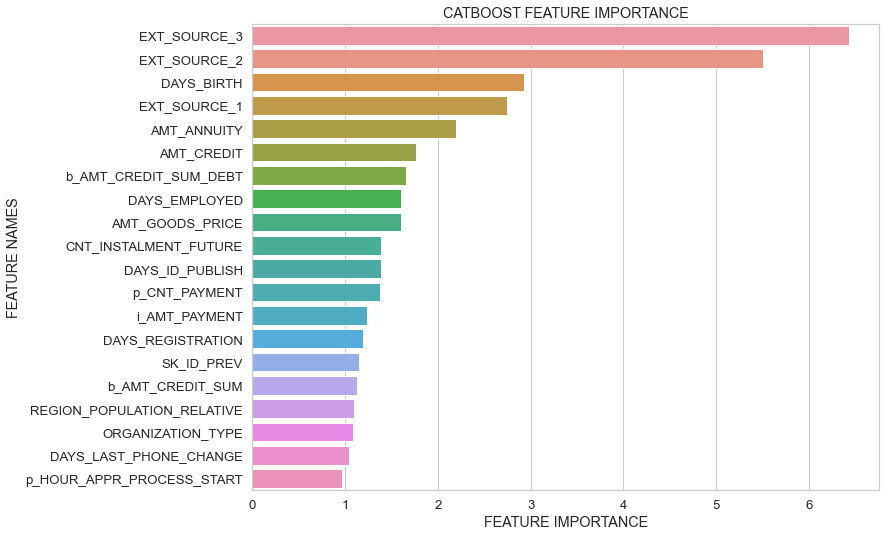

In [177]:
# Plot the CAT Boost feature importance

plot_feature_importance(ctb.get_feature_importance(),x_train.columns,'CATBOOST ')

## CatBoost Model with Oversampling

0:	test: 0.6768217	best: 0.6768217 (0)	total: 472ms	remaining: 7m 51s
50:	test: 0.7724197	best: 0.7724197 (50)	total: 19.6s	remaining: 6m 5s
100:	test: 0.7883589	best: 0.7883589 (100)	total: 36.5s	remaining: 5m 25s
150:	test: 0.7999379	best: 0.7999379 (150)	total: 53.1s	remaining: 4m 58s
200:	test: 0.8103626	best: 0.8103626 (200)	total: 1m 8s	remaining: 4m 33s
250:	test: 0.8193724	best: 0.8193724 (250)	total: 1m 25s	remaining: 4m 14s
300:	test: 0.8281027	best: 0.8281027 (300)	total: 1m 41s	remaining: 3m 55s
350:	test: 0.8356778	best: 0.8356778 (350)	total: 1m 57s	remaining: 3m 36s
400:	test: 0.8427272	best: 0.8427272 (400)	total: 2m 13s	remaining: 3m 19s
450:	test: 0.8489129	best: 0.8489129 (450)	total: 2m 28s	remaining: 3m 1s
500:	test: 0.8548348	best: 0.8548348 (500)	total: 2m 45s	remaining: 2m 44s
550:	test: 0.8609237	best: 0.8609237 (550)	total: 3m	remaining: 2m 27s
600:	test: 0.8665736	best: 0.8665736 (600)	total: 3m 16s	remaining: 2m 10s
650:	test: 0.8716314	best: 0.8716314 (650)

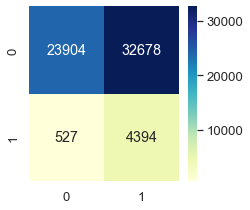

              precision    recall  f1-score   support

           0       0.98      0.42      0.59     56582
           1       0.12      0.89      0.21      4921

    accuracy                           0.46     61503
   macro avg       0.55      0.66      0.40     61503
weighted avg       0.91      0.46      0.56     61503

------------------------------------------
AUC - ROC Score              = 0.6576872271616183
Model Training time            =  328.77345991134644 seconds 


In [178]:
# Model Training

start = time.time()

ctb = CatBoostClassifier(iterations=1000,
                         learning_rate=0.1,
                         depth=7,
                         l2_leaf_reg=40,
                         bootstrap_type='Bernoulli',
                         subsample=0.7,
                         scale_pos_weight=5,
                         eval_metric='AUC',
                         metric_period=50,
                         od_type='Iter',
                         od_wait=45,
                         random_seed=17,
                         allow_writing_files=False)
ctb.fit(x_oversample, y_oversample, eval_set = (x_train, y_train), use_best_model=True, verbose=True)

# Model Prediction

y_pred_ctb = ctb.predict(x_val)

# Model Evaluation

print("Training Accuracy :", ctb.score(x_oversample, y_oversample))
print("Testing Accuracy :", ctb.score(x_val, y_val))

cm = confusion_matrix(y_val, y_pred_ctb)
plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(cm, annot = True, cmap = 'YlGnBu', fmt = '.8g')
plt.show()

cr = classification_report(y_val, y_pred_ctb)
print(cr)

print("------------------------------------------")

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val,y_pred_ctb)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("AUC - ROC Score              =",roc_auc)
end = time.time()
print("Model Training time            =  {} seconds ".format(end-start))

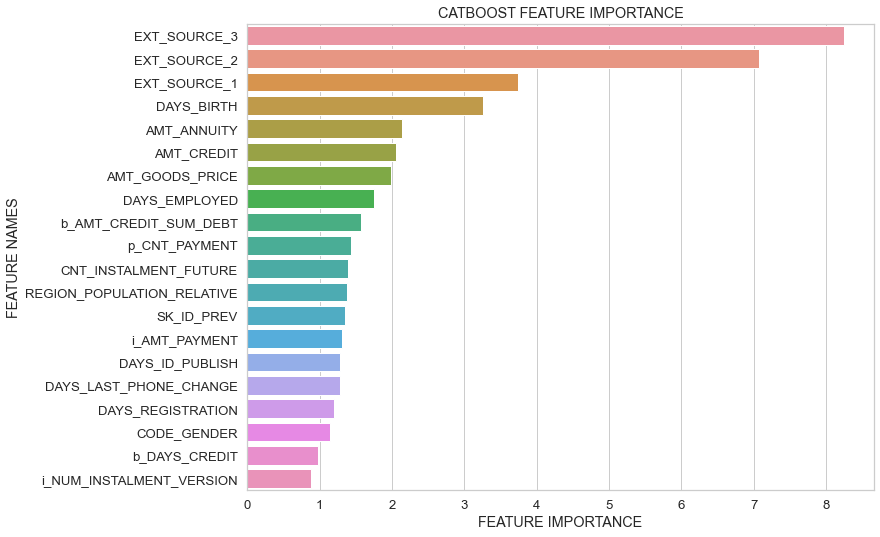

In [179]:
# Plot the CAT Boost feature importance

plot_feature_importance(ctb.get_feature_importance(),x_train.columns,'CATBOOST ')

## CatBoost Model with Undersampling

0:	test: 0.6198021	best: 0.6198021 (0)	total: 94.2ms	remaining: 1m 34s
50:	test: 0.7561269	best: 0.7561269 (50)	total: 4.58s	remaining: 1m 25s
100:	test: 0.7707662	best: 0.7707662 (100)	total: 8.91s	remaining: 1m 19s
150:	test: 0.7837213	best: 0.7837213 (150)	total: 13.6s	remaining: 1m 16s
200:	test: 0.7925728	best: 0.7925728 (200)	total: 18.4s	remaining: 1m 13s
250:	test: 0.7994622	best: 0.7994622 (250)	total: 23s	remaining: 1m 8s
300:	test: 0.8060268	best: 0.8060268 (300)	total: 27.5s	remaining: 1m 3s
350:	test: 0.8112515	best: 0.8112515 (350)	total: 31.9s	remaining: 59s
400:	test: 0.8155338	best: 0.8155338 (400)	total: 36.1s	remaining: 53.9s
450:	test: 0.8206677	best: 0.8206677 (450)	total: 40.3s	remaining: 49s
500:	test: 0.8250060	best: 0.8250060 (500)	total: 44.7s	remaining: 44.5s
550:	test: 0.8292720	best: 0.8292720 (550)	total: 49s	remaining: 39.9s
600:	test: 0.8333983	best: 0.8333983 (600)	total: 53.1s	remaining: 35.2s
650:	test: 0.8373359	best: 0.8373359 (650)	total: 57.2s	rem

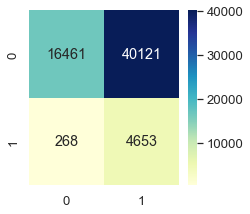

              precision    recall  f1-score   support

           0       0.98      0.29      0.45     56582
           1       0.10      0.95      0.19      4921

    accuracy                           0.34     61503
   macro avg       0.54      0.62      0.32     61503
weighted avg       0.91      0.34      0.43     61503

------------------------------------------
AUC - ROC Score              = 0.6182312164161516
Model Training time            =  89.0395393371582 seconds 


In [180]:
# Model Training

start = time.time()

ctb = CatBoostClassifier(iterations=1000,
                         learning_rate=0.1,
                         depth=7,
                         l2_leaf_reg=40,
                         bootstrap_type='Bernoulli',
                         subsample=0.7,
                         scale_pos_weight=5,
                         eval_metric='AUC',
                         metric_period=50,
                         od_type='Iter',
                         od_wait=45,
                         random_seed=17,
                         allow_writing_files=False)
ctb.fit(x_undersample, y_undersample, eval_set = (x_train, y_train), use_best_model=True, verbose=True)

# Model Prediction

y_pred_ctb = ctb.predict(x_val)

# Model Evaluation

print("Training Accuracy :", ctb.score(x_undersample, y_undersample))
print("Testing Accuracy :", ctb.score(x_val, y_val))

cm = confusion_matrix(y_val, y_pred_ctb)
plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(cm, annot = True, cmap = 'YlGnBu', fmt = '.8g')
plt.show()

cr = classification_report(y_val, y_pred_ctb)
print(cr)

print("------------------------------------------")

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val,y_pred_ctb)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("AUC - ROC Score              =",roc_auc)
end = time.time()
print("Model Training time            =  {} seconds ".format(end-start))

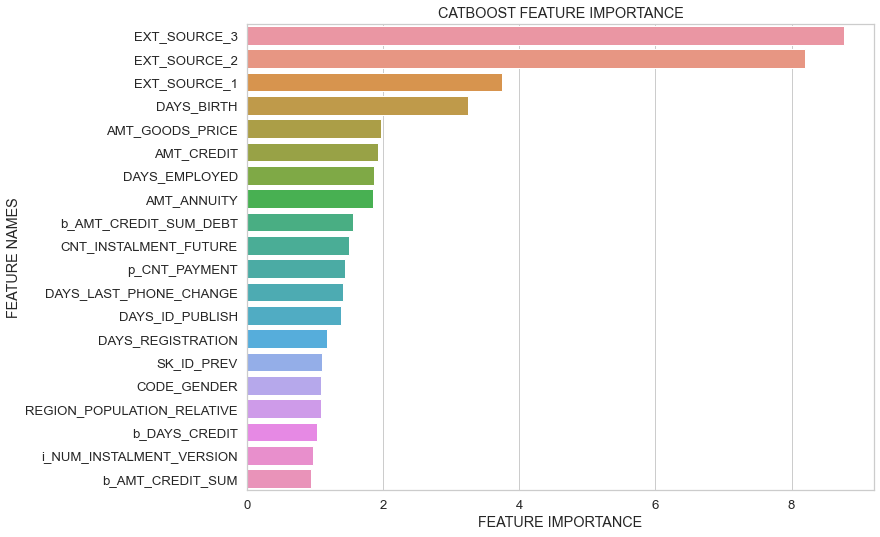

In [181]:
# Plot the CAT Boost feature importance

plot_feature_importance(ctb.get_feature_importance(),x_train.columns,'CATBOOST ')

## XG Boost Model

[18:25:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy : 0.9583062339436116
Testing Accuracy : 0.9166707315090321


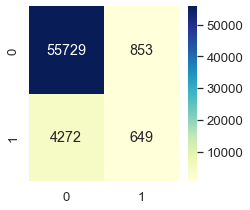

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     56582
           1       0.43      0.13      0.20      4921

    accuracy                           0.92     61503
   macro avg       0.68      0.56      0.58     61503
weighted avg       0.89      0.92      0.90     61503

------------------------------------------
AUC - ROC Score              = 0.5584041488834532
Model Training time            =  2543.5529589653015 seconds 


In [182]:
# Model Training

start = time.time()

xgb = XGBClassifier(n_estimators= 1000,learning_rate= 0.1,scale_pos_weight=2)
xgb.fit(x_train, y_train)

# Model Prediction

y_predicted_xgb = xgb.predict(x_val)

print("Training Accuracy :", xgb.score(x_train, y_train))
print("Testing Accuracy :", xgb.score(x_val, y_val))

# Model Evaluation

cm = confusion_matrix(y_val, y_predicted_xgb)
plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(cm, annot = True, cmap = 'YlGnBu', fmt = '.8g')
plt.show()

cr = classification_report(y_val, y_predicted_xgb)
print(cr)

print("------------------------------------------")

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val,y_predicted_xgb)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("AUC - ROC Score              =",roc_auc)
end = time.time()
print("Model Training time            =  {} seconds ".format(end-start))

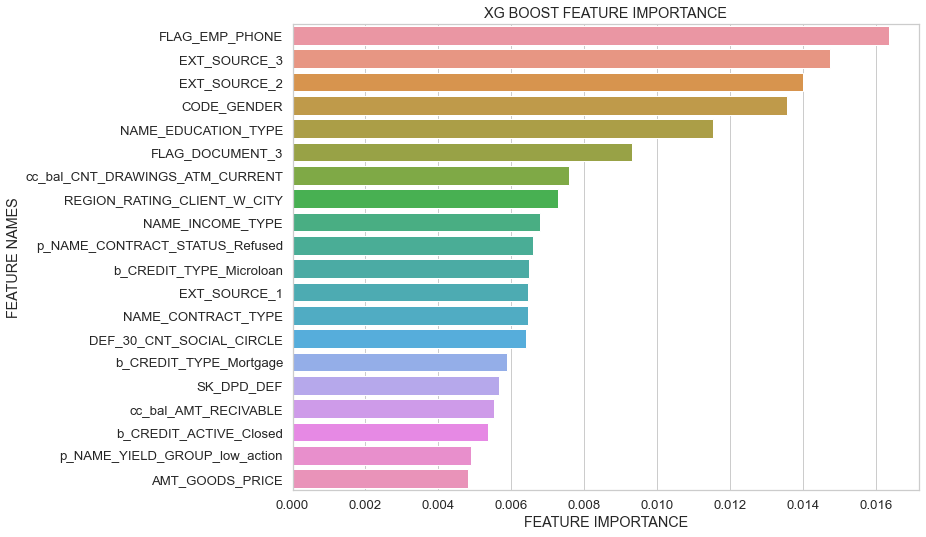

In [183]:
# Plot the XG Boost feature importance

plot_feature_importance(xgb.feature_importances_,x_train.columns,'XG BOOST ')

## XG Boost Model with Oversampling

[19:07:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy : 0.8841816155397516
Testing Accuracy : 0.7285986049461002


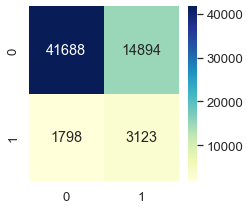

              precision    recall  f1-score   support

           0       0.96      0.74      0.83     56582
           1       0.17      0.63      0.27      4921

    accuracy                           0.73     61503
   macro avg       0.57      0.69      0.55     61503
weighted avg       0.90      0.73      0.79     61503

------------------------------------------
AUC - ROC Score              = 0.6856992598571191
Model Training time            =  4293.713915348053 seconds 


In [184]:
# Model Training

start = time.time()

xgb = XGBClassifier(n_estimators= 1000,learning_rate= 0.1,scale_pos_weight=2)
xgb.fit(x_oversample, y_oversample)

# Model Prediction

y_predicted_xgb = xgb.predict(x_val)

print("Training Accuracy :", xgb.score(x_oversample, y_oversample))
print("Testing Accuracy :", xgb.score(x_val, y_val))

# Model Evaluation

cm = confusion_matrix(y_val, y_predicted_xgb)
plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(cm, annot = True, cmap = 'YlGnBu', fmt = '.8g')
plt.show()

cr = classification_report(y_val, y_predicted_xgb)
print(cr)

print("------------------------------------------")

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val,y_predicted_xgb)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("AUC - ROC Score              =",roc_auc)
end = time.time()
print("Model Training time            =  {} seconds ".format(end-start))

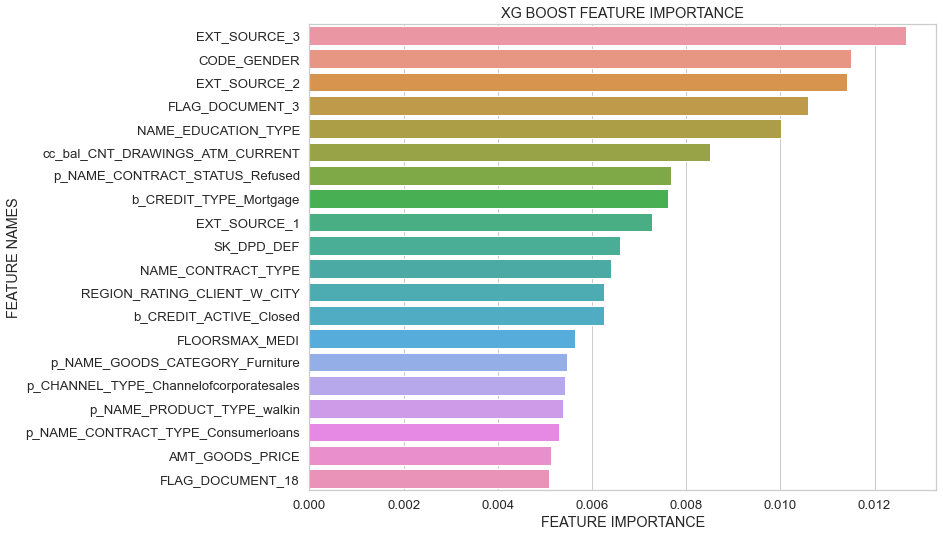

In [185]:
# Plot the XG Boost feature importance

plot_feature_importance(xgb.feature_importances_,x_train.columns,'XG BOOST ')

## XG Boost Model with Undersampling

[20:19:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy : 0.9740002009646302
Testing Accuracy : 0.6084093458855666


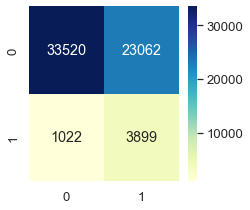

              precision    recall  f1-score   support

           0       0.97      0.59      0.74     56582
           1       0.14      0.79      0.24      4921

    accuracy                           0.61     61503
   macro avg       0.56      0.69      0.49     61503
weighted avg       0.90      0.61      0.70     61503

------------------------------------------
AUC - ROC Score              = 0.6923665916101673
Model Training time            =  448.6815712451935 seconds 


In [186]:
# Model Training

start = time.time()

xgb = XGBClassifier(n_estimators= 1000,learning_rate= 0.1,scale_pos_weight=2)
xgb.fit(x_undersample, y_undersample)

# Model Prediction

y_predicted_xgb = xgb.predict(x_val)

print("Training Accuracy :", xgb.score(x_undersample, y_undersample))
print("Testing Accuracy :", xgb.score(x_val, y_val))

# Model Evaluation

cm = confusion_matrix(y_val, y_predicted_xgb)
plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(cm, annot = True, cmap = 'YlGnBu', fmt = '.8g')
plt.show()

cr = classification_report(y_val, y_predicted_xgb)
print(cr)

print("------------------------------------------")

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val,y_predicted_xgb)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("AUC - ROC Score              =",roc_auc)
end = time.time()
print("Model Training time            =  {} seconds ".format(end-start))

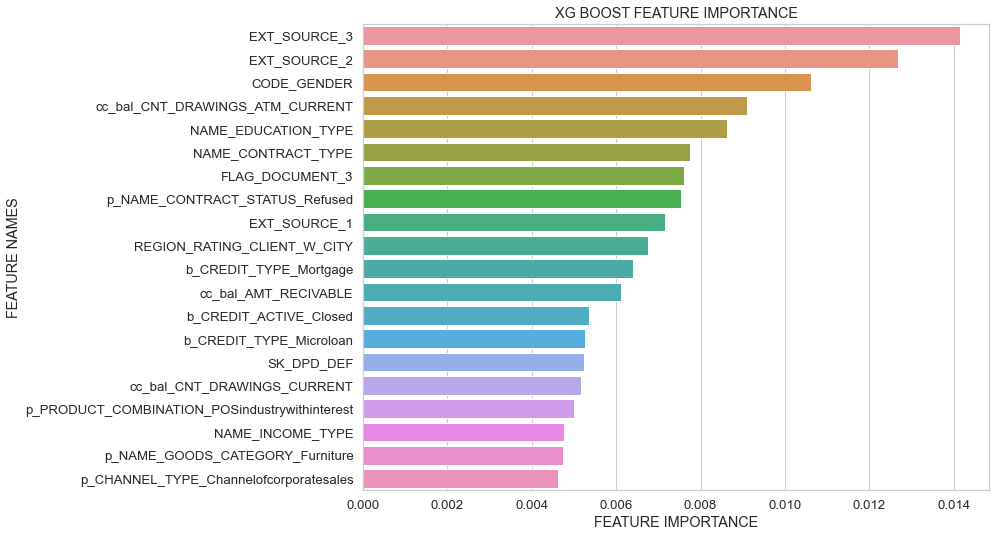

In [187]:
# Plot the XG Boost feature importance

plot_feature_importance(xgb.feature_importances_,x_train.columns,'XG BOOST ')

## Light GBM Model

In [188]:
# Model Training

start = time.time()

lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_test = lgb.Dataset(data=x_val, label=y_val)

params = {'task': 'train', 
          'boosting_type': 'gbdt',
          'objective': 'binary', 
          'nthread':-1,
          'metric': 'auc', 
          'learning_rate': 0.01,
          'num_leaves': 58, 
          'n_estimators':5000,
          'verbose': -1 ,
          'colsample_bytree':.613,
          'min_child_weight':6,
          'min_child_samples':165,
          'subsample':.708,
          'max_depth':11,
          'max_bin':407,
          'reg_alpha':3.564, 
          'reg_lambda':4.930,
          'min_split_gain':.01}

model = lgb.train(params, lgb_train, valid_sets=lgb_test, early_stopping_rounds=150, verbose_eval=200)
end = time.time()
print("Model Training time            =  {} seconds ".format(end-start))

Training until validation scores don't improve for 150 rounds
[200]	valid_0's auc: 0.761737
[400]	valid_0's auc: 0.772171
[600]	valid_0's auc: 0.77762
[800]	valid_0's auc: 0.780476
[1000]	valid_0's auc: 0.78212
[1200]	valid_0's auc: 0.78312
[1400]	valid_0's auc: 0.783689
[1600]	valid_0's auc: 0.783994
[1800]	valid_0's auc: 0.784227
[2000]	valid_0's auc: 0.784343
[2200]	valid_0's auc: 0.784401
[2400]	valid_0's auc: 0.784545
[2600]	valid_0's auc: 0.78463
[2800]	valid_0's auc: 0.784645
[3000]	valid_0's auc: 0.784796
Early stopping, best iteration is:
[3044]	valid_0's auc: 0.78482
Model Training time            =  535.2170701026917 seconds 


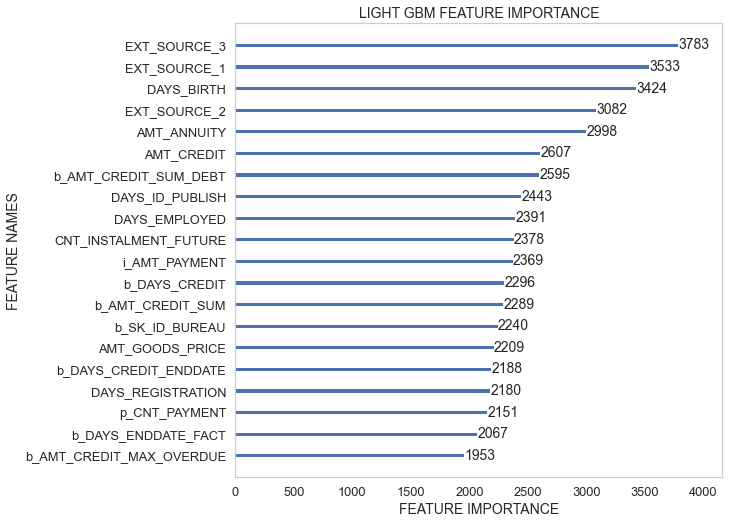

In [189]:
# Plot the Light GBM feature importance

lgb.plot_importance(model, figsize=(8, 8), max_num_features=20, title='LIGHT GBM FEATURE IMPORTANCE', ylabel='FEATURE NAMES', xlabel='FEATURE IMPORTANCE', grid=False, dpi=70);

## Light GBM Model with Oversampling

In [190]:
# Model Training

start = time.time()

lgb_train = lgb.Dataset(data=x_oversample, label=y_oversample)
lgb_test = lgb.Dataset(data=x_val, label=y_val)

params = {'task': 'train', 
          'boosting_type': 'gbdt',
          'objective': 'binary', 
          'nthread':-1,
          'metric': 'auc', 
          'learning_rate': 0.01,
          'num_leaves': 58, 
          'n_estimators':5000,
          'verbose': -1 ,
          'colsample_bytree':.613,
          'min_child_weight':6,
          'min_child_samples':165,
          'subsample':.708,
          'max_depth':11,
          'max_bin':407,
          'reg_alpha':3.564, 
          'reg_lambda':4.930,
          'min_split_gain':.01}

model = lgb.train(params, lgb_train, valid_sets=lgb_test, early_stopping_rounds=150, verbose_eval=200)
end = time.time()
print("Model Training time            =  {} seconds ".format(end-start))

Training until validation scores don't improve for 150 rounds
[200]	valid_0's auc: 0.761359
[400]	valid_0's auc: 0.771746
[600]	valid_0's auc: 0.777231
[800]	valid_0's auc: 0.779834
[1000]	valid_0's auc: 0.781254
[1200]	valid_0's auc: 0.781826
[1400]	valid_0's auc: 0.782388
[1600]	valid_0's auc: 0.782523
[1800]	valid_0's auc: 0.782668
[2000]	valid_0's auc: 0.782667
Early stopping, best iteration is:
[1955]	valid_0's auc: 0.782783
Model Training time            =  518.921049118042 seconds 


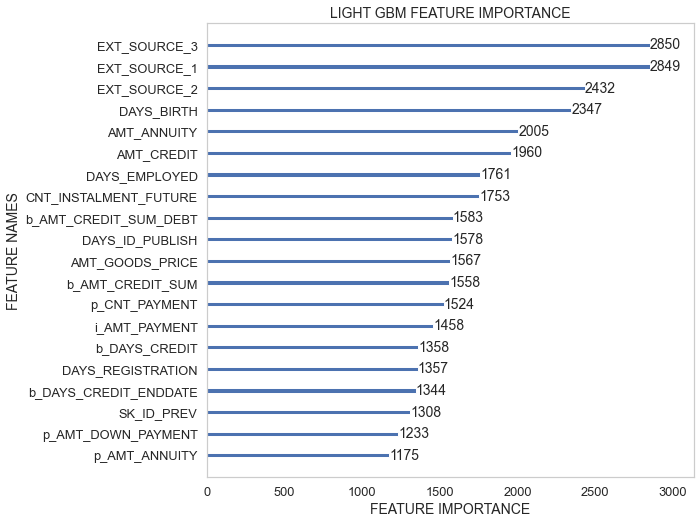

In [191]:
# Plot the Light GBM feature importance

lgb.plot_importance(model, figsize=(8, 8), max_num_features=20, title='LIGHT GBM FEATURE IMPORTANCE', ylabel='FEATURE NAMES', xlabel='FEATURE IMPORTANCE', grid=False, dpi=70);

## Light GBM Model with Undersampling

In [192]:
# Model Training

start = time.time()

lgb_train = lgb.Dataset(data=x_undersample, label=y_undersample)
lgb_test = lgb.Dataset(data=x_val, label=y_val)

params = {'task': 'train', 
          'boosting_type': 'gbdt',
          'objective': 'binary', 
          'nthread':-1,
          'metric': 'auc', 
          'learning_rate': 0.01,
          'num_leaves': 58, 
          'n_estimators':5000,
          'verbose': -1 ,
          'colsample_bytree':.613,
          'min_child_weight':6,
          'min_child_samples':165,
          'subsample':.708,
          'max_depth':11,
          'max_bin':407,
          'reg_alpha':3.564, 
          'reg_lambda':4.930,
          'min_split_gain':.01}

model = lgb.train(params, lgb_train, valid_sets=lgb_test, early_stopping_rounds=150, verbose_eval=200)
end = time.time()
print("Model Training time            =  {} seconds ".format(end-start))

Training until validation scores don't improve for 150 rounds
[200]	valid_0's auc: 0.759053
[400]	valid_0's auc: 0.768368
[600]	valid_0's auc: 0.77315
[800]	valid_0's auc: 0.775518
[1000]	valid_0's auc: 0.776561
[1200]	valid_0's auc: 0.777201
[1400]	valid_0's auc: 0.777546
[1600]	valid_0's auc: 0.77754
Early stopping, best iteration is:
[1569]	valid_0's auc: 0.777576
Model Training time            =  119.7022454738617 seconds 


### Feature Importance

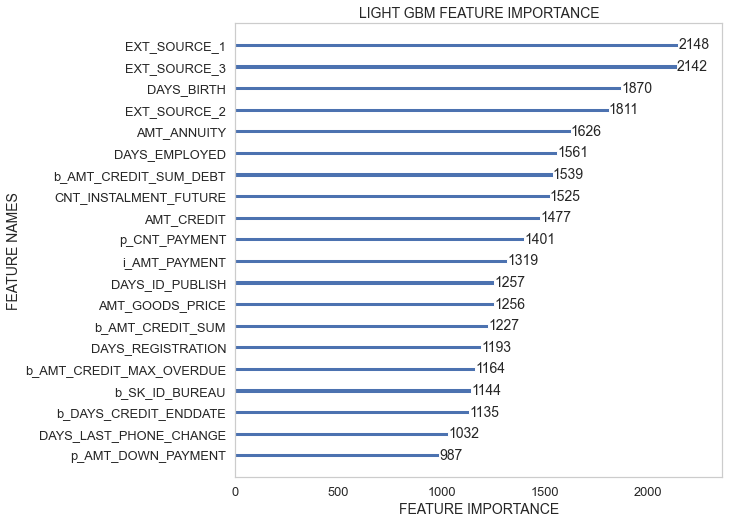

In [193]:
# Plot the Light GBM feature importance

lgb.plot_importance(model, figsize=(8, 8), max_num_features=20, title='LIGHT GBM FEATURE IMPORTANCE', ylabel='FEATURE NAMES', xlabel='FEATURE IMPORTANCE', grid=False, dpi=70);

### Prediction

In [194]:
preds = model.predict(testX)
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_id
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("lgb_baseline.csv", index=False)
sub_lgb.head()

SK_ID_CURR    TARGET
0      100001  0.299665
1      100005  0.578496
2      100013  0.185672
3      100028  0.251512
4      100038  0.713721